In [1]:
# instalamos librería pca
!pip install -q pca
!pip install --upgrade plotly --q

# Tratamiento de datos
# ==============================================================================
import pandas as pd
from pandas.plotting import table
import numpy as np
import statsmodels.api as sm
import sklearn
import six
import ftplib
import os
import math

# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt
from matplotlib import style
from matplotlib.dates import date2num, num2date
import seaborn as sns
from matplotlib import dates as mdates
from matplotlib import ticker
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch
from matplotlib import animation
plt.style.use("ggplot")# for pretty graphs
from IPython.display import clear_output
import plotly.express as px

# Preprocesado y modelado
# ==============================================================================
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import scale
from sklearn.cluster import k_means
from sklearn.metrics import pairwise_distances_argmin_min
from sklearn.cluster import KMeans
import scipy.cluster.hierarchy as sch
from sklearn.cluster import AgglomerativeClustering

# Configuración warnings
# ==============================================================================
import warnings
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import pandas as pd

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [273]:
path = 'https://raw.githubusercontent.com/arthurbaleeiro/ArtBaleeiro/main/TFMCSV.csv'
bd_epidem1 = pd.read_csv(path, sep=";")
bd_epidem1.head()

,Column1,fecha,iso,ccaa,sexo,edad,poblacion,confirmados,hospitalizados,uci,fallecidos,Unnamed: 11,Unnamed: 12,Unnamed: 13
0,1,01/01/2020,AN,Andalucía,Total,Total,8465236,0,3,0,0,NaN,NaN,NaN
1,2,01/01/2020,AN,Andalucía,Total,0-9,786909,0,0,0,0,NaN,NaN,NaN
2,3,01/01/2020,AN,Andalucía,Total,10-19,955318,0,0,0,0,NaN,NaN,NaN
3,4,01/01/2020,AN,Andalucía,Total,20-29,922665,0,0,0,0,NaN,NaN,NaN
4,5,01/01/2020,AN,Andalucía,Total,30-39,1108837,0,1,0,0,NaN,NaN,NaN


In [274]:
# Quitar las columnas con datos irrelevantes o sin uso

bd_epidem1 = bd_epidem1.drop(columns=['Unnamed: 11','Unnamed: 12', 'Unnamed: 13', 'Column1'])
bd_epidem1.head(5)

,fecha,iso,ccaa,sexo,edad,poblacion,confirmados,hospitalizados,uci,fallecidos
0,01/01/2020,AN,Andalucía,Total,Total,8465236,0,3,0,0
1,01/01/2020,AN,Andalucía,Total,0-9,786909,0,0,0,0
2,01/01/2020,AN,Andalucía,Total,10-19,955318,0,0,0,0
3,01/01/2020,AN,Andalucía,Total,20-29,922665,0,0,0,0
4,01/01/2020,AN,Andalucía,Total,30-39,1108837,0,1,0,0


In [275]:
# Calculo y Estimacion del numero de recuperados

bd_epidem1['recuperados'] = bd_epidem1['confirmados'] - bd_epidem1['fallecidos']
bd_epidem1.head(5)

,fecha,iso,ccaa,sexo,edad,poblacion,confirmados,hospitalizados,uci,fallecidos,recuperados
0,01/01/2020,AN,Andalucía,Total,Total,8465236,0,3,0,0,0
1,01/01/2020,AN,Andalucía,Total,0-9,786909,0,0,0,0,0
2,01/01/2020,AN,Andalucía,Total,10-19,955318,0,0,0,0,0
3,01/01/2020,AN,Andalucía,Total,20-29,922665,0,0,0,0,0
4,01/01/2020,AN,Andalucía,Total,30-39,1108837,0,1,0,0,0


In [276]:
# Calculo y Estimacion de R0 (La tasa de transmicion de la epidemia)

bd_epidem1['R0'] =  (bd_epidem1['confirmados'] * bd_epidem1['poblacion'])/(bd_epidem1['recuperados'] * bd_epidem1['poblacion']- bd_epidem1['recuperados']-bd_epidem1['fallecidos'])
bd_epidem1.describe()

,poblacion,confirmados,hospitalizados,uci,fallecidos,recuperados,R0
count,4.055040e+05,405504.000000,405504.000000,405504.000000,405504.000000,405504.000000,2.091190e+05
mean,2.393836e+05,35.854512,3.524098,0.331282,0.783825,35.070687,-1.205590e+03
std,6.694737e+05,180.262150,20.410254,1.856880,4.912941,177.866362,3.297994e+04
min,0.000000e+00,0.000000,0.000000,0.000000,0.000000,-28.000000,-4.295289e+06
25%,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,1.000004e+00
50%,6.314100e+04,1.000000,0.000000,0.000000,0.000000,1.000000,1.000011e+00
75%,1.944260e+05,15.000000,1.000000,0.000000,0.000000,15.000000,1.000075e+00
max,8.465236e+06,9583.000000,1930.000000,135.000000,334.000000,9490.000000,2.900022e+01


In [277]:
# FILTRO EN RECUPERADOS - Los valores negativos no tienen sentido real y aparecen sobretodo debido a la falta de datos al principio de la pandemia - los pasaremos a cero
bd_epidem1.recuperados = np.where(bd_epidem1.recuperados < 0, 0, bd_epidem1.recuperados)

# FILTRO EN R0 - Trabajaremos solamente con los valores de R0 que tienen un sentido real. Todos valores fueara del rango de 0 a 10 seran eliminados 
bd_epidem1 = bd_epidem1[(bd_epidem1.R0 >= 0) & (bd_epidem1.R0 <= 10)]

# PASAR R0 A NUMERICO
bd_epidem1['R0'] = bd_epidem1['R0'].astype(float)

# ELIMINAR CASOS EN QUE LA POBLACION ES CERO 
bd_epidem1 = bd_epidem1[(bd_epidem1.poblacion != 0)]

# ELIMINAR CASOS EN QUE GENERO ES NULO O TOTAL
bd_epidem1 = bd_epidem1[(bd_epidem1.sexo != 'Total') & (bd_epidem1.sexo != 'NC')]

# ELIMINAR CASOS EN QUE EDAD ES NULO O TOTAL
bd_epidem1 = bd_epidem1[(bd_epidem1.edad != 'Total') & (bd_epidem1.edad != 'NC')]

# ELIMINAR ATIPICOS
bd_epidem1 = bd_epidem1.iloc[:, 0:12]

bd_epidem1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 116855 entries, 14107 to 405491
Data columns (total 12 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   fecha           116855 non-null  object 
 1   iso             116855 non-null  object 
 2   ccaa            116855 non-null  object 
 3   sexo            116855 non-null  object 
 4   edad            116855 non-null  object 
 5   poblacion       116855 non-null  int64  
 6   confirmados     116855 non-null  int64  
 7   hospitalizados  116855 non-null  int64  
 8   uci             116855 non-null  int64  
 9   fallecidos      116855 non-null  int64  
 10  recuperados     116855 non-null  int64  
 11  R0              116855 non-null  float64
dtypes: float64(1), int64(6), object(5)
memory usage: 11.6+ MB


In [278]:
# Eliminar Ceuta y Melilla (Esas CCAA las consideramos outliers)

bd_epidem = bd_epidem1.drop(bd_epidem1[bd_epidem1['ccaa']=='Ceuta y Melilla'].index)
bd_epidem.ccaa.unique()

array(['Madrid', 'Canarias', 'Islas Baleares', 'Cataluña',
       'Comunidad Valenciana', 'Castilla y León', 'La Rioja', 'Aragón',
       'Andalucía', 'Extremadura', 'Navarra', 'País Vasco', 'Asturias',
       'Cantabria', 'Castilla-La Mancha', 'Galicia', 'Murcia'],
      dtype=object)

In [8]:
bd_epidem.describe().T

,count,mean,std,min,25%,50%,75%,max
poblacion,112862.0,167838.027414,158969.464076,8278.0,55330.000000,105278.000000,220391.000000,687514.000000
confirmados,112862.0,31.910918,60.367095,0.0,4.000000,11.000000,32.000000,828.000000
hospitalizados,112862.0,3.083527,8.708589,0.0,0.000000,1.000000,3.000000,269.000000
uci,112862.0,0.290629,1.023744,0.0,0.000000,0.000000,0.000000,35.000000
fallecidos,112862.0,0.659088,3.018670,0.0,0.000000,0.000000,0.000000,100.000000
recuperados,112862.0,31.261603,59.978846,0.0,4.000000,11.000000,30.000000,828.000000
R0,112862.0,1.046003,0.282364,-0.0,1.000006,1.000012,1.000032,9.001702


In [9]:
# VERIFICACION DE NULOS
bd_epidem.isnull().sum()

fecha             0
iso               0
ccaa              0
sexo              0
edad              0
poblacion         0
confirmados       0
hospitalizados    0
uci               0
fallecidos        0
recuperados       0
R0                0
dtype: int64

In [10]:
# MATRIZ DE CORRELACION
corr_var = bd_epidem.corr(method="spearman",)
print("Matriz de correlación de Spearman:")
print("="*80)
corr_var.style.background_gradient(cmap='coolwarm')

Matriz de correlación de Spearman:


,poblacion,confirmados,hospitalizados,uci,fallecidos,recuperados,R0
poblacion,1.000000,0.498961,0.322615,0.222533,0.089663,0.498222,-0.620292
confirmados,0.498961,1.000000,0.463822,0.282268,0.192045,0.995460,-0.185196
hospitalizados,0.322615,0.463822,1.000000,0.473204,0.496729,0.435308,0.129052
uci,0.222533,0.282268,0.473204,1.000000,0.299208,0.273467,0.091692
fallecidos,0.089663,0.192045,0.496729,0.299208,1.000000,0.132033,0.601380
recuperados,0.498222,0.995460,0.435308,0.273467,0.132033,1.000000,-0.223233
R0,-0.620292,-0.185196,0.129052,0.091692,0.601380,-0.223233,1.000000


In [11]:
# Analisis de la Correlacion:

correlation_mat =bd_epidem.corr( )
corr_pairs = correlation_mat.unstack()
sorted_pairs = corr_pairs.sort_values(kind="quicksort", ascending=False,)
print('Correlación de Person:')
print("="*42)
sorted_pairs

Correlación de Person:


R0              R0                1.000000
recuperados     recuperados       1.000000
confirmados     confirmados       1.000000
hospitalizados  hospitalizados    1.000000
fallecidos      fallecidos        1.000000
uci             uci               1.000000
poblacion       poblacion         1.000000
recuperados     confirmados       0.998763
confirmados     recuperados       0.998763
uci             hospitalizados    0.656765
hospitalizados  uci               0.656765
fallecidos      hospitalizados    0.646690
hospitalizados  fallecidos        0.646690
recuperados     poblacion         0.496756
poblacion       recuperados       0.496756
confirmados     poblacion         0.495448
poblacion       confirmados       0.495448
hospitalizados  confirmados       0.387574
confirmados     hospitalizados    0.387574
hospitalizados  recuperados       0.357487
recuperados     hospitalizados    0.357487
R0              fallecidos        0.340864
fallecidos      R0                0.340864
confirmados

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  after removing the cwd from sys.path.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7ff60bc54cd0>,
      dtype=object)

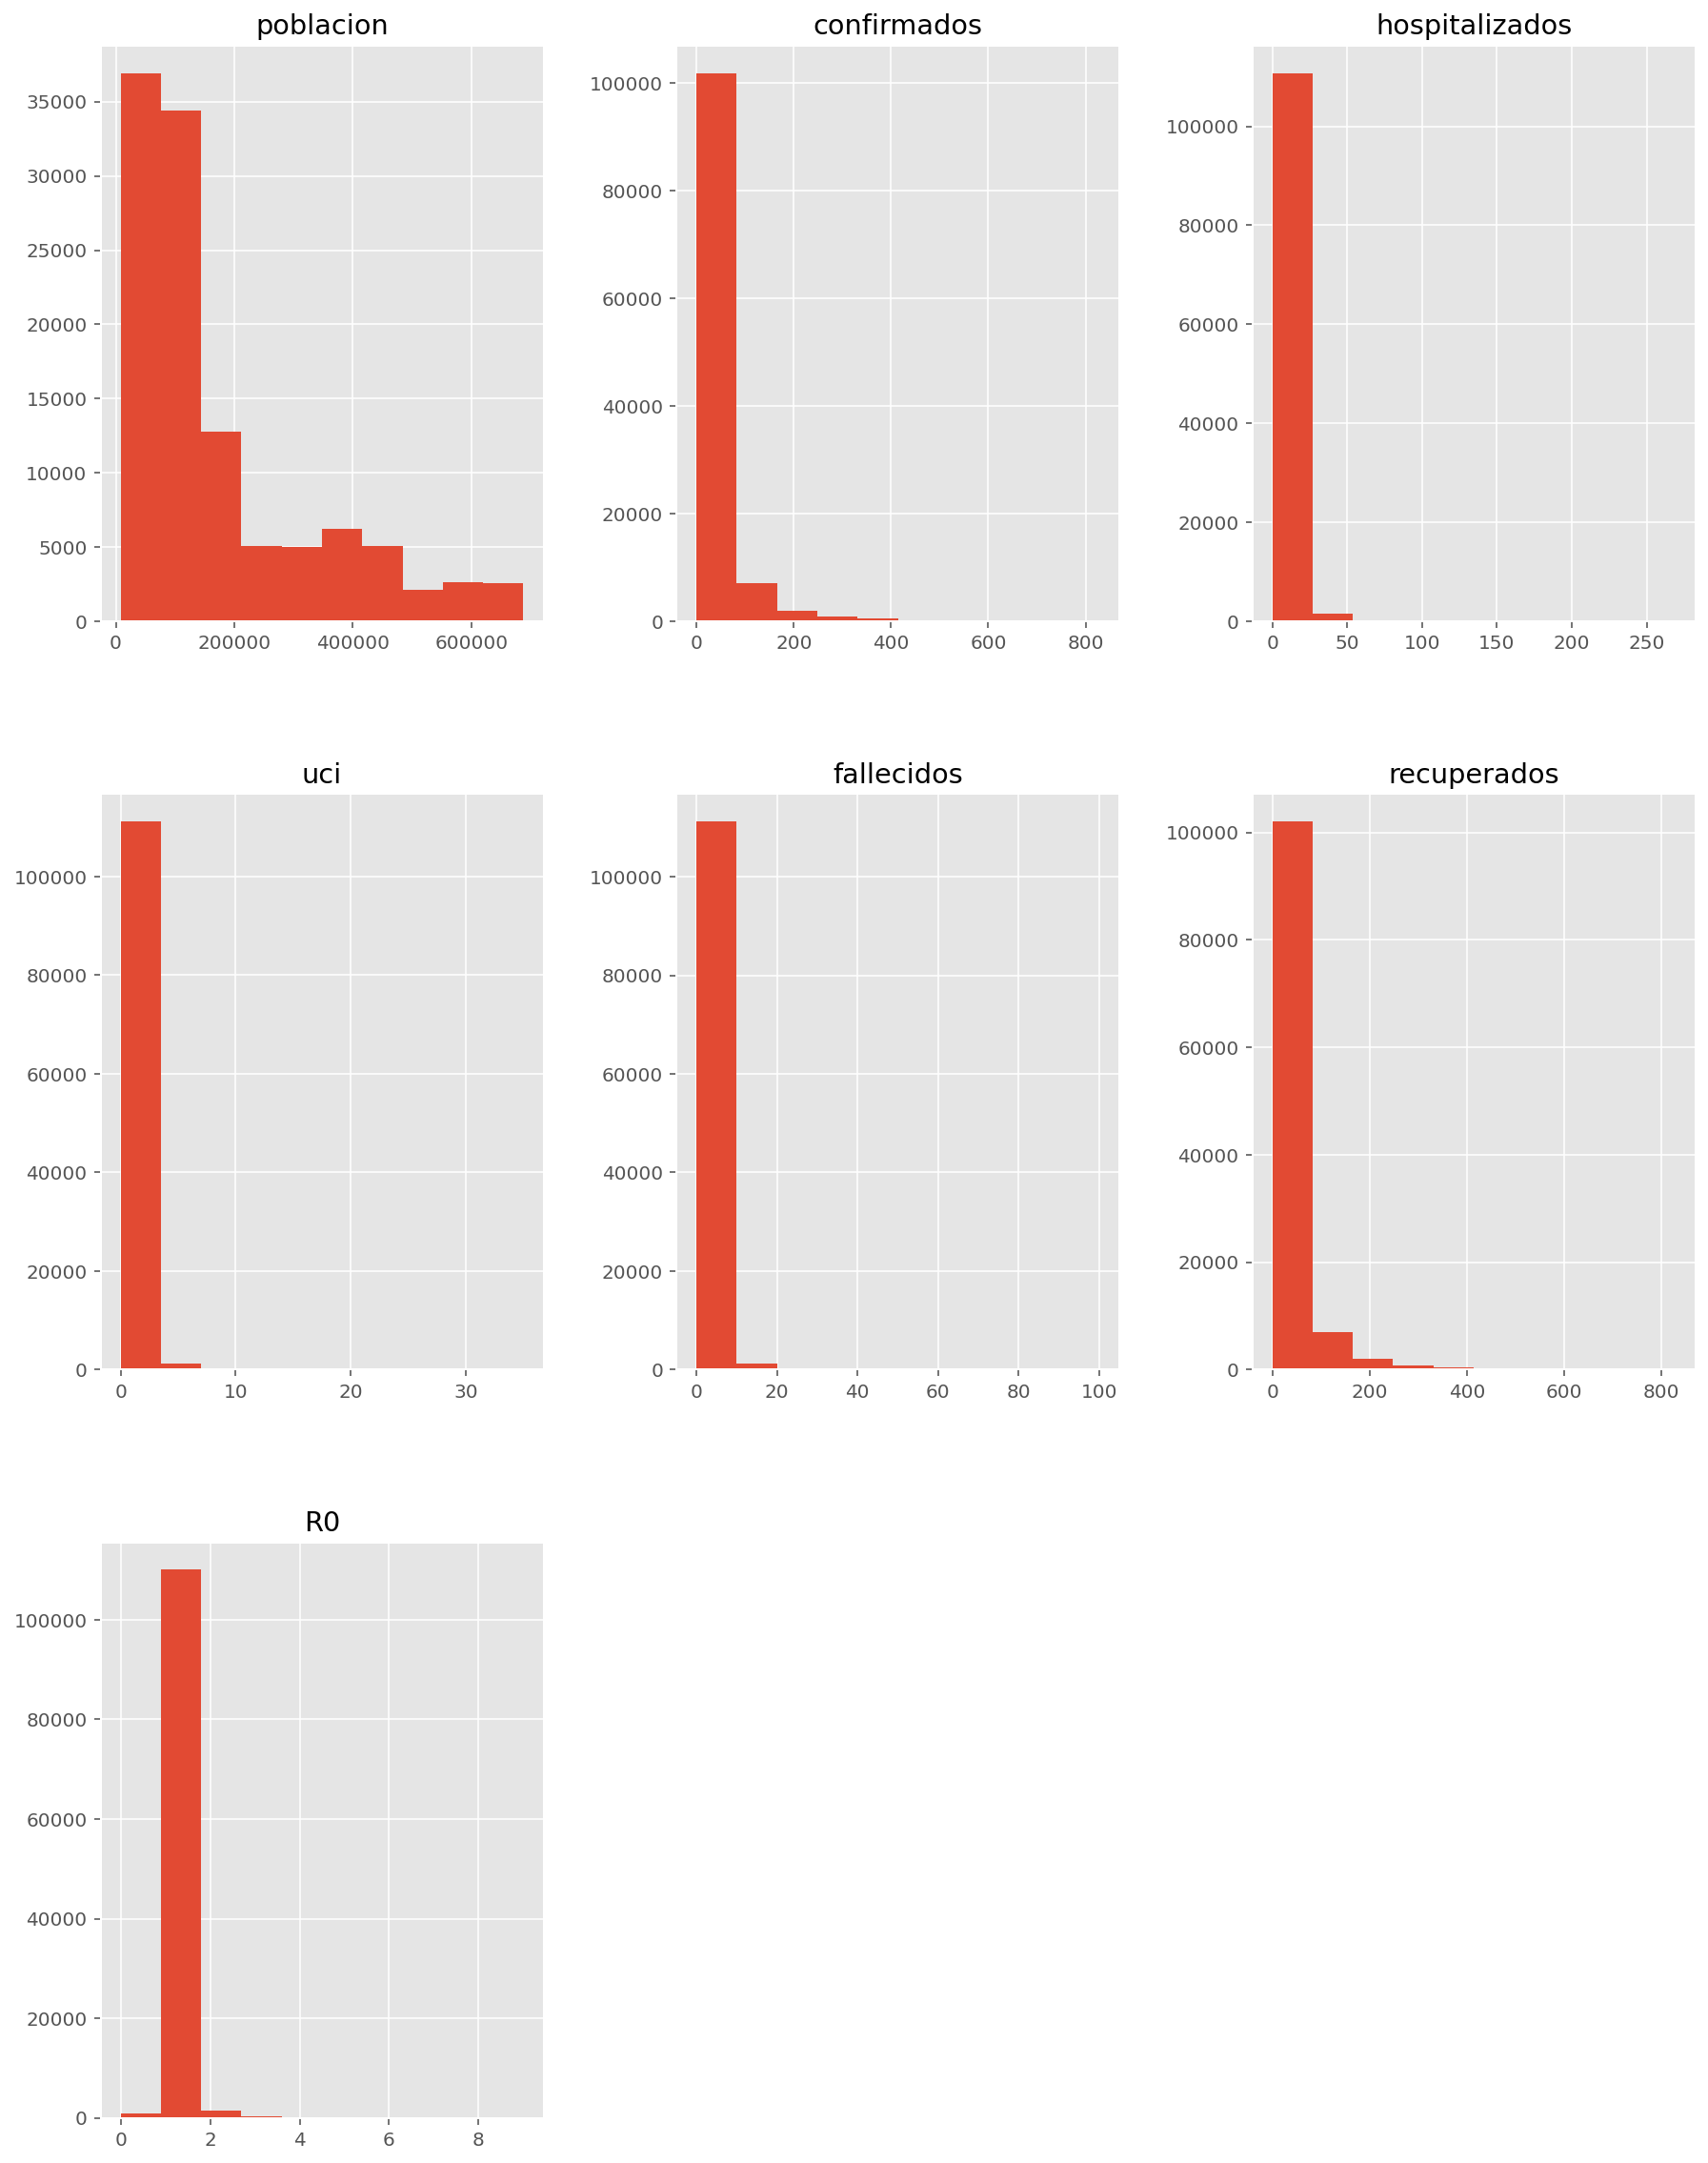

In [12]:
# HISTOGRAMA
fig = plt.figure(figsize = (15,20))
ax = fig.gca()
bd_epidem.hist(ax = ax)


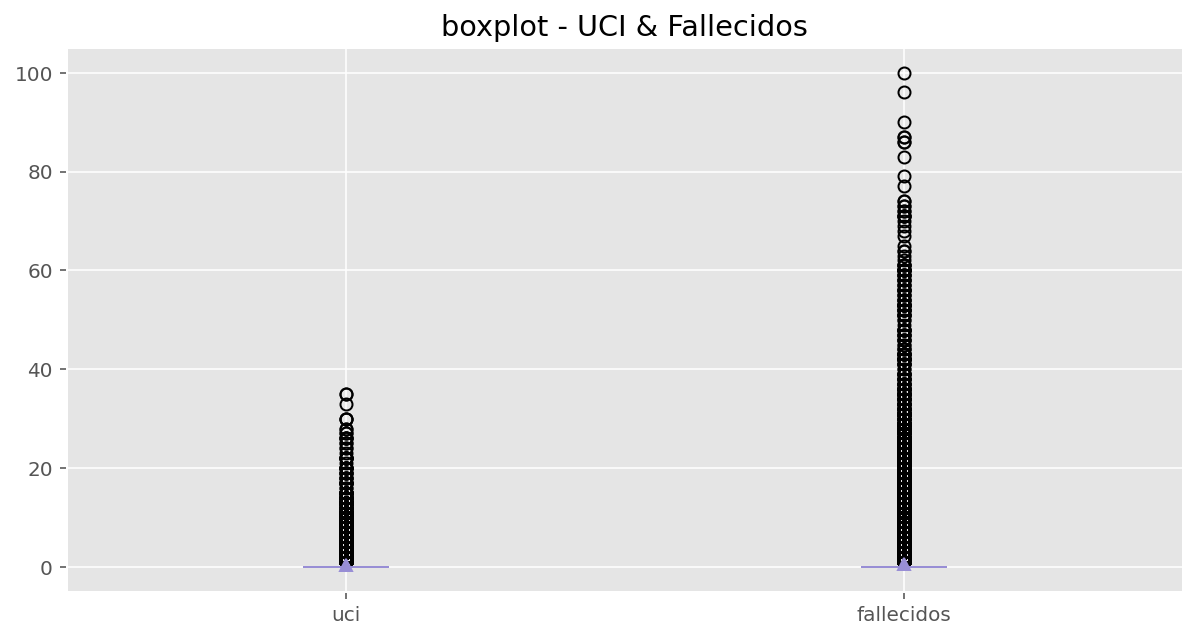

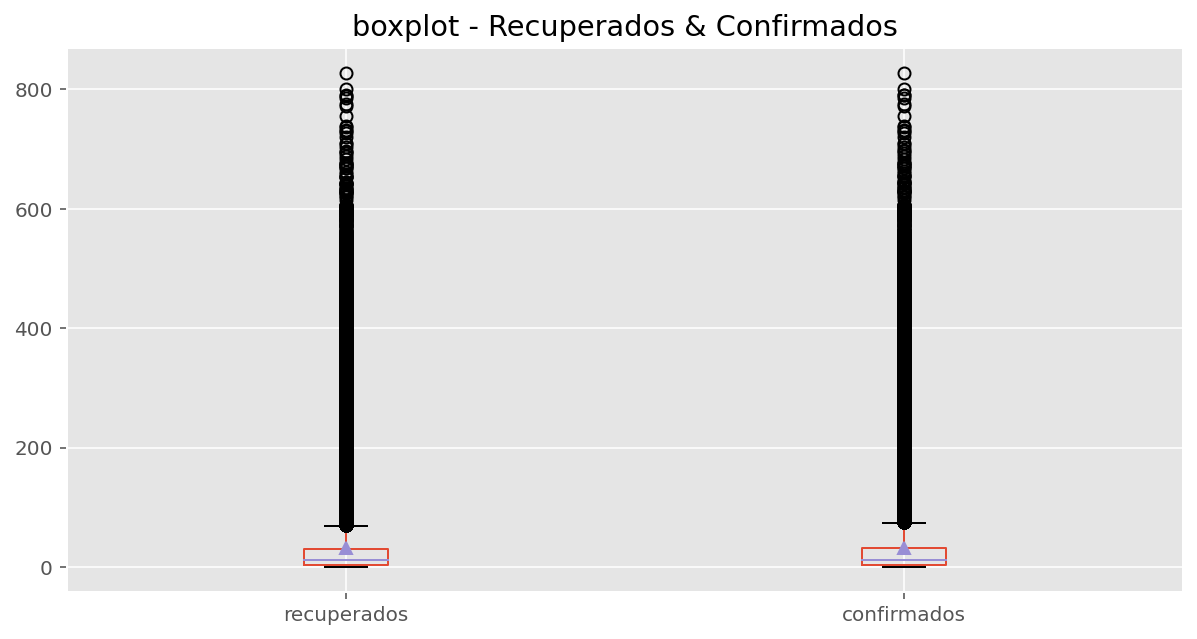

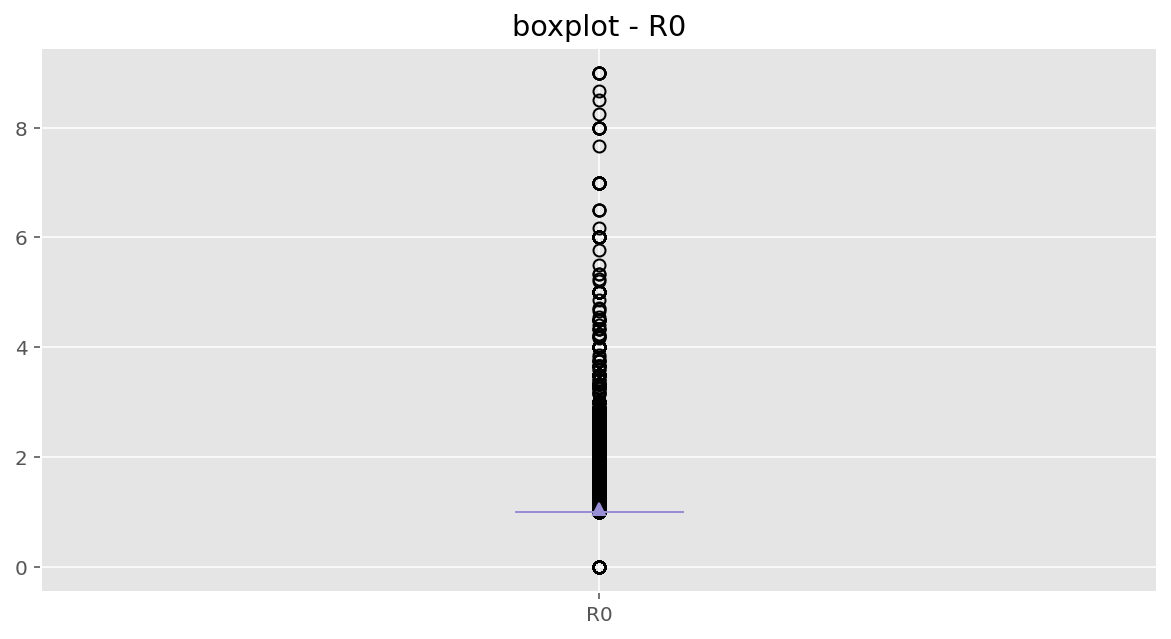

In [13]:
# BOXPLOT

ax = bd_epidem[['uci','fallecidos']].plot(kind='box', title='boxplot - UCI & Fallecidos', showmeans=True, figsize=(10, 5))
plt.show()


ax = bd_epidem[['recuperados','confirmados']].plot(kind='box', title='boxplot - Recuperados & Confirmados', showmeans=True, figsize=(10, 5))
plt.show()


# BOXPLOT
ax = bd_epidem[['R0']].plot(kind='box', title='boxplot - R0', showmeans=True, figsize=(10, 5))
plt.show()

In [14]:
bd_epidem_atipicos = bd_epidem
def atipicos(bd_epidem,Columnas):
  for c in Columnas:
    IQR=np.percentile(bd_epidem[c],75)-np.percentile(bd_epidem[c],25)
    M=np.mean(bd_epidem[c])
    CEINF=M-3*IQR
    CESUP=M+3*IQR
    bd_epidem['Atipicos_Cerc_'+c]=(bd_epidem[c]<CEINF)|(bd_epidem[c]>CESUP)
    bd_epidem['Atipicos_Perc_'+c]=(bd_epidem[c]<np.percentile(bd_epidem[c],1))|(bd_epidem[c]>np.percentile(bd_epidem[c],99))
atipicos(bd_epidem_atipicos,['poblacion','confirmados', 'hospitalizados', 'uci', 'fallecidos', 'recuperados', 'R0'])

In [15]:
def PROC_FREQ(bd_epidem,columnas):
  for c in columnas:
    x=bd_epidem[c].value_counts().to_frame()
    nombre=x.columns.tolist()[0]
    x.rename(columns={nombre:'Freq'},inplace=True)
    x['Pct']=x['Freq']/x.Freq.sum()
    x['Freq Acum'],x['Pct Acum']=x.Freq.cumsum(),x.Pct.cumsum()
    x.sort_values(['Freq'],ascending=[0],inplace=True)
    print('Tabla de distribución de frecuencias para la variable: '+nombre)
    print('\n')
    print(x)
    print('\n')

cols = [c for c in bd_epidem_atipicos.columns if 'Atipicos' in c]
PROC_FREQ(bd_epidem_atipicos,cols)

Tabla de distribución de frecuencias para la variable: Atipicos_Cerc_poblacion


         Freq       Pct  Freq Acum  Pct Acum
False  111580  0.988641     111580  0.988641
True     1282  0.011359     112862  1.000000


Tabla de distribución de frecuencias para la variable: Atipicos_Perc_poblacion


         Freq       Pct  Freq Acum  Pct Acum
False  110926  0.982846     110926  0.982846
True     1936  0.017154     112862  1.000000


Tabla de distribución de frecuencias para la variable: Atipicos_Cerc_confirmados


         Freq       Pct  Freq Acum  Pct Acum
False  105835  0.937738     105835  0.937738
True     7027  0.062262     112862  1.000000


Tabla de distribución de frecuencias para la variable: Atipicos_Perc_confirmados


         Freq       Pct  Freq Acum  Pct Acum
False  110897  0.982589     110897  0.982589
True     1965  0.017411     112862  1.000000


Tabla de distribución de frecuencias para la variable: Atipicos_Cerc_hospitalizados


         Freq       Pct  Freq Acum  Pc

Text(0, 0.5, 'Conteo')

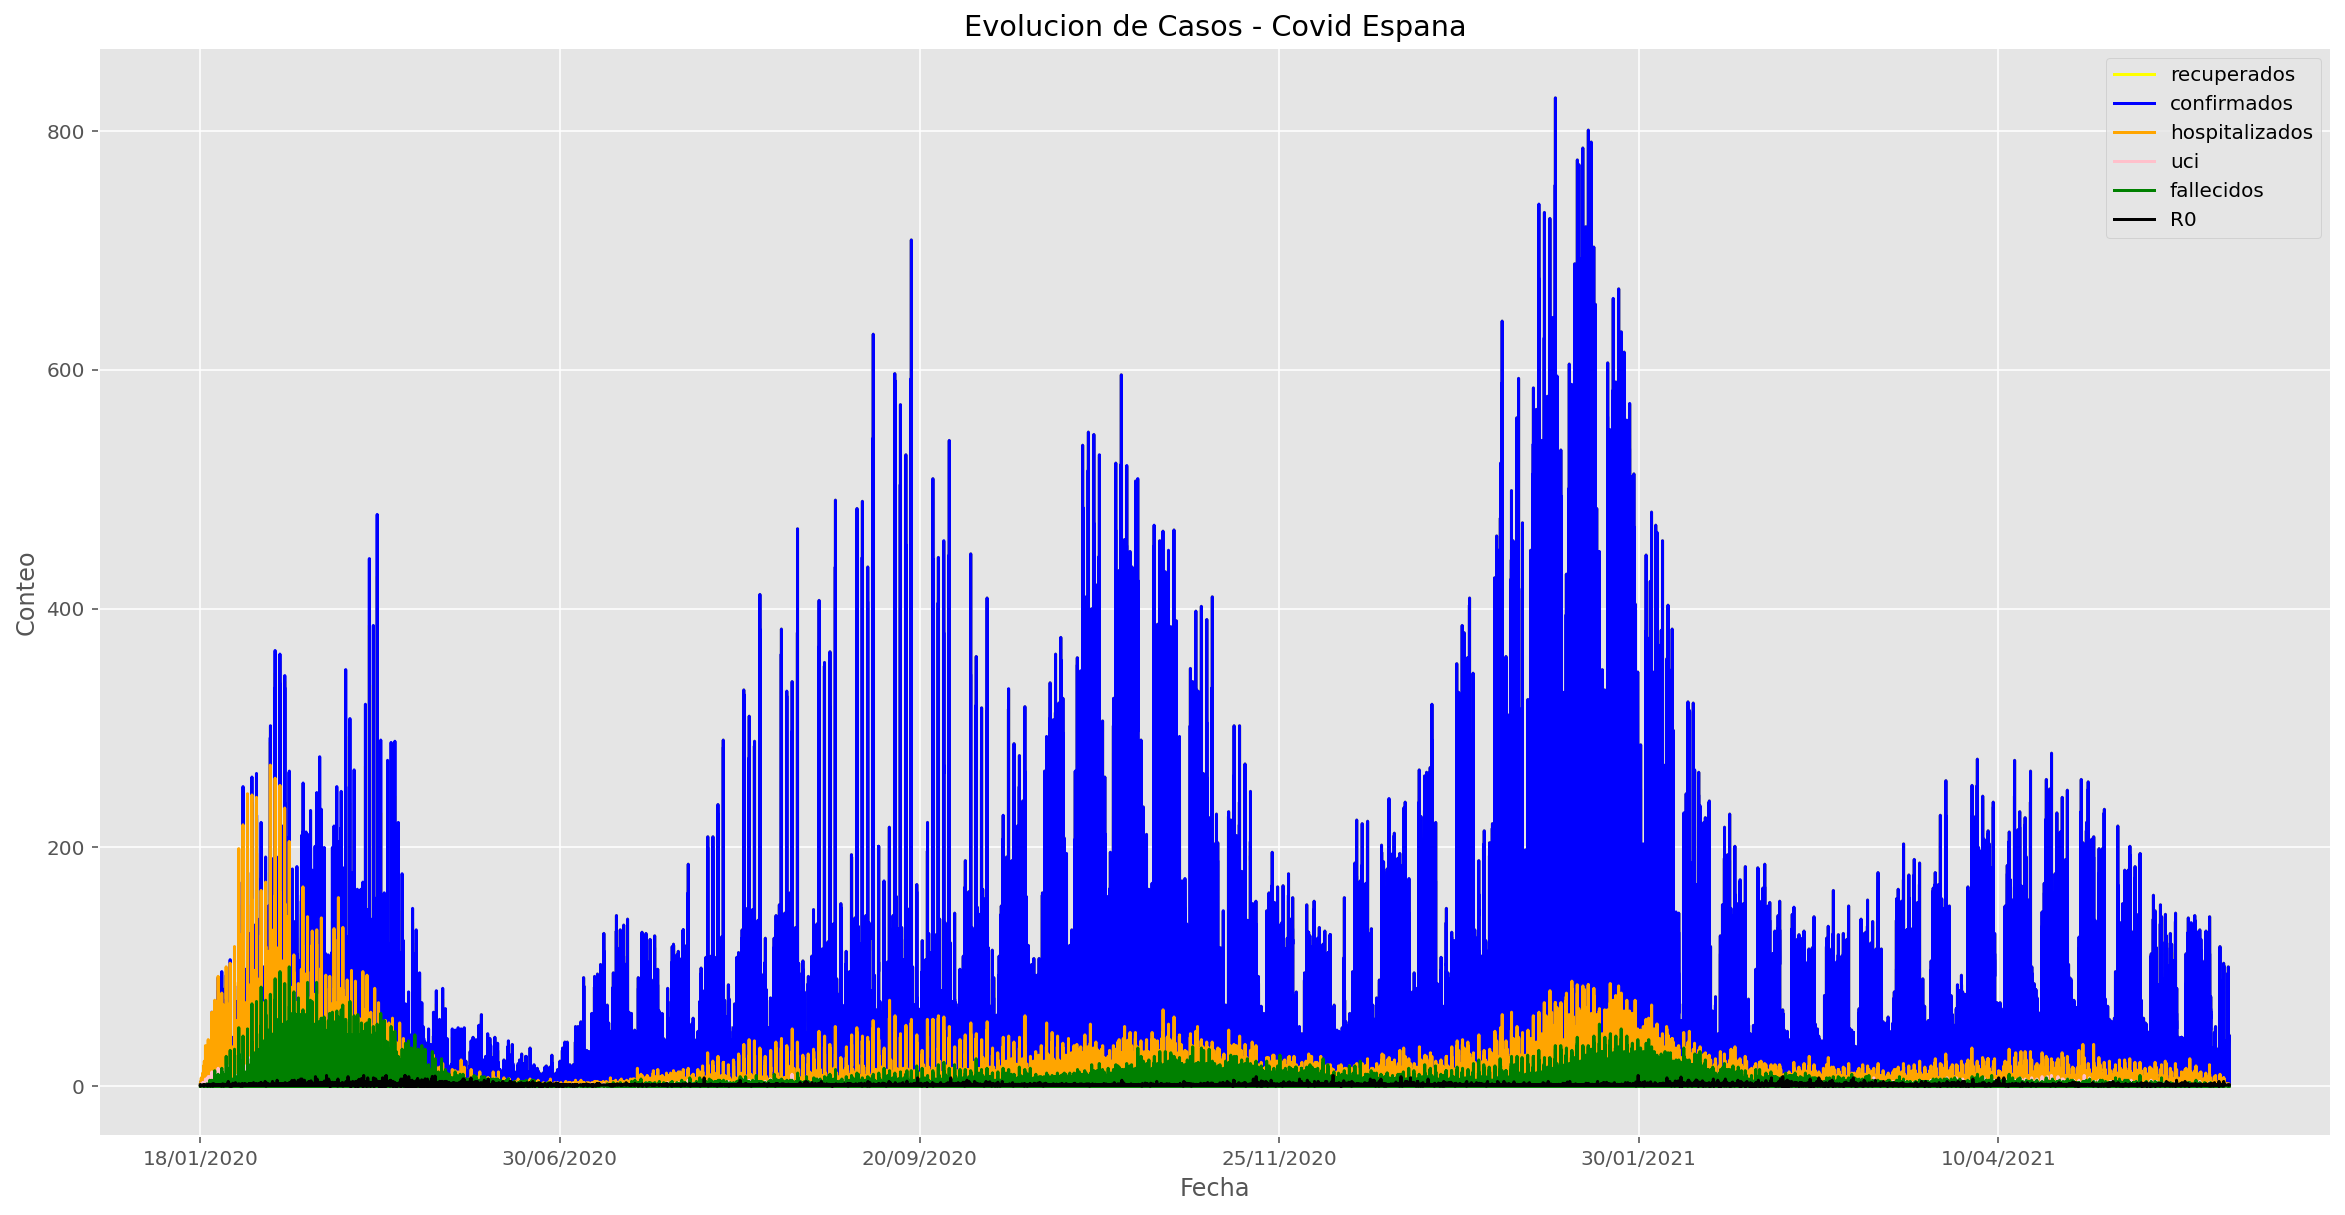

In [16]:
style.use('ggplot')
ax = plt.gca()
bd_epidem.plot.line(x='fecha', y='recuperados', color='yellow', ax=ax)
bd_epidem.plot.line(x='fecha', y='confirmados', color='blue', ax=ax, figsize=(20, 10))
bd_epidem.plot.line(x='fecha', y='hospitalizados', color='orange', ax=ax)
bd_epidem.plot.line(x='fecha', y='uci', color='pink', ax=ax)
bd_epidem.plot.line(x='fecha', y='fallecidos', color='green', ax=ax)
bd_epidem.plot.line(x='fecha', y='R0', color='black', ax=ax)
plt.title('Evolucion de Casos - Covid Espana')
plt.xlabel('Fecha')
plt.ylabel('Conteo')

In [17]:
#Creamos un dataframe para cada variable epidemiológica 
bd_conf = bd_epidem[['ccaa','poblacion','recuperados', 'R0', 'confirmados']].copy()
bd_conf = bd_conf.fillna(0)

bd_hos = bd_epidem[['ccaa','poblacion','recuperados', 'R0','hospitalizados']].copy()
bd_hos = bd_hos.fillna(0)

bd_uci = bd_epidem[['ccaa','poblacion','recuperados', 'R0', 'uci']].copy()
bd_uci = bd_uci.fillna(0)

bd_fal = bd_epidem[['ccaa','poblacion','recuperados', 'R0', 'fallecidos']].copy()
bd_fal = bd_fal.fillna(0)

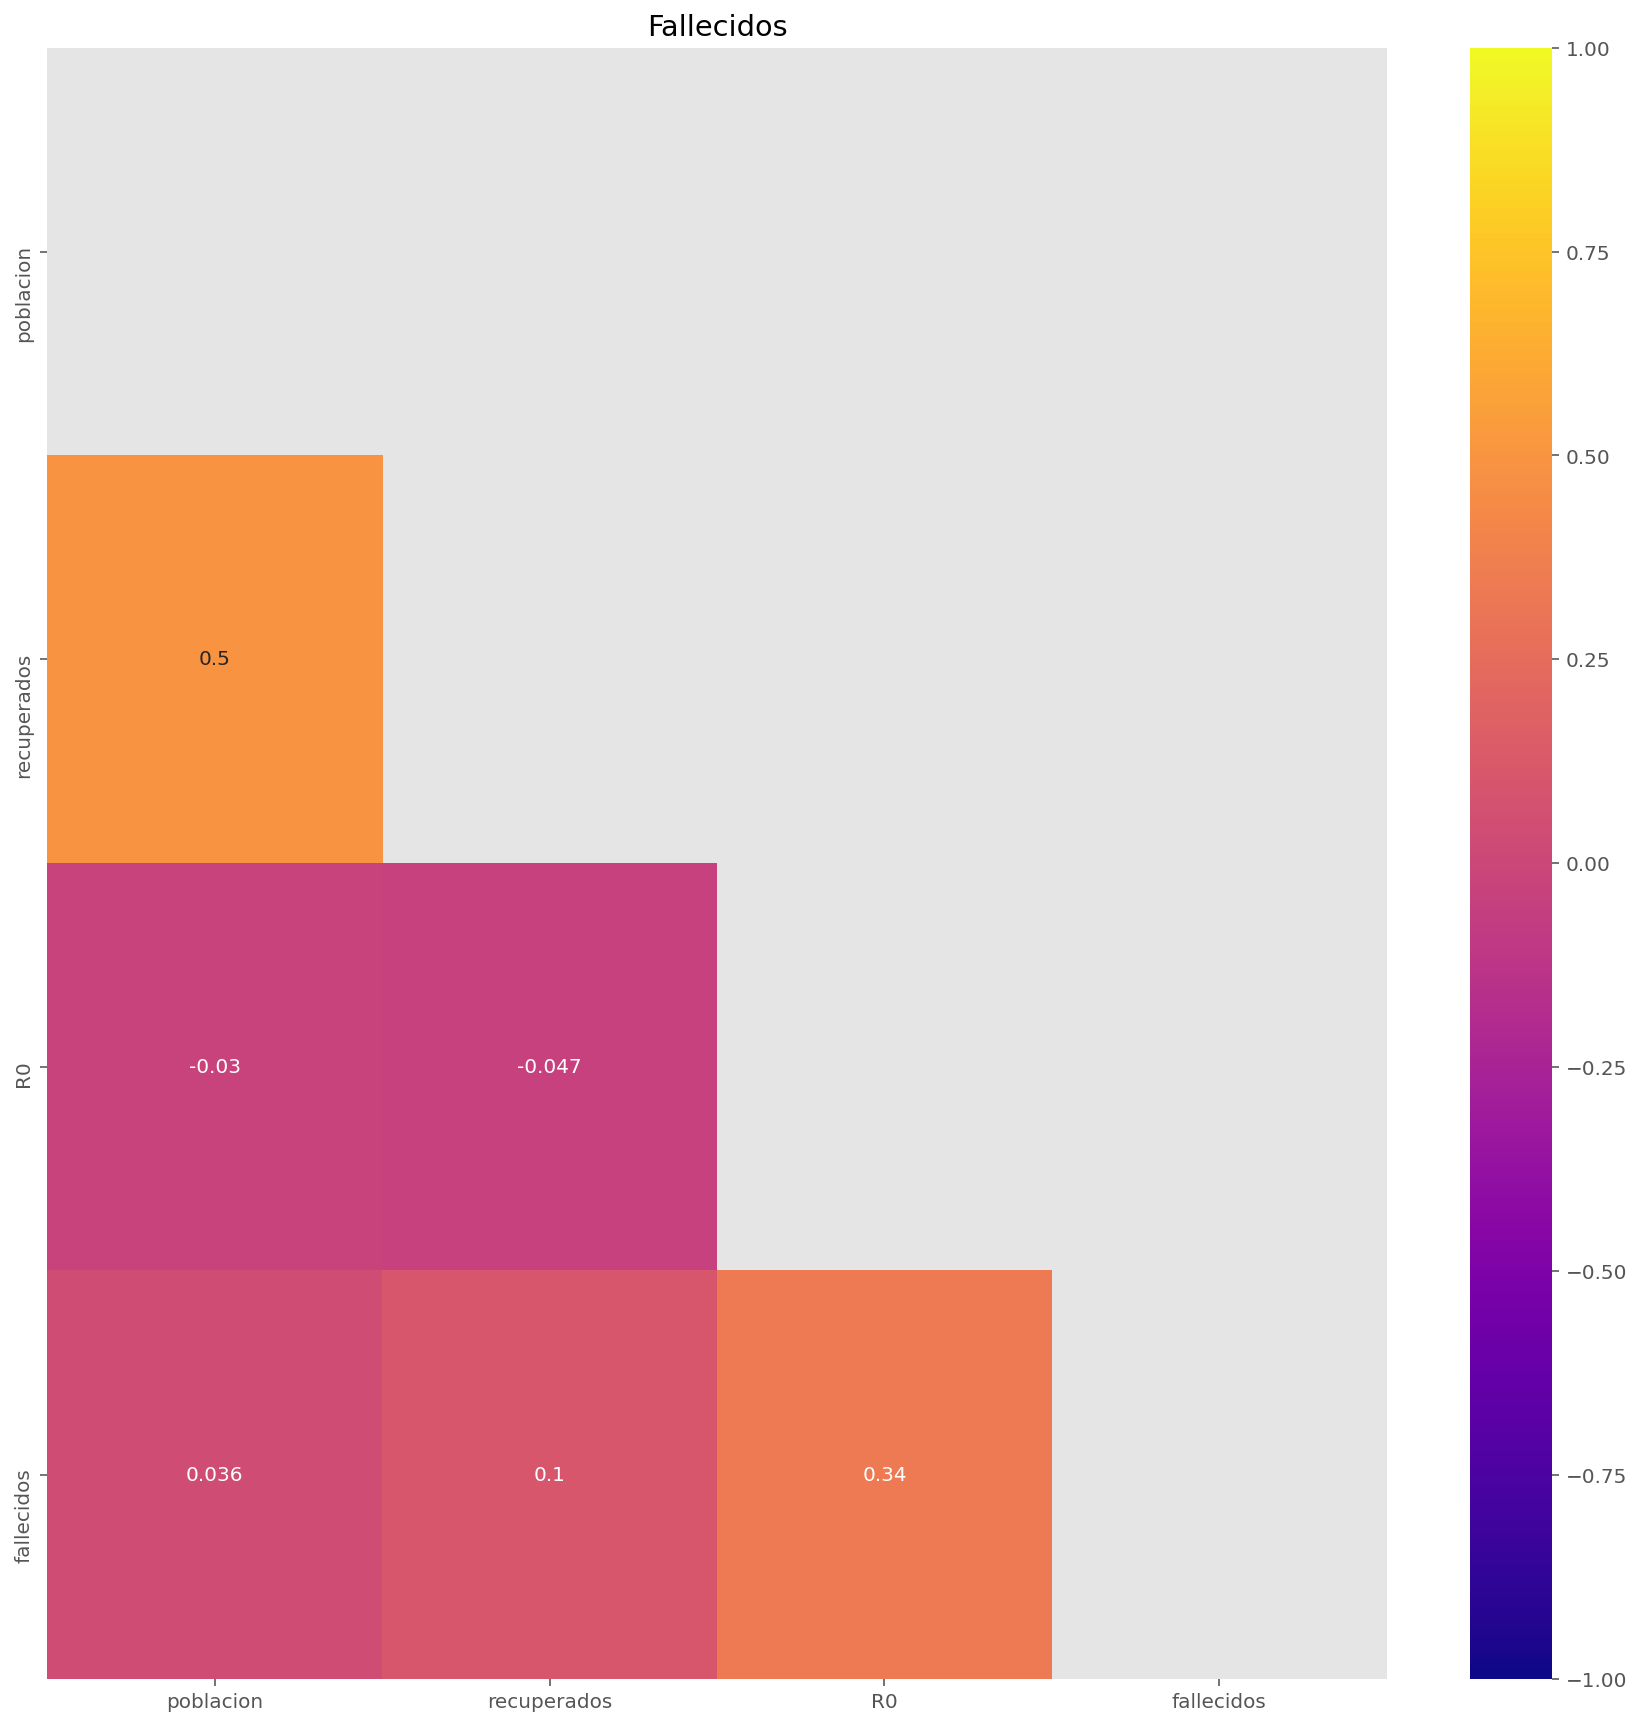

In [18]:
#MATRIZ DE CORRELACIONES - FALLECIDOS
colormap = plt.cm.plasma
matrix1 = np.triu(bd_fal.corr())
plt.figure(figsize=(15, 15))
sns.heatmap(bd_fal.corr(), annot=True, vmax=1, vmin=-1, mask=matrix1, cmap=colormap)
plt.title("Fallecidos")
plt.show()

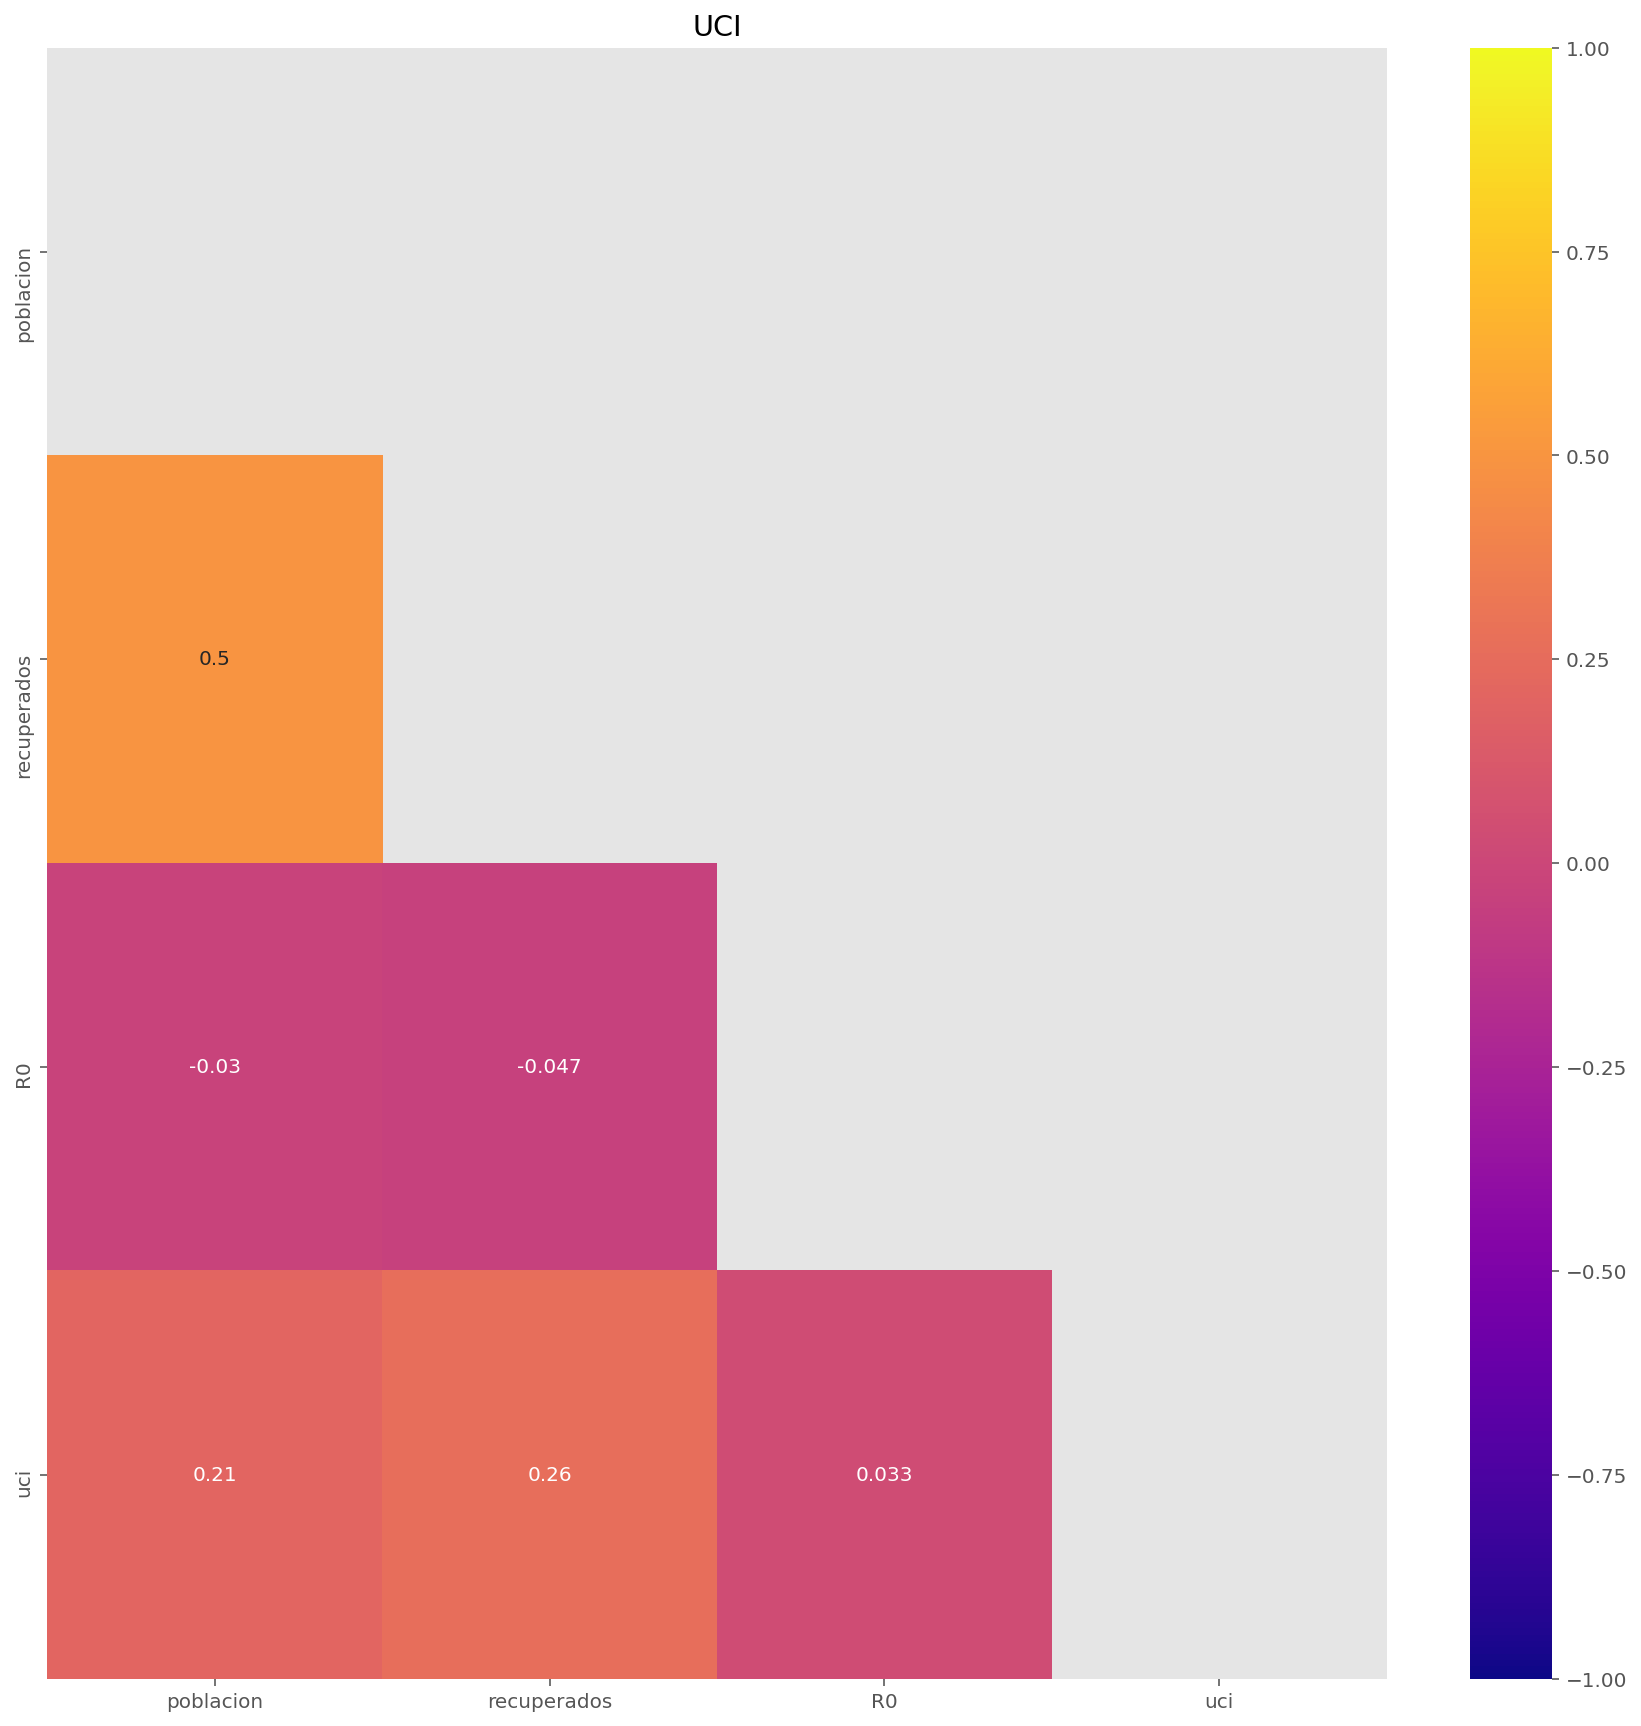

In [19]:
#MATRIZ DE CORRELACIONES  UCI
colormap = plt.cm.plasma
matrix1 = np.triu(bd_uci.corr())
plt.figure(figsize=(15, 15))
sns.heatmap(bd_uci.corr(), annot=True, vmax=1, vmin=-1, mask=matrix1, cmap=colormap)
plt.title("UCI")
plt.show()

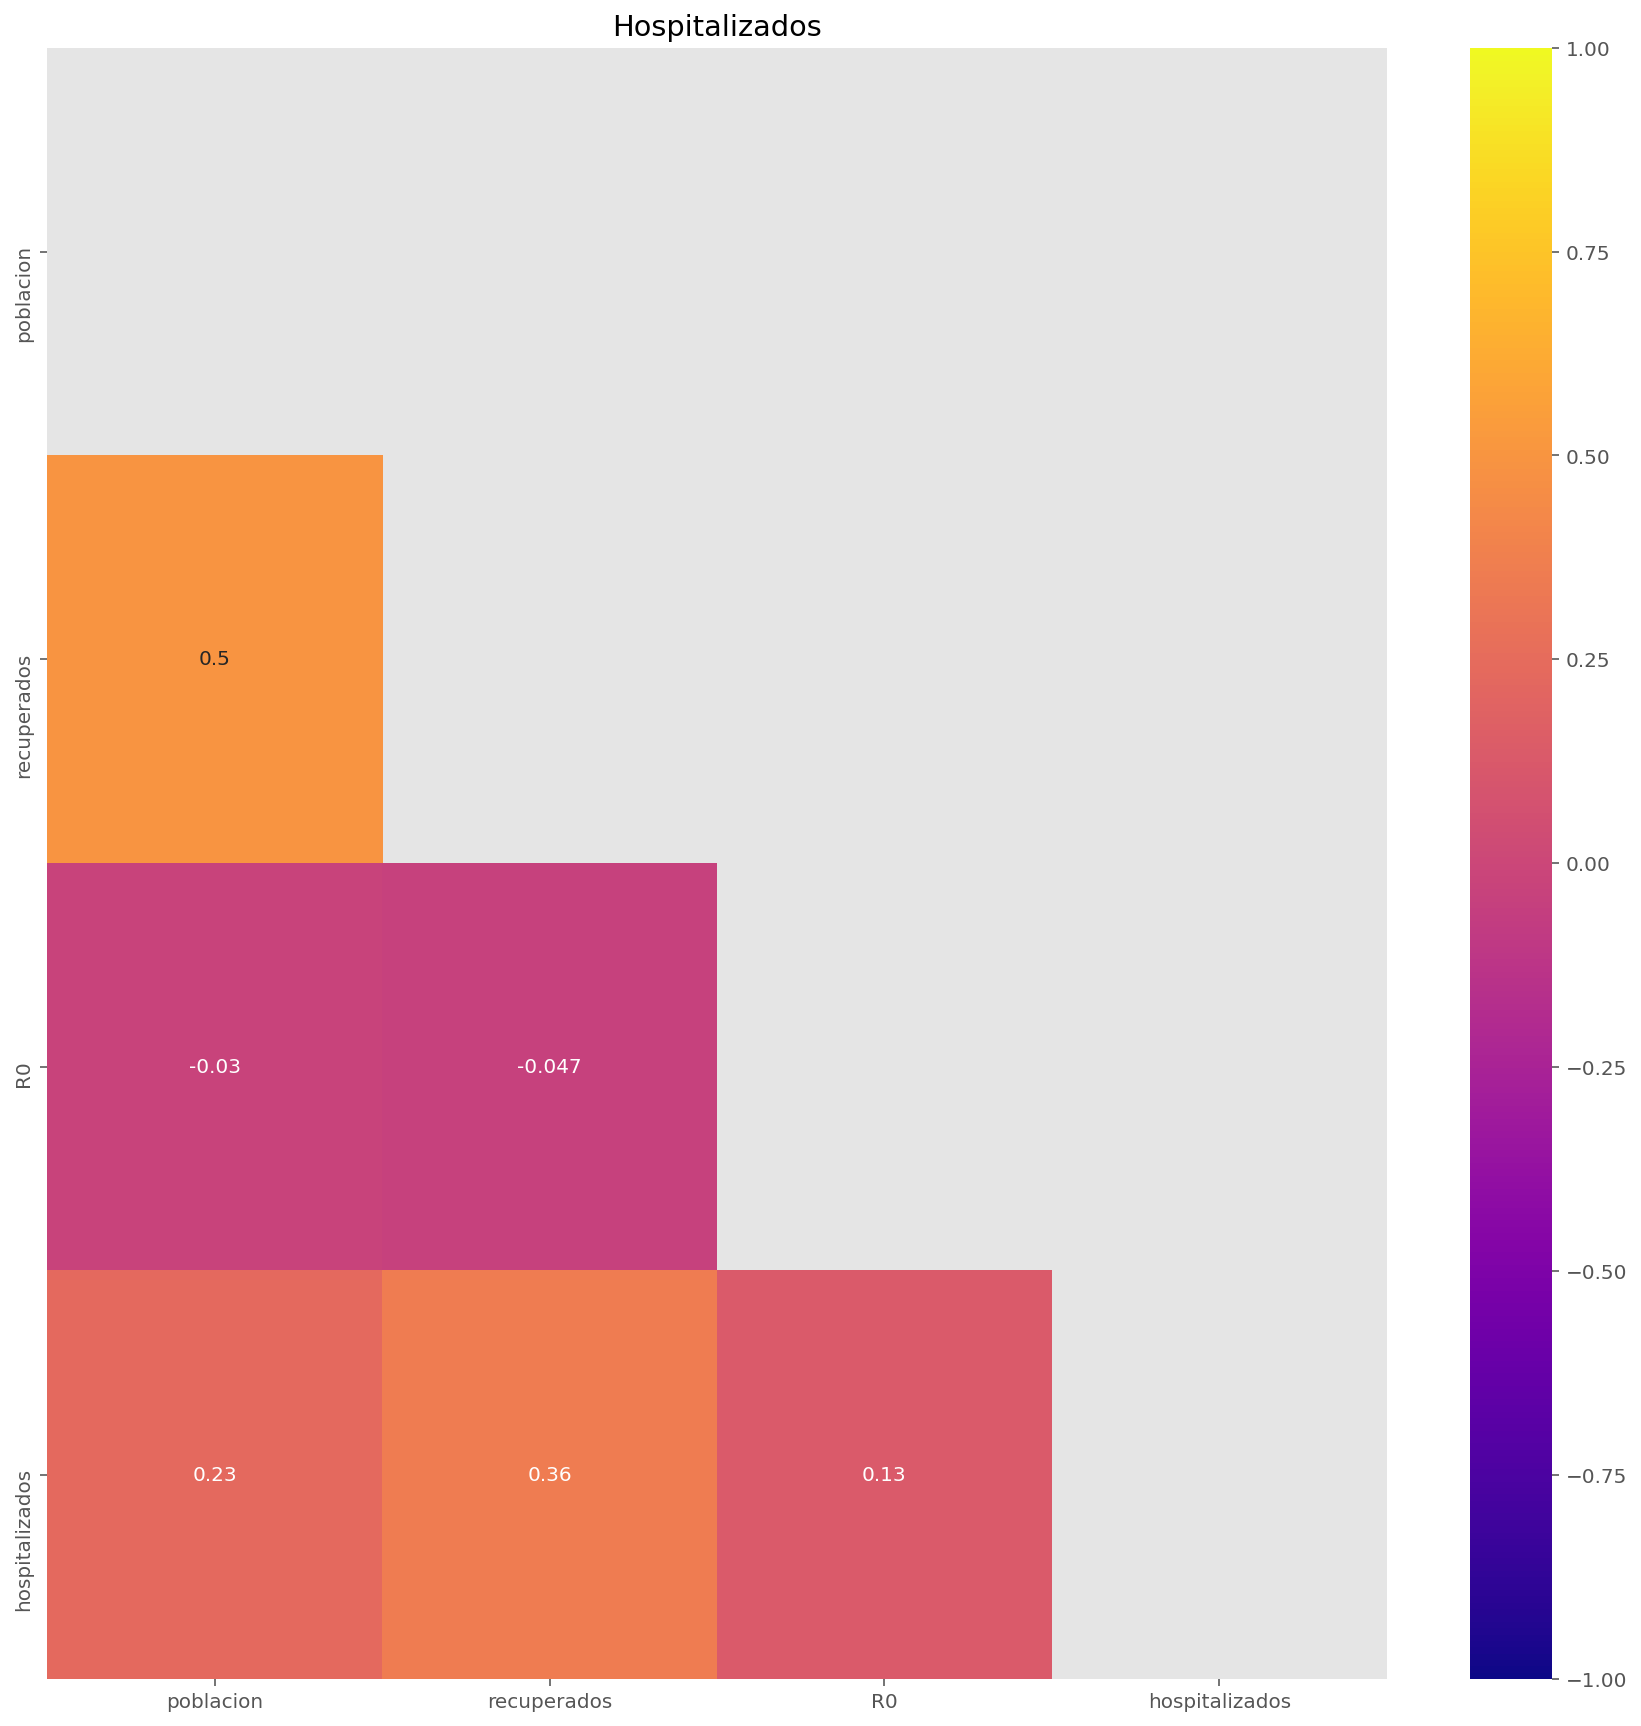

In [20]:
#MATRIZ DE CORRELACIONES - HOSPITALIZADOS

colormap = plt.cm.plasma
matrix1 = np.triu(bd_hos.corr())
plt.figure(figsize=(15, 15))
sns.heatmap(bd_hos.corr(), annot=True, vmax=1, vmin=-1, mask=matrix1, cmap=colormap)
plt.title("Hospitalizados")
plt.show()

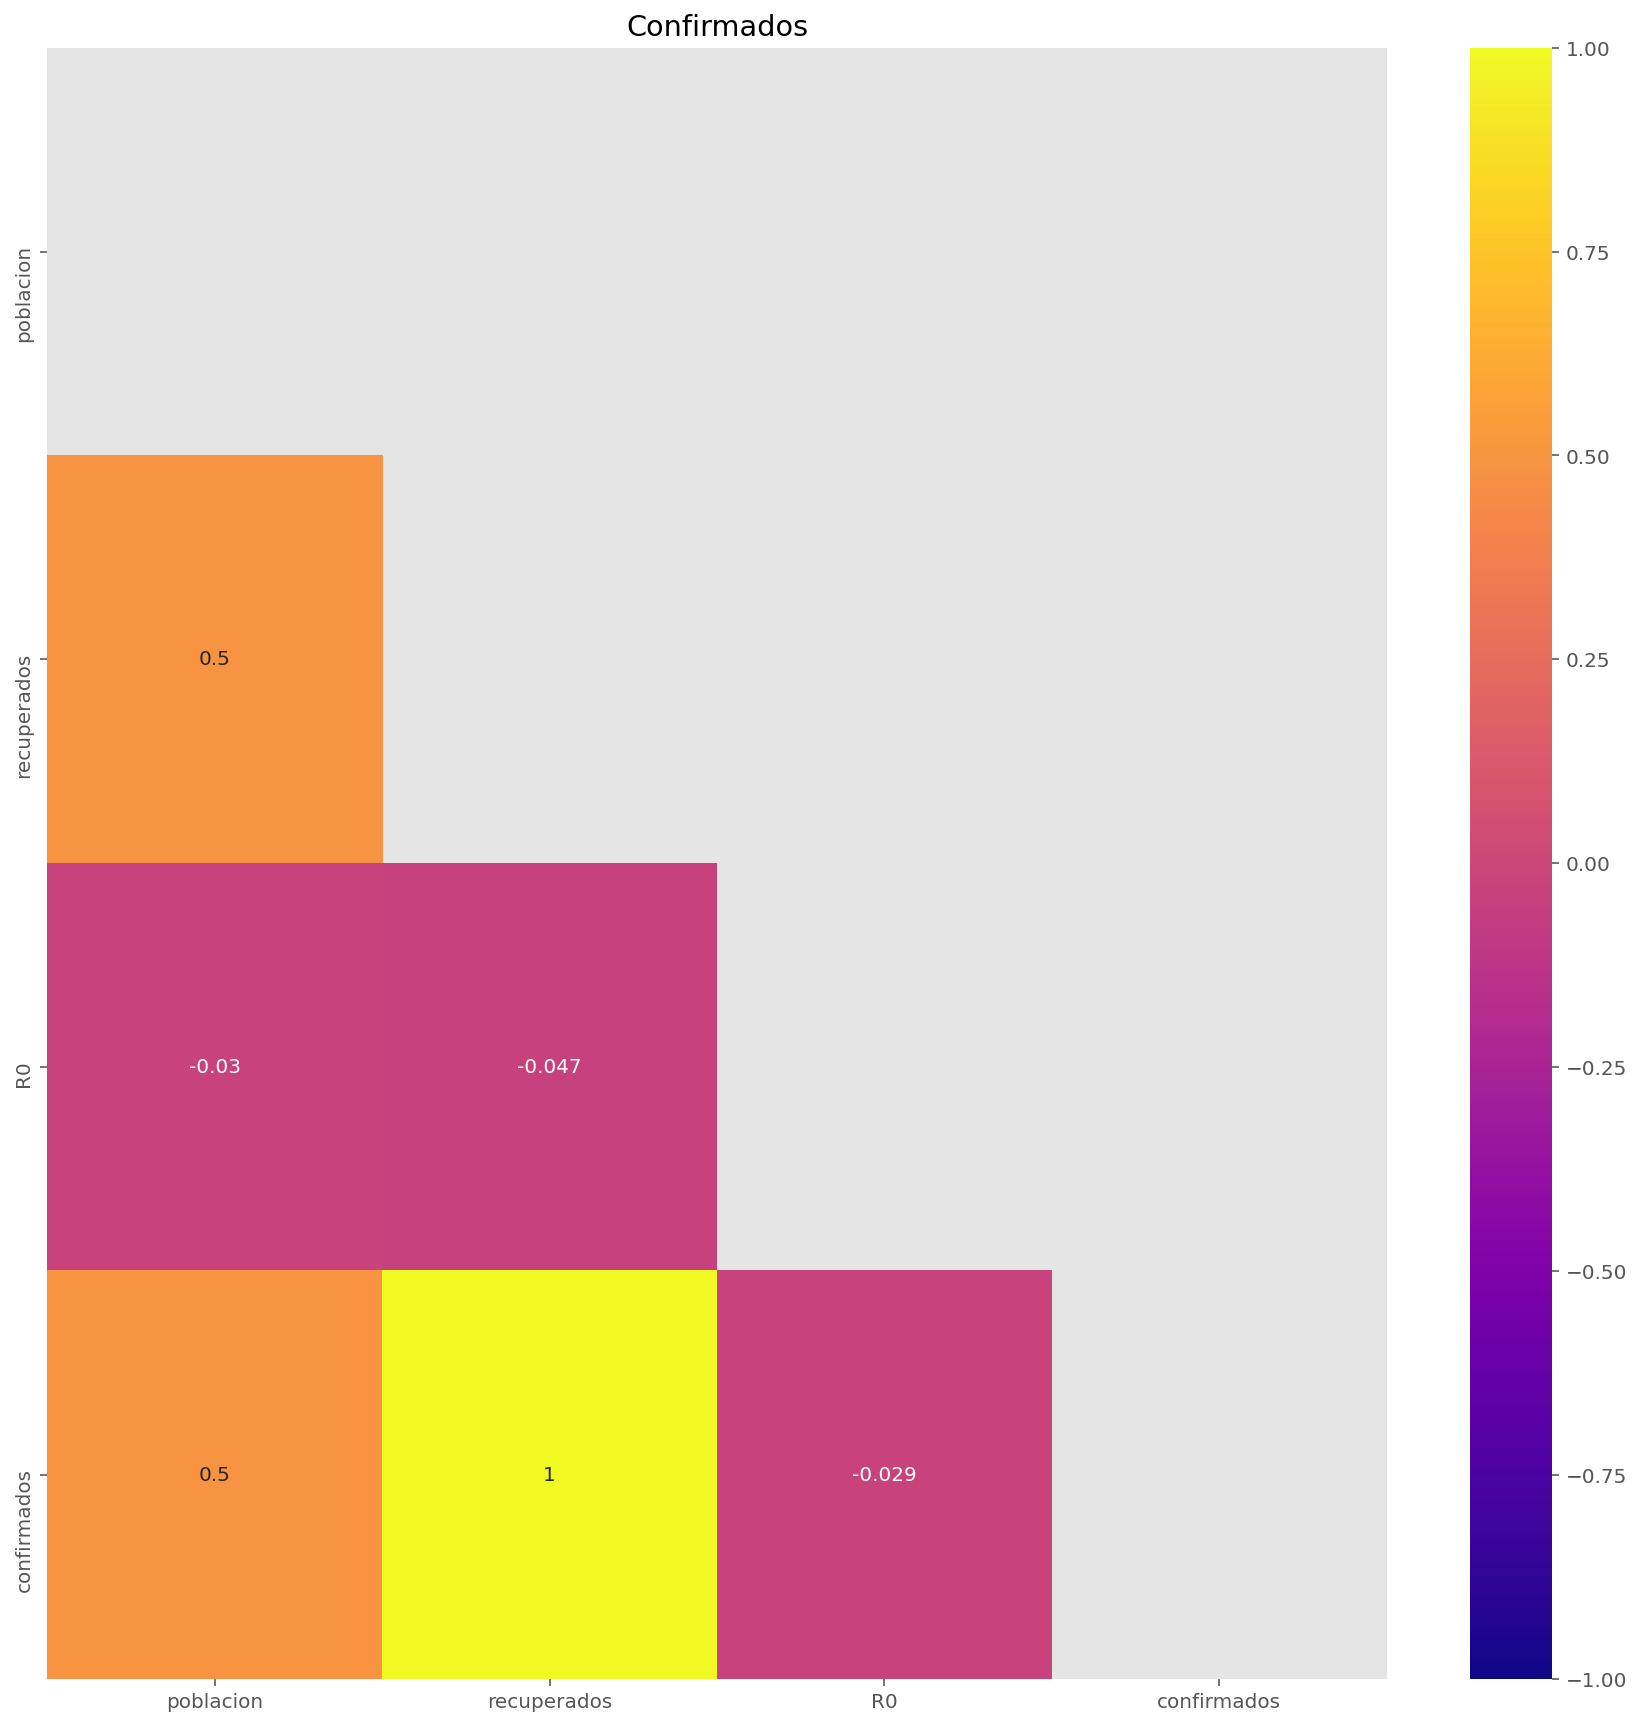

In [21]:
# MATRIZ DE CORRELACIONES - CONFIRMADOS
colormap = plt.cm.plasma
matrix1 = np.triu(bd_conf.corr())
plt.figure(figsize=(15, 15))
sns.heatmap(bd_conf.corr(), annot=True, vmax=1, vmin=-1, mask=matrix1, cmap=colormap)
plt.title("Confirmados")
plt.show()

In [23]:
# ANALISE DE 'CONFIRMADOS'
# agrupacion 
bd_conf_sc=['poblacion','recuperados', 'R0', 'confirmados']

if len(bd_conf_sc)==0:
    data_conf=bd_conf.select_dtypes(include='float')
else:
    data_conf=bd_conf[bd_conf_sc]
data_conf=pd.concat([data_conf,bd_conf[['ccaa']]],axis=1)
data_conf=data_conf.groupby('ccaa').mean().reset_index()
data_conf.fillna(0,inplace=True)

In [24]:
# ANALISE DE 'UCI'
# agrupacion 
bd_uci_sc=['poblacion','recuperados', 'R0', 'uci']

if len(bd_uci_sc)==0:
    data_uci=bd_uci.select_dtypes(include='float')
else:
    data_uci=bd_uci[bd_uci_sc]
data_uci=pd.concat([data_uci,bd_uci[['ccaa']]],axis=1)
data_uci=data_uci.groupby('ccaa').mean().reset_index()
data_uci.fillna(0,inplace=True)

In [25]:
# ANALISE DE 'HOSPITALIZADOS'
# agrupacion 
bd_hos_sc=['poblacion','recuperados', 'R0', 'hospitalizados']

if len(bd_hos_sc)==0:
    data_hos=bd_hos.select_dtypes(include='float')
else:
    data_hos=bd_hos[bd_hos_sc]
data_hos=pd.concat([data_hos,bd_hos[['ccaa']]],axis=1)
data_hos=data_hos.groupby('ccaa').mean().reset_index()
data_hos.fillna(0,inplace=True)

In [26]:
# ANALISE DE 'FALLECIDOS'
# agrupacion 
bd_fal_sc=['poblacion','recuperados', 'R0', 'fallecidos']

if len(bd_fal_sc)==0:
    data_fal=bd_fal.select_dtypes(include='float')
else:
    data_fal=bd_fal[bd_fal_sc]
data_fal=pd.concat([data_fal,bd_fal[['ccaa']]],axis=1)
data_fal=data_fal.groupby('ccaa').mean().reset_index()
data_fal.fillna(0,inplace=True)

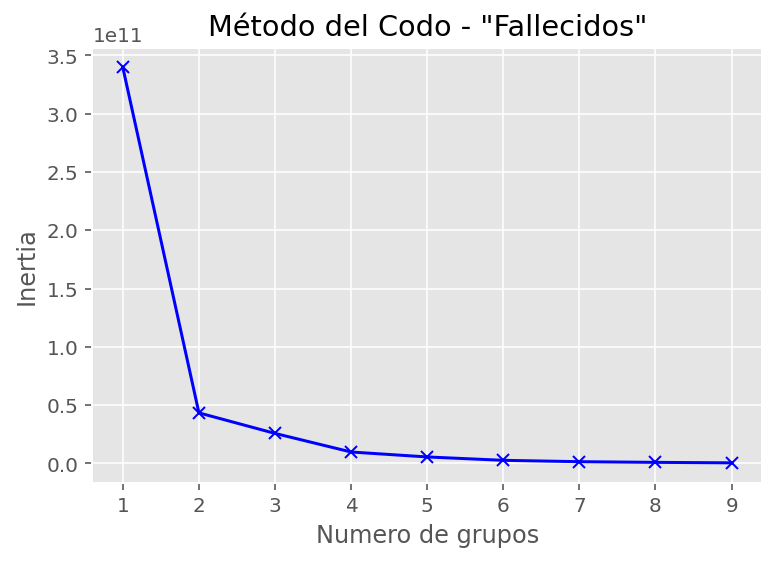

In [266]:
#ANALISIS CLUSTER - FALLECIDOS

inertias = [] 
K = range(1,10) 
  
for k in K: 
    #Building and fitting the model 
    kmeanModel = KMeans(n_clusters=k).fit(data_fal.drop(['ccaa'],axis=1)) 
    kmeanModel.fit(data_fal.drop(['ccaa'],axis=1))     
    inertias.append(kmeanModel.inertia_) 
    
plt.plot(K, inertias, 'bx-') 
plt.xlabel('Numero de grupos') 
plt.ylabel('Inertia') 
plt.title('Método del Codo - "Fallecidos"') 
plt.show()

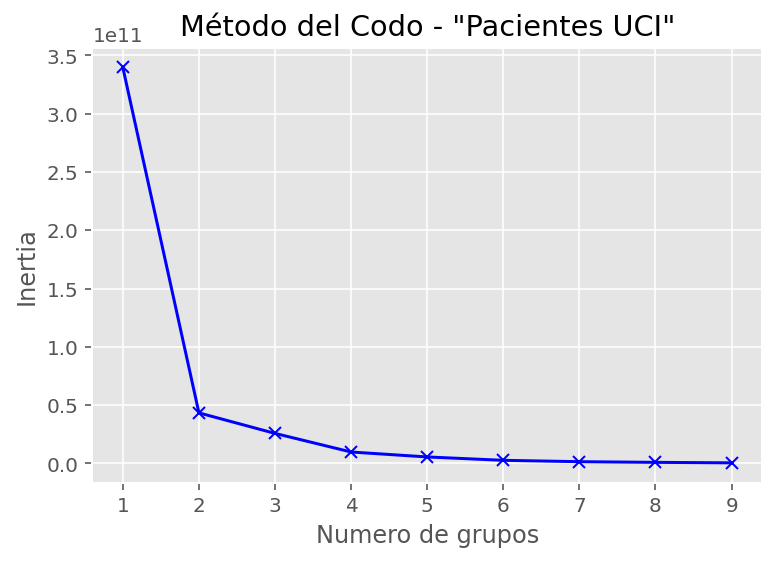

In [267]:
#ANALISIS CLUSTER - UCI

inertias = [] 
K = range(1,10) 
  
for k in K: 
    #Building and fitting the model 
    kmeanModel = KMeans(n_clusters=k).fit(data_uci.drop(['ccaa'],axis=1)) 
    kmeanModel.fit(data_uci.drop(['ccaa'],axis=1))     
    inertias.append(kmeanModel.inertia_) 
    
plt.plot(K, inertias, 'bx-') 
plt.xlabel('Numero de grupos') 
plt.ylabel('Inertia') 
plt.title('Método del Codo - "Pacientes UCI"') 
plt.show()

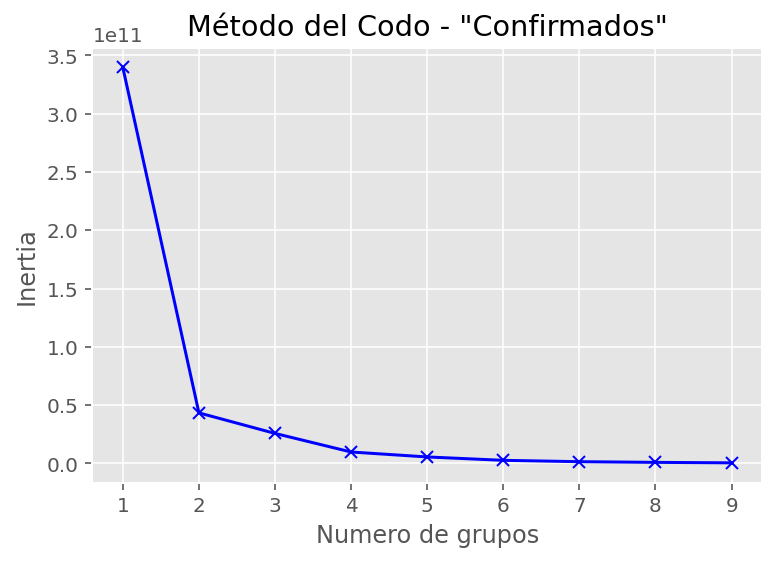

In [268]:
#ANALISIS CLUSTER - Confirmados

inertias = [] 
K = range(1,10) 
  
for k in K: 
    #Building and fitting the model 
    kmeanModel = KMeans(n_clusters=k).fit(data_conf.drop(['ccaa'],axis=1)) 
    kmeanModel.fit(data_conf.drop(['ccaa'],axis=1))     
    inertias.append(kmeanModel.inertia_) 
    
plt.plot(K, inertias, 'bx-') 
plt.xlabel('Numero de grupos') 
plt.ylabel('Inertia') 
plt.title('Método del Codo - "Confirmados"') 
plt.show()

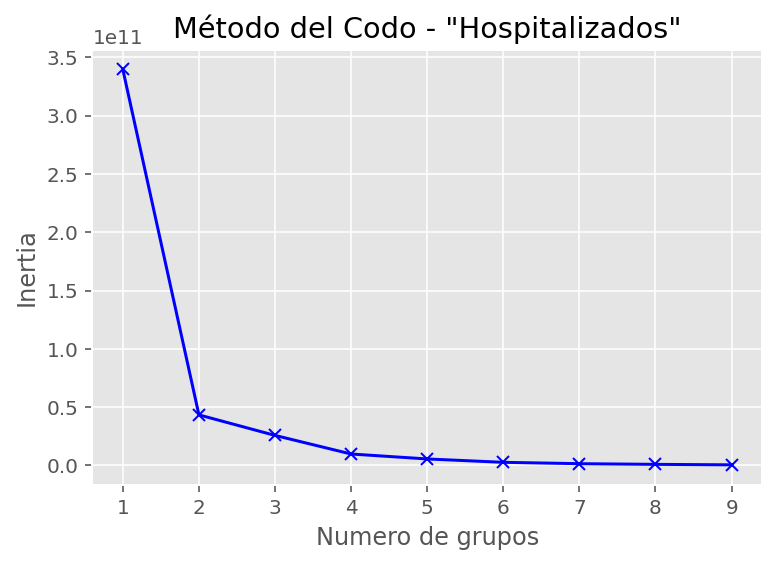

In [269]:
#ANALISIS CLUSTER - Hospitalizados

inertias = [] 
K = range(1,10) 
  
for k in K: 
    #Building and fitting the model 
    kmeanModel = KMeans(n_clusters=k).fit(data_hos.drop(['ccaa'],axis=1)) 
    kmeanModel.fit(data_hos.drop(['ccaa'],axis=1))     
    inertias.append(kmeanModel.inertia_) 
    
plt.plot(K, inertias, 'bx-') 
plt.xlabel('Numero de grupos') 
plt.ylabel('Inertia') 
plt.title('Método del Codo - "Hospitalizados"') 
plt.show()

In [270]:
# FALLECIDOS
# ajustado el algoritmo Kmeans ak conjunto de datos
from sklearn.cluster import KMeans

## Numero de clústers a utilizar. En este caso 2 clústers
kmeans = KMeans(n_clusters = 2, init = 'k-means++', random_state = 42)
y_kmeans = kmeans.fit_predict(data_fal.drop(['ccaa'],axis=1))
y_kmeans1=y_kmeans+1
cluster = pd.DataFrame(y_kmeans1)
today_sub=data_fal.drop(['ccaa'],axis=1)
# Adding cluster to the Dataset
today_sub['cluster'] = cluster
#Mean of clusters
kmeans_mean_cluster = pd.DataFrame(round(today_sub.groupby('cluster').mean(),1))

## Identificación de los valores promedio ( centroides) 
kmeans_mean_cluster

,poblacion,recuperados,R0,fallecidos
cluster,,,,
1,83231.7,14.9,1.0,0.3
2,394457.6,74.4,1.1,1.5


In [32]:
# UCI
# ajustado el algoritmo Kmeans ak conjunto de datos
from sklearn.cluster import KMeans

## Numero de clústers a utilizar. En este caso 2 clústers
kmeans = KMeans(n_clusters = 2, init = 'k-means++', random_state = 42)
y_kmeans = kmeans.fit_predict(data_uci.drop(['ccaa'],axis=1))
y_kmeans1=y_kmeans+1
cluster = pd.DataFrame(y_kmeans1)
today_sub2=data_uci.drop(['ccaa'],axis=1)
# Adding cluster to the Dataset
today_sub2['cluster'] = cluster
#Mean of clusters
kmeans_mean_cluster = pd.DataFrame(round(today_sub2.groupby('cluster').mean(),1))

## Identificación de los valores promedio ( centroides) 
kmeans_mean_cluster

,poblacion,recuperados,R0,uci
cluster,,,,
1,83231.7,14.9,1.0,0.2
2,394457.6,74.4,1.1,0.6


In [33]:
# Confirmados
# ajustado el algoritmo Kmeans ak conjunto de datos
from sklearn.cluster import KMeans

## Numero de clústers a utilizar. En este caso 2 clústers
kmeans = KMeans(n_clusters = 2, init = 'k-means++', random_state = 42)
y_kmeans = kmeans.fit_predict(data_conf.drop(['ccaa'],axis=1))
y_kmeans1=y_kmeans+1
cluster = pd.DataFrame(y_kmeans1)
today_sub3=data_conf.drop(['ccaa'],axis=1)
# Adding cluster to the Dataset
today_sub3['cluster'] = cluster
#Mean of clusters
kmeans_mean_cluster = pd.DataFrame(round(today_sub3.groupby('cluster').mean(),1))

## Identificación de los valores promedio ( centroides) 
kmeans_mean_cluster

,poblacion,recuperados,R0,confirmados
cluster,,,,
1,83231.7,14.9,1.0,15.2
2,394457.6,74.4,1.1,75.9


In [34]:
# Hospitalizados
# ajustado el algoritmo Kmeans ak conjunto de datos
from sklearn.cluster import KMeans

## Numero de clústers a utilizar. En este caso 2 clústers
kmeans = KMeans(n_clusters = 2, init = 'k-means++', random_state = 42)
y_kmeans = kmeans.fit_predict(data_hos.drop(['ccaa'],axis=1))
y_kmeans1=y_kmeans+1
cluster = pd.DataFrame(y_kmeans1)
today_sub4=data_hos.drop(['ccaa'],axis=1)
# Adding cluster to the Dataset
today_sub4['cluster'] = cluster
#Mean of clusters
kmeans_mean_cluster = pd.DataFrame(round(today_sub4.groupby('cluster').mean(),1))

## Identificación de los valores promedio ( centroides) 
kmeans_mean_cluster

,poblacion,recuperados,R0,hospitalizados
cluster,,,,
1,83231.7,14.9,1.0,1.5
2,394457.6,74.4,1.1,7.3


In [35]:
grupo_fal=pd.concat([data_fal[['ccaa']],today_sub],axis=1)
grupo_fal.head(5)

,ccaa,poblacion,recuperados,R0,fallecidos,cluster
0,Andalucía,481776.738418,78.916725,1.063132,1.340238,2
1,Aragón,72338.124017,16.223573,1.058860,0.431698,1
2,Asturias,57695.259206,8.265162,1.029158,0.291336,1
3,Canarias,123939.400363,8.912993,1.028721,0.103186,1
4,Cantabria,33214.729451,5.176810,1.015737,0.074676,1


In [36]:
grupo_uci=pd.concat([data_uci[['ccaa']],today_sub2],axis=1)
grupo_uci.head(5)

,ccaa,poblacion,recuperados,R0,uci,cluster
0,Andalucía,481776.738418,78.916725,1.063132,0.719384,2
1,Aragón,72338.124017,16.223573,1.058860,0.165642,1
2,Asturias,57695.259206,8.265162,1.029158,0.118773,1
3,Canarias,123939.400363,8.912993,1.028721,0.178636,1
4,Cantabria,33214.729451,5.176810,1.015737,0.077125,1


In [37]:
grupo_conf=pd.concat([data_conf[['ccaa']],today_sub3],axis=1)
grupo_conf.head(5)

,ccaa,poblacion,recuperados,R0,confirmados,cluster
0,Andalucía,481776.738418,78.916725,1.063132,80.247446,2
1,Aragón,72338.124017,16.223573,1.058860,16.645687,1
2,Asturias,57695.259206,8.265162,1.029158,8.528159,1
3,Canarias,123939.400363,8.912993,1.028721,9.006109,1
4,Cantabria,33214.729451,5.176810,1.015737,5.242917,1


In [38]:
grupo_hos=pd.concat([data_hos[['ccaa']],today_sub4],axis=1)
grupo_hos.head(5)

,ccaa,poblacion,recuperados,R0,hospitalizados,cluster
0,Andalucía,481776.738418,78.916725,1.063132,6.445766,2
1,Aragón,72338.124017,16.223573,1.058860,1.718495,1
2,Asturias,57695.259206,8.265162,1.029158,1.354332,1
3,Canarias,123939.400363,8.912993,1.028721,0.816411,1
4,Cantabria,33214.729451,5.176810,1.015737,0.540923,1


In [39]:
# FALLECIDOS
for i in range(1,3):
    print('****Comunidades autónomas en el grupo {}*****'.format(str(i)))
    print(list(grupo_fal[grupo_fal.cluster==i]['ccaa'].values))

****Comunidades autónomas en el grupo 1*****
['Aragón', 'Asturias', 'Canarias', 'Cantabria', 'Castilla y León', 'Castilla-La Mancha', 'Extremadura', 'Galicia', 'Islas Baleares', 'La Rioja', 'Murcia', 'Navarra', 'País Vasco']
****Comunidades autónomas en el grupo 2*****
['Andalucía', 'Cataluña', 'Comunidad Valenciana', 'Madrid']


In [40]:
# UCI
for i in range(1,3):
    print('****Comunidades autónomas en el grupo {}*****'.format(str(i)))
    print(list(grupo_uci[grupo_uci.cluster==i]['ccaa'].values))

****Comunidades autónomas en el grupo 1*****
['Aragón', 'Asturias', 'Canarias', 'Cantabria', 'Castilla y León', 'Castilla-La Mancha', 'Extremadura', 'Galicia', 'Islas Baleares', 'La Rioja', 'Murcia', 'Navarra', 'País Vasco']
****Comunidades autónomas en el grupo 2*****
['Andalucía', 'Cataluña', 'Comunidad Valenciana', 'Madrid']


In [41]:
# Confirmados
for i in range(1,3):
    print('****Comunidades autónomas en el grupo {}*****'.format(str(i)))
    print(list(grupo_conf[grupo_conf.cluster==i]['ccaa'].values))

****Comunidades autónomas en el grupo 1*****
['Aragón', 'Asturias', 'Canarias', 'Cantabria', 'Castilla y León', 'Castilla-La Mancha', 'Extremadura', 'Galicia', 'Islas Baleares', 'La Rioja', 'Murcia', 'Navarra', 'País Vasco']
****Comunidades autónomas en el grupo 2*****
['Andalucía', 'Cataluña', 'Comunidad Valenciana', 'Madrid']


In [42]:
# Hospitalizados
for i in range(1,3):
    print('****Comunidades autónomas en el grupo {}*****'.format(str(i)))
    print(list(grupo_hos[grupo_hos.cluster==i]['ccaa'].values))

****Comunidades autónomas en el grupo 1*****
['Aragón', 'Asturias', 'Canarias', 'Cantabria', 'Castilla y León', 'Castilla-La Mancha', 'Extremadura', 'Galicia', 'Islas Baleares', 'La Rioja', 'Murcia', 'Navarra', 'País Vasco']
****Comunidades autónomas en el grupo 2*****
['Andalucía', 'Cataluña', 'Comunidad Valenciana', 'Madrid']


In [265]:
# CONFIRMADOS
fig = px.treemap(grupo_conf, path=['cluster','ccaa'], values='confirmados')
fig.update_layout(autosize=False,width=800,height=700)
fig.show()

In [44]:
# UCI
fig = px.treemap(grupo_uci, path=['cluster','ccaa'], values='uci')
fig.update_layout(autosize=False,width=800,height=700)
fig.show()

In [45]:
# HOSPITALIZADOS
fig = px.treemap(grupo_hos, path=['cluster','ccaa'], values='hospitalizados')
fig.update_layout(autosize=False,width=800,height=700)
fig.show()

In [46]:
# FALLECIDOS
fig = px.treemap(grupo_fal, path=['cluster','ccaa'], values='fallecidos')
fig.update_layout(autosize=False,width=800,height=700)
fig.show()

In [47]:
#MODELOS LINEALES

# Tratamiento de datos
# ==============================================================================
import pandas as pd
import numpy as np

# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns

# Preprocesado y modelado
# ==============================================================================
from scipy.stats import pearsonr
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.anova import anova_lm
from scipy import stats

# Configuración matplotlib
# ==============================================================================
plt.rcParams['image.cmap'] = "bwr"
#plt.rcParams['figure.dpi'] = "100"
plt.rcParams['savefig.bbox'] = "tight"
style.use('ggplot') or plt.style.use('ggplot')

# Configuración warnings
# ==============================================================================
import warnings
warnings.filterwarnings('ignore')



In [48]:
# MODELO LINEAL CONFIRMADOS

X = bd_conf.iloc[:,1:(len(bd_conf.columns)-1)]
y = bd_conf['confirmados'] 

X_train, X_test, y_train, y_test = train_test_split(
                                        X,
                                        y.values.reshape(-1,1),
                                        train_size   = 0.8,
                                        random_state = 1234,
                                        shuffle      = True
                                    )
X.head(5)

,poblacion,recuperados,R0
14107,589033,1,1.000002
23906,124436,1,1.000008
31432,107231,1,1.000009
33598,503828,1,1.000002
33908,513110,1,1.000002


In [49]:
X_train = sm.add_constant(X_train, prepend=True)
modelo = sm.OLS(endog=y_train, exog=X_train,)
modelo = modelo.fit()
print(modelo.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.998
Model:                            OLS   Adj. R-squared:                  0.998
Method:                 Least Squares   F-statistic:                 1.384e+07
Date:                Mon, 13 Sep 2021   Prob (F-statistic):               0.00
Time:                        08:37:45   Log-Likelihood:            -2.2151e+05
No. Observations:               90289   AIC:                         4.430e+05
Df Residuals:                   90285   BIC:                         4.431e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -3.5118      0.037    -94.068      

In [50]:
# MODELO LINEAL HOSPITALIZADOS

X = bd_hos.iloc[:,1:(len(bd_hos.columns)-1)]
y = bd_hos['hospitalizados'] # hospitalizados totales

X_train, X_test, y_train, y_test = train_test_split(
                                        X,
                                        y.values.reshape(-1,1),
                                        train_size   = 0.8,
                                        random_state = 1234,
                                        shuffle      = True
                                    )
X.head(5)

,poblacion,recuperados,R0
14107,589033,1,1.000002
23906,124436,1,1.000008
31432,107231,1,1.000009
33598,503828,1,1.000002
33908,513110,1,1.000002


In [51]:
X_train = sm.add_constant(X_train, prepend=True)
modelo = sm.OLS(endog=y_train, exog=X_train,)
modelo = modelo.fit()
print(modelo.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.154
Model:                            OLS   Adj. R-squared:                  0.154
Method:                 Least Squares   F-statistic:                     5494.
Date:                Mon, 13 Sep 2021   Prob (F-statistic):               0.00
Time:                        08:37:45   Log-Likelihood:            -3.1638e+05
No. Observations:               90289   AIC:                         6.328e+05
Df Residuals:                   90285   BIC:                         6.328e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -3.8256      0.107    -35.833      

In [52]:
# MODELO LINEAL UCI
X = bd_uci.iloc[:,1:(len(bd_uci.columns)-1)]
y = bd_uci['uci'] # paciente en uci totales

X_train, X_test, y_train, y_test = train_test_split(
                                        X,
                                        y.values.reshape(-1,1),
                                        train_size   = 0.8,
                                        random_state = 1234,
                                        shuffle      = True
                                    )
X.head(5)

,poblacion,recuperados,R0
14107,589033,1,1.000002
23906,124436,1,1.000008
31432,107231,1,1.000009
33598,503828,1,1.000002
33908,513110,1,1.000002


In [53]:
X_train = sm.add_constant(X_train, prepend=True)
modelo = sm.OLS(endog=y_train, exog=X_train,)
modelo = modelo.fit()
print(modelo.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.077
Model:                            OLS   Adj. R-squared:                  0.077
Method:                 Least Squares   F-statistic:                     2519.
Date:                Mon, 13 Sep 2021   Prob (F-statistic):               0.00
Time:                        08:37:45   Log-Likelihood:            -1.2753e+05
No. Observations:               90289   AIC:                         2.551e+05
Df Residuals:                   90285   BIC:                         2.551e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -0.1141      0.013     -8.654      

In [54]:
# MODELO LINEAL FALLECIDOS
X = bd_fal.iloc[:,1:(len(bd_fal.columns)-1)]
y = bd_fal['fallecidos'] # fallecidos totales

X_train, X_test, y_train, y_test = train_test_split(
                                        X,
                                        y.values.reshape(-1,1),
                                        train_size   = 0.8,
                                        random_state = 1234,
                                        shuffle      = True
                                    )
X.head(5)

,poblacion,recuperados,R0
14107,589033,1,1.000002
23906,124436,1,1.000008
31432,107231,1,1.000009
33598,503828,1,1.000002
33908,513110,1,1.000002


In [55]:
X_train = sm.add_constant(X_train, prepend=True)
modelo = sm.OLS(endog=y_train, exog=X_train,)
modelo = modelo.fit()
print(modelo.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.131
Model:                            OLS   Adj. R-squared:                  0.131
Method:                 Least Squares   F-statistic:                     4553.
Date:                Mon, 13 Sep 2021   Prob (F-statistic):               0.00
Time:                        08:37:45   Log-Likelihood:            -2.2198e+05
No. Observations:               90289   AIC:                         4.440e+05
Df Residuals:                   90285   BIC:                         4.440e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -3.3638      0.038    -89.636      

## ÁRBOLES DE DECISIÓN

In [56]:
#HAY QUE LANZAR DOS VECES PARA QUE EJECUTE CORRECTAMENTE LOS OTROS COMANDOS
!pip uninstall scikit-learn -y

!pip install -U scikit-learn

Found existing installation: scikit-learn 0.24.2
Uninstalling scikit-learn-0.24.2:
  Successfully uninstalled scikit-learn-0.24.2
  Using cached scikit_learn-0.24.2-cp37-cp37m-manylinux2010_x86_64.whl (22.3 MB)


In [57]:
# LA VERSION DEBE SER 0.24.2 PARA QUE FUNCIONE CORRECTAMENTE

import sklearn

sklearn.__version__

'0.24.2'

In [58]:
# CARGAMOS LAS LIBRERÍAS NECESARIAS PARA APLICAR EL ALGORILMO DE ÁRBOLES DE DECISIÓN
# Tratamiento de datos
# ------------------------------------------------------------------------------
import numpy as np
import pandas as pd

# Gráficos
# ------------------------------------------------------------------------------
import matplotlib.pyplot as plt

# Preprocesado y modelado
# ------------------------------------------------------------------------------
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import plot_tree
from sklearn.tree import export_graphviz
from sklearn.tree import export_text
from sklearn.model_selection import GridSearchCV

# metricas
from sklearn.metrics import mean_squared_error # 1. este hay
from sklearn.metrics import explained_variance_score # 2.
from sklearn.metrics import max_error # 3.
from sklearn.metrics import mean_absolute_error # 4.
from sklearn.metrics import mean_squared_log_error # 5.
from sklearn.metrics import median_absolute_error # 6.
from sklearn.metrics import r2_score # 8.
from sklearn.metrics import mean_poisson_deviance # 9.
from sklearn.metrics import mean_gamma_deviance # 10.
from sklearn.metrics import mean_tweedie_deviance # 11.

# Configuración warnings
# ------------------------------------------------------------------------------
import warnings
warnings.filterwarnings('once')

In [59]:
datos = bd_epidem.iloc[:, 0:12]
datos.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 112862 entries, 14107 to 405491
Data columns (total 12 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   fecha           112862 non-null  object 
 1   iso             112862 non-null  object 
 2   ccaa            112862 non-null  object 
 3   sexo            112862 non-null  object 
 4   edad            112862 non-null  object 
 5   poblacion       112862 non-null  int64  
 6   confirmados     112862 non-null  int64  
 7   hospitalizados  112862 non-null  int64  
 8   uci             112862 non-null  int64  
 9   fallecidos      112862 non-null  int64  
 10  recuperados     112862 non-null  int64  
 11  R0              112862 non-null  float64
dtypes: float64(1), int64(6), object(5)
memory usage: 11.2+ MB


In [60]:
datos = datos.astype({"iso": 'category', "ccaa":'category',"sexo": 'category', "edad":'category'})
datos.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 112862 entries, 14107 to 405491
Data columns (total 12 columns):
 #   Column          Non-Null Count   Dtype   
---  ------          --------------   -----   
 0   fecha           112862 non-null  object  
 1   iso             112862 non-null  category
 2   ccaa            112862 non-null  category
 3   sexo            112862 non-null  category
 4   edad            112862 non-null  category
 5   poblacion       112862 non-null  int64   
 6   confirmados     112862 non-null  int64   
 7   hospitalizados  112862 non-null  int64   
 8   uci             112862 non-null  int64   
 9   fallecidos      112862 non-null  int64   
 10  recuperados     112862 non-null  int64   
 11  R0              112862 non-null  float64 
dtypes: category(4), float64(1), int64(6), object(1)
memory usage: 8.2+ MB


In [61]:
#PASAMOS A FORMATO NUMÉRICO LAS VARIABLES QUE NO LO SON 
from datetime import datetime 

#fecha
nueva_fecha = datos['fecha'].astype(str).str.replace("/","")
nueva_fecha1 = pd.to_numeric(nueva_fecha, downcast='integer',errors='coerce')

## ccaa
datos['ccaa'] = datos['ccaa'].cat.codes
datos['fecha'] = nueva_fecha1

# iso
datos['iso'] = datos['iso'].cat.codes

# sexo
datos['sexo'] = datos['sexo'].cat.codes

# edad
datos['edad'] = datos['edad'].cat.codes


datos.info()
datos.head(2) 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 112862 entries, 14107 to 405491
Data columns (total 12 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   fecha           112862 non-null  int32  
 1   iso             112862 non-null  int8   
 2   ccaa            112862 non-null  int8   
 3   sexo            112862 non-null  int8   
 4   edad            112862 non-null  int8   
 5   poblacion       112862 non-null  int64  
 6   confirmados     112862 non-null  int64  
 7   hospitalizados  112862 non-null  int64  
 8   uci             112862 non-null  int64  
 9   fallecidos      112862 non-null  int64  
 10  recuperados     112862 non-null  int64  
 11  R0              112862 non-null  float64
dtypes: float64(1), int32(1), int64(6), int8(4)
memory usage: 7.7 MB


,fecha,iso,ccaa,sexo,edad,poblacion,confirmados,hospitalizados,uci,fallecidos,recuperados,R0
14107,18012020,12,13,1,4,589033,1,1,0,0,1,1.000002
23906,31012020,6,3,0,2,124436,1,0,0,0,1,1.000008


In [62]:
# División de los datos en train y test
# ------------------------------------------------------------------------------
X_train, X_test, y_train, y_test = train_test_split(
                                        datos.drop(columns = "confirmados"),
                                        datos['confirmados'],
                                        random_state = 123
                                    )
# Creación del modelo
# ------------------------------------------------------------------------------
modelo = DecisionTreeRegressor(
            max_depth         = 3,
            random_state      = 123
          )

# Entrenamiento del modelo
# ------------------------------------------------------------------------------
modelo.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=3, random_state=123)

Profundidad del árbol: 3
Número de nodos terminales: 8


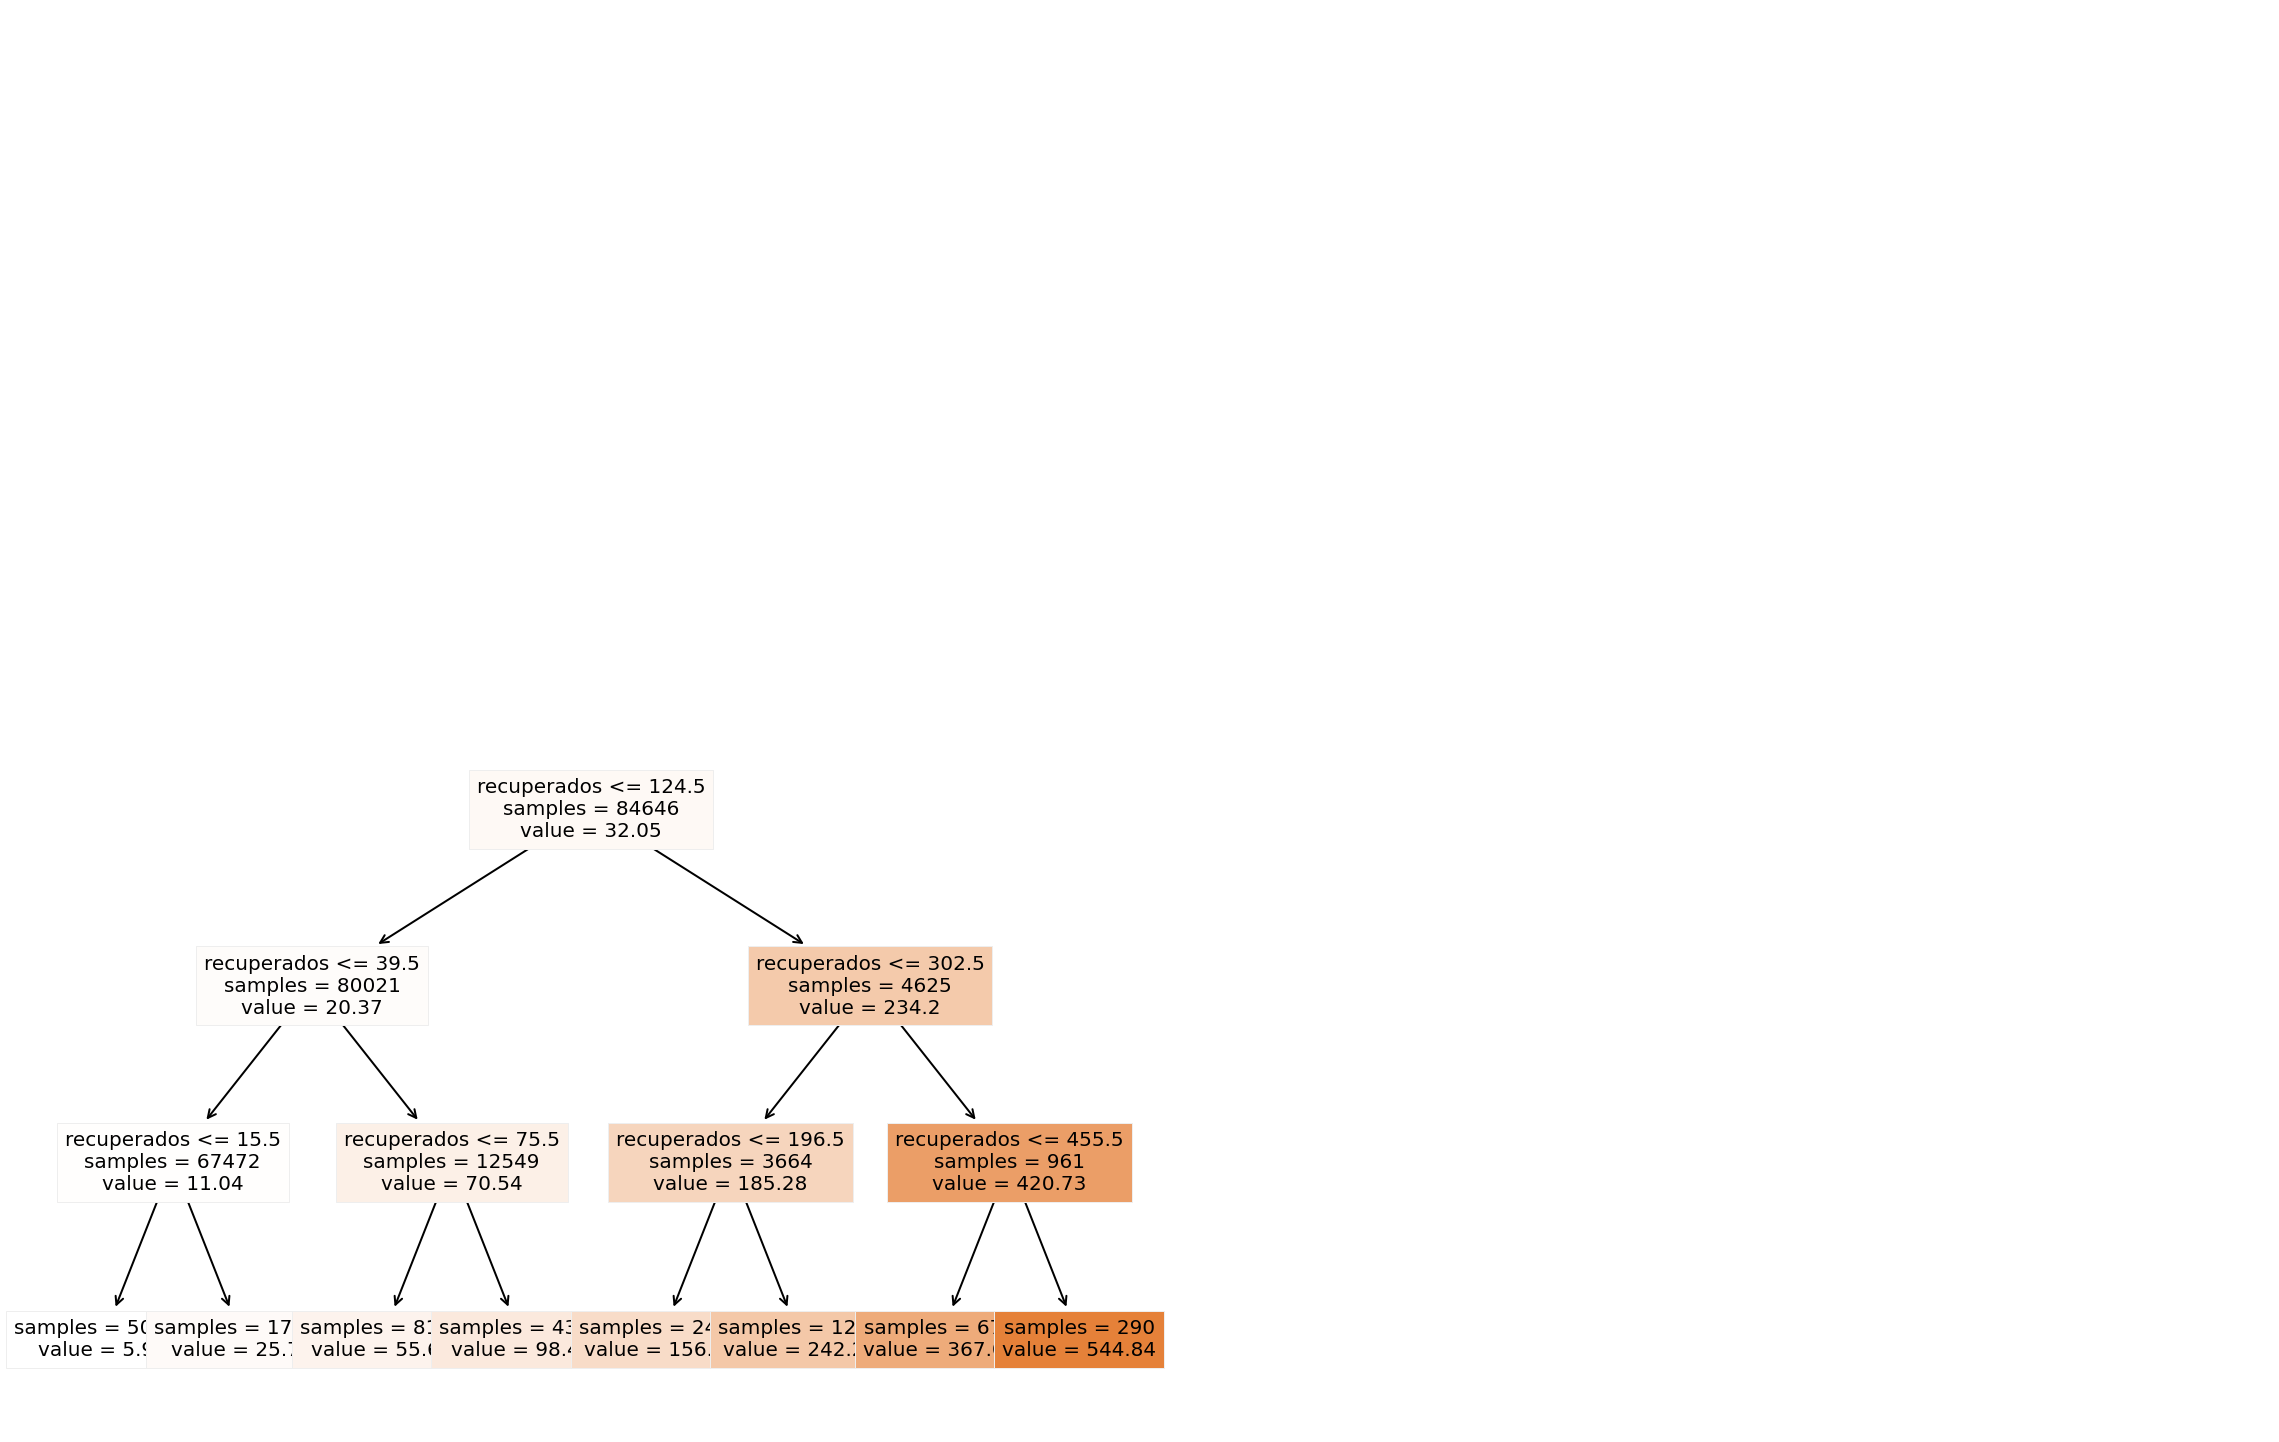

In [63]:
# Estructura del árbol creado
# ------------------------------------------------------------------------------
fig, ax = plt.subplots(figsize=(20, 13))

print(f"Profundidad del árbol: {modelo.get_depth()}")
print(f"Número de nodos terminales: {modelo.get_n_leaves()}")

plot = plot_tree(
            decision_tree = modelo,
            feature_names = datos.drop(columns = "confirmados").columns,
            class_names   = 'confirmados',
            filled        = True,
            impurity      = False,
            fontsize      = 10,
            precision     = 2,
            ax            = ax
       )
# para que aparezcan las flechas 
for o in plot:
    arrow = o.arrow_patch
    if arrow is not None:
        arrow.set_edgecolor('black')
        arrow.set_linewidth(1)

In [64]:
#APLICAMOS LA FUNCION export_text
texto_modelo = export_text(
                    decision_tree = modelo,
                    feature_names = list(datos.drop(columns = "confirmados").columns)
               )
print(texto_modelo)

|--- recuperados <= 124.50
|   |--- recuperados <= 39.50
|   |   |--- recuperados <= 15.50
|   |   |   |--- value: [5.97]
|   |   |--- recuperados >  15.50
|   |   |   |--- value: [25.78]
|   |--- recuperados >  39.50
|   |   |--- recuperados <= 75.50
|   |   |   |--- value: [55.66]
|   |   |--- recuperados >  75.50
|   |   |   |--- value: [98.46]
|--- recuperados >  124.50
|   |--- recuperados <= 302.50
|   |   |--- recuperados <= 196.50
|   |   |   |--- value: [156.18]
|   |   |--- recuperados >  196.50
|   |   |   |--- value: [242.29]
|   |--- recuperados >  302.50
|   |   |--- recuperados <= 455.50
|   |   |   |--- value: [367.09]
|   |   |--- recuperados >  455.50
|   |   |   |--- value: [544.84]



In [65]:
#VEMOS LA IMPORTANCIA QUE TIENE CADA UNO DE LOS PREDICTORES

importancia_predictores = pd.DataFrame(
                            {'predictor': datos.drop(columns = "confirmados").columns,
                             'importancia': modelo.feature_importances_}
                            )
print("Importancia de los predictores en el modelo")
print("-------------------------------------------")
importancia_predictores.sort_values('importancia', ascending=False)

Importancia de los predictores en el modelo
-------------------------------------------


,predictor,importancia
9,recuperados,1.0
0,fecha,0.0
1,iso,0.0
2,ccaa,0.0
3,sexo,0.0
4,edad,0.0
5,poblacion,0.0
6,hospitalizados,0.0
7,uci,0.0
8,fallecidos,0.0


In [67]:
# Error de test del modelo inicial
#-------------------------------------------------------------------------------
predicciones = modelo.predict(X = X_test)

rmse = mean_squared_error(
        y_true  = y_test,
        y_pred  = predicciones,
        squared = False
       )
print(f"El error (rmse) de test es: {rmse}")

El error (rmse) de test es: 10.240097525487656


## KNN

In [68]:
# sns:
import seaborn as sns

# Dimensiones del dataset
# ==============================================================================
datos.shape

# Número de datos ausentes por variable
# ==============================================================================
datos.isna().sum().sort_values()

# Ninguna variable contiene valores ausente. En el apartado imputación de valores ausentes se muestra varias estrategias de imputación cuando el set de datos está incompleto.

# volver a utilisar las variables fecha, iso, ccaa, sexo y edad como string 
datos.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 112862 entries, 14107 to 405491
Data columns (total 12 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   fecha           112862 non-null  int32  
 1   iso             112862 non-null  int8   
 2   ccaa            112862 non-null  int8   
 3   sexo            112862 non-null  int8   
 4   edad            112862 non-null  int8   
 5   poblacion       112862 non-null  int64  
 6   confirmados     112862 non-null  int64  
 7   hospitalizados  112862 non-null  int64  
 8   uci             112862 non-null  int64  
 9   fallecidos      112862 non-null  int64  
 10  recuperados     112862 non-null  int64  
 11  R0              112862 non-null  float64
dtypes: float64(1), int32(1), int64(6), int8(4)
memory usage: 7.7 MB


In [69]:
import multiprocessing
import random
from itertools import product
!pip install fitter
from fitter import Fitter, get_common_distributions

distribuciones = ['cauchy', 'chi2', 'expon',  'exponpow', 'gamma',
                  'norm', 'powerlaw', 'beta', 'logistic']

fitter = Fitter(bd_epidem.confirmados, distributions=distribuciones)
fitter.fit()
fitter.summary(Nbest=10, plot=False)

,sumsquare_error,aic,bic,kl_div
beta,0.000417,2526.538442,-2.191261e+06,inf
cauchy,0.000487,2096.996313,-2.173715e+06,inf
expon,0.000689,3291.312883,-2.134747e+06,inf
chi2,0.000907,1733.356496,-2.103636e+06,inf
exponpow,0.001262,1581.102602,-2.066371e+06,inf
powerlaw,0.001569,1476.400300,-2.041802e+06,inf
logistic,0.001897,4356.643014,-2.020350e+06,inf
norm,0.002424,6581.689513,-1.992706e+06,inf
gamma,0.002978,23370.708253,-1.969454e+06,inf


In [70]:
# Reparto de datos en train y test
# ==============================================================================
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
                                        datos.drop('confirmados', axis = 'columns'),
                                        datos['confirmados'],
                                        train_size   = 0.8,
                                        random_state = 1234,
                                        shuffle      = True
                                    )

In [71]:
# Selección de las variables por típo
# ==============================================================================
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.compose import make_column_selector

# Se estandarizan las columnas numéricas y se hace one-hot-encoding de las 
# columnas cualitativas. Para mantener las columnas a las que no se les aplica 
# ninguna transformación se tiene que indicar remainder='passthrough'.
numeric_cols = X_train.select_dtypes(include=['float64', 'int32']).columns.to_list()
cat_cols = X_train.select_dtypes(include=['object', 'category']).columns.to_list()

preprocessor = ColumnTransformer(
                   [('scale', StandardScaler(), numeric_cols),
                    ('onehot', OneHotEncoder(handle_unknown='ignore'), cat_cols)],
                remainder='passthrough')

In [72]:
X_train_prep = preprocessor.fit_transform(X_train)
X_test_prep  = preprocessor.transform(X_test)

In [73]:
# Selección de las variables por típo
# ==============================================================================
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.compose import make_column_selector

numeric_cols = X_train.select_dtypes(include=['float64', 'int32']).columns.to_list()
cat_cols = X_train.select_dtypes(include=['object', 'category']).columns.to_list()

# Transformaciones para las variables numéricas
numeric_transformer = Pipeline(
                        steps=[
                            ('imputer', SimpleImputer(strategy='median')),
                            ('scaler', StandardScaler())
                        ]
                      )


# Transformaciones para las variables categóricas
categorical_transformer = Pipeline(
                            steps=[
                                ('imputer', SimpleImputer(strategy='most_frequent')),
                                ('onehot', OneHotEncoder(handle_unknown='ignore'))
                            ]
                          )

preprocessor = ColumnTransformer(
                    transformers=[
                        ('numeric', numeric_transformer, numeric_cols),
                        ('cat', categorical_transformer, cat_cols)
                    ],
                    remainder='passthrough'
                )

In [74]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import BayesianRidge
from sklearn.tree import DecisionTreeRegressor
from sklearn import neighbors
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import AdaBoostRegressor 
from sklearn.neural_network import MLPRegressor
from sklearn import svm
regressor = svm.SVR()

In [75]:
datos.info()
datos.head(3)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 112862 entries, 14107 to 405491
Data columns (total 12 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   fecha           112862 non-null  int32  
 1   iso             112862 non-null  int8   
 2   ccaa            112862 non-null  int8   
 3   sexo            112862 non-null  int8   
 4   edad            112862 non-null  int8   
 5   poblacion       112862 non-null  int64  
 6   confirmados     112862 non-null  int64  
 7   hospitalizados  112862 non-null  int64  
 8   uci             112862 non-null  int64  
 9   fallecidos      112862 non-null  int64  
 10  recuperados     112862 non-null  int64  
 11  R0              112862 non-null  float64
dtypes: float64(1), int32(1), int64(6), int8(4)
memory usage: 7.7 MB


,fecha,iso,ccaa,sexo,edad,poblacion,confirmados,hospitalizados,uci,fallecidos,recuperados,R0
14107,18012020,12,13,1,4,589033,1,1,0,0,1,1.000002
23906,31012020,6,3,0,2,124436,1,0,0,0,1,1.000008
31432,9022020,10,11,0,4,107231,1,1,0,0,1,1.000009


In [76]:
datos1 = datos
datos1.head(3)

,fecha,iso,ccaa,sexo,edad,poblacion,confirmados,hospitalizados,uci,fallecidos,recuperados,R0
14107,18012020,12,13,1,4,589033,1,1,0,0,1,1.000002
23906,31012020,6,3,0,2,124436,1,0,0,0,1,1.000008
31432,9022020,10,11,0,4,107231,1,1,0,0,1,1.000009


## analisis confirmado

In [77]:
# División de los datos en train y test
# ------------------------------------------------------------------------------
X_train, X_test, y_train, y_test = train_test_split(
                                        datos.drop(columns = "confirmados"),
                                        datos['confirmados'],
                                        random_state = 123
                                    )

## arbol confirmado

In [78]:
regressor = DecisionTreeRegressor ()
regressor.fit(X_train, y_train)

DecisionTreeRegressor()

In [79]:
y_pred = regressor.predict(X_test)
y_pred

array([  9.,  16.,   8., ...,   2.,  25., 153.])

In [80]:
from numpy import random
import pandas as pd

print("NumPy Data Array is:")
print(y_pred)

print("")

data_df = pd.DataFrame(y_pred)
print("The DataFrame generated from the NumPy array is:")
print(data_df)

NumPy Data Array is:
[  9.  16.   8. ...   2.  25. 153.]

The DataFrame generated from the NumPy array is:
           0
0        9.0
1       16.0
2        8.0
3        4.0
4        1.0
...      ...
28211   11.0
28212    1.0
28213    2.0
28214   25.0
28215  153.0

[28216 rows x 1 columns]


In [81]:
df_epi = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
df_epi

,Actual,Predicted
58639,9,9.0
205014,16,16.0
72660,8,8.0
264332,4,4.0
175193,1,1.0
...,...,...
338680,11,11.0
135316,1,1.0
397343,2,2.0
212192,25,25.0


In [82]:
from sklearn import metrics
print('Mean Absolute Error (MAE):', metrics.mean_absolute_error(y_test, y_pred))
print('median_absolute_error (MAD):', metrics.median_absolute_error(y_test, y_pred))
print('Root Mean Squared Error (RMSE):', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print('mean_absolute_percentage_error (MAPE):', metrics.mean_absolute_percentage_error(y_test, y_pred))
print('max_error(MAX_ERROR):', metrics.max_error(y_test, y_pred))
print('explained_variance_score (EXPL):', metrics.explained_variance_score(y_test, y_pred, multioutput='uniform_average'))
print('R2_SCORE:', metrics.r2_score(y_test, y_pred))

Mean Absolute Error (MAE): 0.07056280124751914
median_absolute_error (MAD): 0.0
Root Mean Squared Error (RMSE): 0.7638012840224483
mean_absolute_percentage_error (MAPE): 0.0006880850621645476
max_error(MAX_ERROR): 54.0
explained_variance_score (EXPL): 0.9998351266094939
R2_SCORE: 0.9998350997600675


## KNEIGHBOURS REGRESSOR - CONFIRMADOS

In [83]:
regressor = KNeighborsRegressor()
regressor.fit(X_train, y_train)

KNeighborsRegressor()

In [84]:
y_pred = regressor.predict(X_test)
y_pred

array([10. , 17.8,  7. , ...,  4. ,  9.6, 86.6])

In [85]:
from numpy import random
import pandas as pd

print("NumPy Data Array is:")
print(y_pred)

print("")

print("The DataFrame generated from the NumPy array is:")
print(data_df)

NumPy Data Array is:
[10.  17.8  7.  ...  4.   9.6 86.6]

The DataFrame generated from the NumPy array is:
           0
0        9.0
1       16.0
2        8.0
3        4.0
4        1.0
...      ...
28211   11.0
28212    1.0
28213    2.0
28214   25.0
28215  153.0

[28216 rows x 1 columns]


In [86]:
df_epi = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
df_epi

,Actual,Predicted
58639,9,10.0
205014,16,17.8
72660,8,7.0
264332,4,3.4
175193,1,16.6
...,...,...
338680,11,7.6
135316,1,5.2
397343,2,4.0
212192,25,9.6


In [87]:
from sklearn import metrics
print('Mean Absolute Error (MAE):', metrics.mean_absolute_error(y_test, y_pred))
print('median_absolute_error (MAD):', metrics.median_absolute_error(y_test, y_pred))
print('Root Mean Squared Error (RMSE):', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print('mean_absolute_percentage_error (MAPE):', metrics.mean_absolute_percentage_error(y_test, y_pred))
print('max_error(MAX_ERROR):', metrics.max_error(y_test, y_pred))
print('explained_variance_score (EXPL):', metrics.explained_variance_score(y_test, y_pred, multioutput='uniform_average'))
print('R2_SCORE:', metrics.r2_score(y_test, y_pred))

Mean Absolute Error (MAE): 18.78283952367451
median_absolute_error (MAD): 6.800000000000001
Root Mean Squared Error (RMSE): 40.389092367261796
mean_absolute_percentage_error (MAPE): 169954383442874.7
max_error(MAX_ERROR): 500.2
explained_variance_score (EXPL): 0.5395318807117122
R2_SCORE: 0.5389068114182747


## MULTIPLE LINEAR REGRESSION - CONFIRMADOS

In [88]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import BayesianRidge

In [89]:
regressor = LinearRegression()
regressor.fit(X_train, y_train)

LinearRegression()

In [90]:
y_pred = regressor.predict(X_test)
y_pred

array([  9.00607942,  15.9592863 ,   7.97912544, ...,   2.01874747,
        25.01058771, 153.00713397])

In [91]:
from numpy import random
import pandas as pd

print("NumPy Data Array is:")
print(y_pred)

print("")

data_df = pd.DataFrame(y_pred)
print("The DataFrame generated from the NumPy array is:")
print(data_df)

NumPy Data Array is:
[  9.00607942  15.9592863    7.97912544 ...   2.01874747  25.01058771
 153.00713397]

The DataFrame generated from the NumPy array is:
                0
0        9.006079
1       15.959286
2        7.979125
3        4.008641
4        0.967205
...           ...
28211   11.010242
28212    0.977004
28213    2.018747
28214   25.010588
28215  153.007134

[28216 rows x 1 columns]


In [92]:
df_epi = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
df_epi

,Actual,Predicted
58639,9,9.006079
205014,16,15.959286
72660,8,7.979125
264332,4,4.008641
175193,1,0.967205
...,...,...
338680,11,11.010242
135316,1,0.977004
397343,2,2.018747
212192,25,25.010588


In [93]:
from sklearn import metrics
print('Mean Absolute Error (MAE):', metrics.mean_absolute_error(y_test, y_pred))
print('median_absolute_error (MAD):', metrics.median_absolute_error(y_test, y_pred))
print('Root Mean Squared Error (RMSE):', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print('mean_absolute_percentage_error (MAPE):', metrics.mean_absolute_percentage_error(y_test, y_pred))
print('max_error(MAX_ERROR):', metrics.max_error(y_test, y_pred))
print('explained_variance_score (EXPL):', metrics.explained_variance_score(y_test, y_pred, multioutput='uniform_average'))
print('R2_SCORE:', metrics.r2_score(y_test, y_pred))

Mean Absolute Error (MAE): 0.03028980595400913
median_absolute_error (MAD): 0.016614233941010248
Root Mean Squared Error (RMSE): 0.10963096351736193
mean_absolute_percentage_error (MAPE): 33901378044842.402
max_error(MAX_ERROR): 4.741211670004099
explained_variance_score (EXPL): 0.9999966029810813
R2_SCORE: 0.9999966027541144


## APLICAMOS BAYESIAN RIDGE REGRESSION - CONFIRMADOS

In [94]:
regressor = BayesianRidge()
regressor.fit(X_train, y_train)

BayesianRidge()

In [95]:
y_pred = regressor.predict(X_test)
y_pred

array([  9.00607942,  15.95928654,   7.97912571, ...,   2.01874729,
        25.01058753, 153.00713366])

In [96]:
from numpy import random
import pandas as pd

print("NumPy Data Array is:")
print(y_pred)

print("")

data_df = pd.DataFrame(y_pred)
print("The DataFrame generated from the NumPy array is:")
print(data_df)

NumPy Data Array is:
[  9.00607942  15.95928654   7.97912571 ...   2.01874729  25.01058753
 153.00713366]

The DataFrame generated from the NumPy array is:
                0
0        9.006079
1       15.959287
2        7.979126
3        4.008641
4        0.967206
...           ...
28211   11.010242
28212    0.977004
28213    2.018747
28214   25.010588
28215  153.007134

[28216 rows x 1 columns]


In [97]:
df_epi = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
df_epi

,Actual,Predicted
58639,9,9.006079
205014,16,15.959287
72660,8,7.979126
264332,4,4.008641
175193,1,0.967206
...,...,...
338680,11,11.010242
135316,1,0.977004
397343,2,2.018747
212192,25,25.010588


In [98]:
from sklearn import metrics
print('Mean Absolute Error (MAE):', metrics.mean_absolute_error(y_test, y_pred))
print('median_absolute_error (MAD):', metrics.median_absolute_error(y_test, y_pred))
print('Root Mean Squared Error (RMSE):', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print('mean_absolute_percentage_error (MAPE):', metrics.mean_absolute_percentage_error(y_test, y_pred))
print('max_error(MAX_ERROR):', metrics.max_error(y_test, y_pred))
print('explained_variance_score (EXPL):', metrics.explained_variance_score(y_test, y_pred, multioutput='uniform_average'))
print('R2_SCORE:', metrics.r2_score(y_test, y_pred))

Mean Absolute Error (MAE): 0.030289686736026406
median_absolute_error (MAD): 0.016614193364877572
Root Mean Squared Error (RMSE): 0.10963096587330452
mean_absolute_percentage_error (MAPE): 33901444111983.25
max_error(MAX_ERROR): 4.74121326646106
explained_variance_score (EXPL): 0.9999966029809337
R2_SCORE: 0.9999966027539684


## APLICAMOS RANDOM FOREST REGRESSOR - CONFIRMADOS

In [99]:
regressor = RandomForestRegressor()
regressor.fit(X_train, y_train)

RandomForestRegressor()

In [100]:
y_pred = regressor.predict(X_test)
y_pred

array([  9.,  16.,   8., ...,   2.,  25., 153.])

In [101]:
from numpy import random
import pandas as pd

print("NumPy Data Array is:")
print(y_pred)

print("")

data_df = pd.DataFrame(y_pred)
print("The DataFrame generated from the NumPy array is:")
print(data_df)

NumPy Data Array is:
[  9.  16.   8. ...   2.  25. 153.]

The DataFrame generated from the NumPy array is:
           0
0        9.0
1       16.0
2        8.0
3        4.0
4        1.0
...      ...
28211   11.0
28212    1.0
28213    2.0
28214   25.0
28215  153.0

[28216 rows x 1 columns]


In [102]:
df_epi = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
df_epi

,Actual,Predicted
58639,9,9.0
205014,16,16.0
72660,8,8.0
264332,4,4.0
175193,1,1.0
...,...,...
338680,11,11.0
135316,1,1.0
397343,2,2.0
212192,25,25.0


In [103]:
from sklearn import metrics
print('Mean Absolute Error (MAE):', metrics.mean_absolute_error(y_test, y_pred))
print('median_absolute_error (MAD):', metrics.median_absolute_error(y_test, y_pred))
print('Root Mean Squared Error (RMSE):', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print('mean_absolute_percentage_error (MAPE):', metrics.mean_absolute_percentage_error(y_test, y_pred))
print('max_error(MAX_ERROR):', metrics.max_error(y_test, y_pred))
print('explained_variance_score (EXPL):', metrics.explained_variance_score(y_test, y_pred, multioutput='uniform_average'))
print('R2_SCORE:', metrics.r2_score(y_test, y_pred))

Mean Absolute Error (MAE): 0.04144776013609301
median_absolute_error (MAD): 0.0
Root Mean Squared Error (RMSE): 0.582003151794396
mean_absolute_percentage_error (MAPE): 0.0004120841915014428
max_error(MAX_ERROR): 44.77000000000001
explained_variance_score (EXPL): 0.9999043224602027
R2_SCORE: 0.9999042560827


## APLICAMOS GRADIENT BOOSTING - CONFIRMADOS

In [104]:
regressor = GradientBoostingRegressor()
regressor.fit(X_train, y_train)

GradientBoostingRegressor()

In [105]:
y_pred = regressor.predict(X_test)
y_pred

array([  9.01668961,  16.4580256 ,   7.99038527, ...,   2.01509715,
        25.05314342, 154.29106054])

In [106]:
from numpy import random
import pandas as pd

print("NumPy Data Array is:")
print(y_pred)

print("")

data_df = pd.DataFrame(y_pred)
print("The DataFrame generated from the NumPy array is:")
print(data_df)

NumPy Data Array is:
[  9.01668961  16.4580256    7.99038527 ...   2.01509715  25.05314342
 154.29106054]

The DataFrame generated from the NumPy array is:
                0
0        9.016690
1       16.458026
2        7.990385
3        4.006433
4        1.026824
...           ...
28211   11.141657
28212    1.026824
28213    2.015097
28214   25.053143
28215  154.291061

[28216 rows x 1 columns]


In [107]:
df_epi = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
df_epi

,Actual,Predicted
58639,9,9.016690
205014,16,16.458026
72660,8,7.990385
264332,4,4.006433
175193,1,1.026824
...,...,...
338680,11,11.141657
135316,1,1.026824
397343,2,2.015097
212192,25,25.053143


In [108]:
from sklearn import metrics
print('Mean Absolute Error (MAE):', metrics.mean_absolute_error(y_test, y_pred))
print('median_absolute_error (MAD):', metrics.median_absolute_error(y_test, y_pred))
print('Root Mean Squared Error (RMSE):', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print('mean_absolute_percentage_error (MAPE):', metrics.mean_absolute_percentage_error(y_test, y_pred))
print('max_error(MAX_ERROR):', metrics.max_error(y_test, y_pred))
print('explained_variance_score (EXPL):', metrics.explained_variance_score(y_test, y_pred, multioutput='uniform_average'))
print('R2_SCORE:', metrics.r2_score(y_test, y_pred))

Mean Absolute Error (MAE): 0.2926079745468303
median_absolute_error (MAD): 0.08264282299761927
Root Mean Squared Error (RMSE): 0.63273778919741
mean_absolute_percentage_error (MAPE): 6366254205856.096
max_error(MAX_ERROR): 17.862308528906624
explained_variance_score (EXPL): 0.9998868361609853
R2_SCORE: 0.999886836058696


## APLICAMOS ADA BOOST - CONFIRMADOS

In [109]:
regressor = AdaBoostRegressor()
regressor.fit(X_train, y_train)

AdaBoostRegressor()

In [110]:
y_pred = regressor.predict(X_test)
y_pred

array([ 20.48079513,  20.48079513,  20.48079513, ...,  20.48079513,
        35.87466072, 171.33701367])

In [111]:
from numpy import random
import pandas as pd

print("NumPy Data Array is:")
print(y_pred)

print("")

data_df = pd.DataFrame(y_pred)
print("The DataFrame generated from the NumPy array is:")
print(data_df)

NumPy Data Array is:
[ 20.48079513  20.48079513  20.48079513 ...  20.48079513  35.87466072
 171.33701367]

The DataFrame generated from the NumPy array is:
                0
0       20.480795
1       20.480795
2       20.480795
3       20.480795
4       20.480795
...           ...
28211   20.480795
28212   20.480795
28213   20.480795
28214   35.874661
28215  171.337014

[28216 rows x 1 columns]


In [112]:
df_epi = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
df_epi

,Actual,Predicted
58639,9,20.480795
205014,16,20.480795
72660,8,20.480795
264332,4,20.480795
175193,1,20.480795
...,...,...
338680,11,20.480795
135316,1,20.480795
397343,2,20.480795
212192,25,35.874661


In [113]:
from sklearn import metrics
print('Mean Absolute Error (MAE):', metrics.mean_absolute_error(y_test, y_pred))
print('median_absolute_error (MAD):', metrics.median_absolute_error(y_test, y_pred))
print('Root Mean Squared Error (RMSE):', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print('mean_absolute_percentage_error (MAPE):', metrics.mean_absolute_percentage_error(y_test, y_pred))
print('max_error(MAX_ERROR):', metrics.max_error(y_test, y_pred))
print('explained_variance_score (EXPL):', metrics.explained_variance_score(y_test, y_pred, multioutput='uniform_average'))
print('R2_SCORE:', metrics.r2_score(y_test, y_pred))

Mean Absolute Error (MAE): 12.430454730482852
median_absolute_error (MAD): 12.480795130097505
Root Mean Squared Error (RMSE): 13.580074800481057
mean_absolute_percentage_error (MAPE): 670139168195797.1
max_error(MAX_ERROR): 67.89067650290377
explained_variance_score (EXPL): 0.9873502785054047
R2_SCORE: 0.9478727464742814


## APLICAMOS SUPPORT VECTOR MACHINE - CONFIRMADOS

In [114]:
regressor = svm.SVR()
regressor.fit(X_train, y_train)

SVR()

In [115]:
y_pred = regressor.predict(X_test)
y_pred

array([13.95006498,  9.90933225,  9.87458787, ...,  9.4569096 ,
        9.59002255, 15.95360975])

In [116]:
from numpy import random
import pandas as pd

print("NumPy Data Array is:")
print(y_pred)

print("")

data_df = pd.DataFrame(y_pred)
print("The DataFrame generated from the NumPy array is:")
print(data_df)

NumPy Data Array is:
[13.95006498  9.90933225  9.87458787 ...  9.4569096   9.59002255
 15.95360975]

The DataFrame generated from the NumPy array is:
               0
0      13.950065
1       9.909332
2       9.874588
3      10.936662
4      11.013205
...          ...
28211  10.806269
28212  11.167400
28213   9.456910
28214   9.590023
28215  15.953610

[28216 rows x 1 columns]


In [117]:
df_epi = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
df_epi

,Actual,Predicted
58639,9,13.950065
205014,16,9.909332
72660,8,9.874588
264332,4,10.936662
175193,1,11.013205
...,...,...
338680,11,10.806269
135316,1,11.167400
397343,2,9.456910
212192,25,9.590023


In [118]:
from sklearn import metrics
print('Mean Absolute Error (MAE):', metrics.mean_absolute_error(y_test, y_pred))
print('median_absolute_error (MAD):', metrics.median_absolute_error(y_test, y_pred))
print('Root Mean Squared Error (RMSE):', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print('mean_absolute_percentage_error (MAPE):', metrics.mean_absolute_percentage_error(y_test, y_pred))
print('max_error(MAX_ERROR):', metrics.max_error(y_test, y_pred))
print('explained_variance_score (EXPL):', metrics.explained_variance_score(y_test, y_pred, multioutput='uniform_average'))
print('R2_SCORE:', metrics.r2_score(y_test, y_pred))

Mean Absolute Error (MAE): 26.001687084107274
median_absolute_error (MAD): 8.324751662284275
Root Mean Squared Error (RMSE): 61.24185167568754
mean_absolute_percentage_error (MAPE): 345650774235299.25
max_error(MAX_ERROR): 714.9934632606246
explained_variance_score (EXPL): 0.046512086132876385
R2_SCORE: -0.06012517017703267


## APLICAMOS MULTILAYER PERCEPTRON REGRESSOR - CONFIRMADOS

In [119]:
regressor = MLPRegressor()
regressor.fit(X_train, y_train)

MLPRegressor()

In [120]:
y_pred = regressor.predict(X_test)
y_pred

array([-20.44145385, -28.16630492,   3.53053313, ..., -37.34627007,
       -51.53246562,  31.03423593])

In [121]:
from numpy import random
import pandas as pd

print("NumPy Data Array is:")
print(y_pred)

print("")

data_df = pd.DataFrame(y_pred)
print("The DataFrame generated from the NumPy array is:")
print(data_df)

NumPy Data Array is:
[-20.44145385 -28.16630492   3.53053313 ... -37.34627007 -51.53246562
  31.03423593]

The DataFrame generated from the NumPy array is:
                0
0      -20.441454
1      -28.166305
2        3.530533
3     -208.697625
4      -15.449018
...           ...
28211    3.853701
28212  -40.281255
28213  -37.346270
28214  -51.532466
28215   31.034236

[28216 rows x 1 columns]


In [122]:
df_epi = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
df_epi

,Actual,Predicted
58639,9,-20.441454
205014,16,-28.166305
72660,8,3.530533
264332,4,-208.697625
175193,1,-15.449018
...,...,...
338680,11,3.853701
135316,1,-40.281255
397343,2,-37.346270
212192,25,-51.532466


In [123]:
from sklearn import metrics
print('Mean Absolute Error (MAE):', metrics.mean_absolute_error(y_test, y_pred))
print('median_absolute_error (MAD):', metrics.median_absolute_error(y_test, y_pred))
print('Root Mean Squared Error (RMSE):', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print('mean_absolute_percentage_error (MAPE):', metrics.mean_absolute_percentage_error(y_test, y_pred))
print('max_error(MAX_ERROR):', metrics.max_error(y_test, y_pred))
print('explained_variance_score (EXPL):', metrics.explained_variance_score(y_test, y_pred, multioutput='uniform_average'))
print('R2_SCORE:', metrics.r2_score(y_test, y_pred))

Mean Absolute Error (MAE): 57.61190475930464
median_absolute_error (MAD): 49.316123250723564
Root Mean Squared Error (RMSE): 77.32133825672535
mean_absolute_percentage_error (MAPE): 1694304313822204.2
max_error(MAX_ERROR): 689.12756354085
explained_variance_score (EXPL): 0.04825558771738803
R2_SCORE: -0.6898931418213958


##  ANÁLISIS HOSPITALIZADOS

In [124]:
# División de los datos en train y test
# ------------------------------------------------------------------------------
X_train, X_test, y_train, y_test = train_test_split(
                                        datos.drop(columns = "hospitalizados"),
                                        datos['hospitalizados'],
                                        random_state = 123
                                    )

## ARBOL DE DECISIÓN - HOSPITALIZADOS

In [125]:
regressor = DecisionTreeRegressor ()
regressor.fit(X_train, y_train)

DecisionTreeRegressor()

In [126]:
y_pred = regressor.predict(X_test)
y_pred

array([4., 4., 3., ..., 0., 0., 2.])

In [127]:
from numpy import random
import pandas as pd

print("NumPy Data Array is:")
print(y_pred)

print("")

data_df = pd.DataFrame(y_pred)
print("The DataFrame generated from the NumPy array is:")
print(data_df)

NumPy Data Array is:
[4. 4. 3. ... 0. 0. 2.]

The DataFrame generated from the NumPy array is:
         0
0      4.0
1      4.0
2      3.0
3      0.0
4      0.0
...    ...
28211  0.0
28212  0.5
28213  0.0
28214  0.0
28215  2.0

[28216 rows x 1 columns]


In [128]:
df_epi = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
df_epi

,Actual,Predicted
58639,9,4.0
205014,0,4.0
72660,2,3.0
264332,0,0.0
175193,0,0.0
...,...,...
338680,0,0.0
135316,0,0.5
397343,0,0.0
212192,0,0.0


In [129]:
from sklearn import metrics
print('Mean Absolute Error (MAE):', metrics.mean_absolute_error(y_test, y_pred))
print('median_absolute_error (MAD):', metrics.median_absolute_error(y_test, y_pred))
print('Root Mean Squared Error (RMSE):', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print('mean_absolute_percentage_error (MAPE):', metrics.mean_absolute_percentage_error(y_test, y_pred))
print('max_error(MAX_ERROR):', metrics.max_error(y_test, y_pred))
print('explained_variance_score (EXPL):', metrics.explained_variance_score(y_test, y_pred, multioutput='uniform_average'))
print('R2_SCORE:', metrics.r2_score(y_test, y_pred))

Mean Absolute Error (MAE): 1.9036185143181175
median_absolute_error (MAD): 1.0
Root Mean Squared Error (RMSE): 4.724622755164909
mean_absolute_percentage_error (MAPE): 1052877620568099.1
max_error(MAX_ERROR): 119.0
explained_variance_score (EXPL): 0.7102969514061309
R2_SCORE: 0.7102447978456279


**KNEIGHBOURS REGRESSOR - HOSPITALIZADOS**

In [130]:
regressor = KNeighborsRegressor()
regressor.fit(X_train, y_train)

KNeighborsRegressor()

In [131]:
y_pred = regressor.predict(X_test)
y_pred

array([3.2, 0.8, 2.4, ..., 0. , 1.8, 3.8])

In [132]:
from numpy import random
import pandas as pd

print("NumPy Data Array is:")
print(y_pred)

print("")

print("The DataFrame generated from the NumPy array is:")
print(data_df)

NumPy Data Array is:
[3.2 0.8 2.4 ... 0.  1.8 3.8]

The DataFrame generated from the NumPy array is:
         0
0      4.0
1      4.0
2      3.0
3      0.0
4      0.0
...    ...
28211  0.0
28212  0.5
28213  0.0
28214  0.0
28215  2.0

[28216 rows x 1 columns]


In [133]:
df_epi = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
df_epi

,Actual,Predicted
58639,9,3.2
205014,0,0.8
72660,2,2.4
264332,0,0.4
175193,0,0.4
...,...,...
338680,0,0.8
135316,0,0.6
397343,0,0.0
212192,0,1.8


In [134]:
from sklearn import metrics
print('Mean Absolute Error (MAE):', metrics.mean_absolute_error(y_test, y_pred))
print('median_absolute_error (MAD):', metrics.median_absolute_error(y_test, y_pred))
print('Root Mean Squared Error (RMSE):', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print('mean_absolute_percentage_error (MAPE):', metrics.mean_absolute_percentage_error(y_test, y_pred))
print('max_error(MAX_ERROR):', metrics.max_error(y_test, y_pred))
print('explained_variance_score (EXPL):', metrics.explained_variance_score(y_test, y_pred, multioutput='uniform_average'))
print('R2_SCORE:', metrics.r2_score(y_test, y_pred))

Mean Absolute Error (MAE): 3.353685851998866
median_absolute_error (MAD): 1.2
Root Mean Squared Error (RMSE): 8.454891397617482
mean_absolute_percentage_error (MAPE): 3687122680466221.5
max_error(MAX_ERROR): 254.0
explained_variance_score (EXPL): 0.07226706325887078
R2_SCORE: 0.0720746610170121


**MULTIPLE LINEAR REGRESSION - HOSPITALIZADOS**

In [135]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import BayesianRidge

In [136]:
regressor = LinearRegression()
regressor.fit(X_train, y_train)

LinearRegression()

In [137]:
y_pred = regressor.predict(X_test)
y_pred

array([ 3.57281367,  1.2932371 ,  0.09431333, ..., -0.5006458 ,
        0.6263428 ,  3.73914087])

In [138]:
from numpy import random
import pandas as pd

print("NumPy Data Array is:")
print(y_pred)

print("")

data_df = pd.DataFrame(y_pred)
print("The DataFrame generated from the NumPy array is:")
print(data_df)

NumPy Data Array is:
[ 3.57281367  1.2932371   0.09431333 ... -0.5006458   0.6263428
  3.73914087]

The DataFrame generated from the NumPy array is:
              0
0      3.572814
1      1.293237
2      0.094313
3     -0.148209
4      0.439029
...         ...
28211 -0.723745
28212  0.608333
28213 -0.500646
28214  0.626343
28215  3.739141

[28216 rows x 1 columns]


In [139]:
df_epi = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
df_epi

,Actual,Predicted
58639,9,3.572814
205014,0,1.293237
72660,2,0.094313
264332,0,-0.148209
175193,0,0.439029
...,...,...
338680,0,-0.723745
135316,0,0.608333
397343,0,-0.500646
212192,0,0.626343


In [140]:
from sklearn import metrics
print('Mean Absolute Error (MAE):', metrics.mean_absolute_error(y_test, y_pred))
print('median_absolute_error (MAD):', metrics.median_absolute_error(y_test, y_pred))
print('Root Mean Squared Error (RMSE):', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print('mean_absolute_percentage_error (MAPE):', metrics.mean_absolute_percentage_error(y_test, y_pred))
print('max_error(MAX_ERROR):', metrics.max_error(y_test, y_pred))
print('explained_variance_score (EXPL):', metrics.explained_variance_score(y_test, y_pred, multioutput='uniform_average'))
print('R2_SCORE:', metrics.r2_score(y_test, y_pred))

Mean Absolute Error (MAE): 2.0353006812409173
median_absolute_error (MAD): 0.8882444758819286
Root Mean Squared Error (RMSE): 4.5014787370216105
mean_absolute_percentage_error (MAPE): 1858897660753931.5
max_error(MAX_ERROR): 130.0044043374768
explained_variance_score (EXPL): 0.7369721795869705
R2_SCORE: 0.7369687351462386


**APLICAMOS BAYESIAN RIDGE REGRESSION - HOSPITALIZADOS**

In [141]:
regressor = BayesianRidge()
regressor.fit(X_train, y_train)

BayesianRidge()

In [142]:
y_pred = regressor.predict(X_test)
y_pred

array([ 3.57289014,  1.29203241,  0.09349532, ..., -0.50011978,
        0.62672353,  3.73996816])

In [143]:
from numpy import random
import pandas as pd

print("NumPy Data Array is:")
print(y_pred)

print("")

data_df = pd.DataFrame(y_pred)
print("The DataFrame generated from the NumPy array is:")
print(data_df)

NumPy Data Array is:
[ 3.57289014  1.29203241  0.09349532 ... -0.50011978  0.62672353
  3.73996816]

The DataFrame generated from the NumPy array is:
              0
0      3.572890
1      1.292032
2      0.093495
3     -0.147972
4      0.437895
...         ...
28211 -0.723411
28212  0.607661
28213 -0.500120
28214  0.626724
28215  3.739968

[28216 rows x 1 columns]


In [144]:
df_epi = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
df_epi

,Actual,Predicted
58639,9,3.572890
205014,0,1.292032
72660,2,0.093495
264332,0,-0.147972
175193,0,0.437895
...,...,...
338680,0,-0.723411
135316,0,0.607661
397343,0,-0.500120
212192,0,0.626724


In [145]:
from sklearn import metrics
print('Mean Absolute Error (MAE):', metrics.mean_absolute_error(y_test, y_pred))
print('median_absolute_error (MAD):', metrics.median_absolute_error(y_test, y_pred))
print('Root Mean Squared Error (RMSE):', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print('mean_absolute_percentage_error (MAPE):', metrics.mean_absolute_percentage_error(y_test, y_pred))
print('max_error(MAX_ERROR):', metrics.max_error(y_test, y_pred))
print('explained_variance_score (EXPL):', metrics.explained_variance_score(y_test, y_pred, multioutput='uniform_average'))
print('R2_SCORE:', metrics.r2_score(y_test, y_pred))

Mean Absolute Error (MAE): 2.035260063291324
median_absolute_error (MAD): 0.8883648040844978
Root Mean Squared Error (RMSE): 4.501518140514108
mean_absolute_percentage_error (MAPE): 1858652005038540.8
max_error(MAX_ERROR): 130.0065126842058
explained_variance_score (EXPL): 0.7369675885748405
R2_SCORE: 0.7369641302612937


**APLICAMOS RANDOM FOREST REGRESSOR - HOSPITALIZADOS**

In [146]:
regressor = RandomForestRegressor()
regressor.fit(X_train, y_train)

RandomForestRegressor()

In [147]:
y_pred = regressor.predict(X_test)
y_pred

array([5.83, 3.07, 2.09, ..., 0.  , 0.03, 2.16])

In [148]:
from numpy import random
import pandas as pd

print("NumPy Data Array is:")
print(y_pred)

print("")

data_df = pd.DataFrame(y_pred)
print("The DataFrame generated from the NumPy array is:")
print(data_df)

NumPy Data Array is:
[5.83 3.07 2.09 ... 0.   0.03 2.16]

The DataFrame generated from the NumPy array is:
              0
0      5.830000
1      3.070000
2      2.090000
3      0.000000
4      0.080000
...         ...
28211  0.080000
28212  0.300667
28213  0.000000
28214  0.030000
28215  2.160000

[28216 rows x 1 columns]


In [149]:
df_epi = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
df_epi

,Actual,Predicted
58639,9,5.830000
205014,0,3.070000
72660,2,2.090000
264332,0,0.000000
175193,0,0.080000
...,...,...
338680,0,0.080000
135316,0,0.300667
397343,0,0.000000
212192,0,0.030000


In [150]:
from sklearn import metrics
print('Mean Absolute Error (MAE):', metrics.mean_absolute_error(y_test, y_pred))
print('median_absolute_error (MAD):', metrics.median_absolute_error(y_test, y_pred))
print('Root Mean Squared Error (RMSE):', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print('mean_absolute_percentage_error (MAPE):', metrics.mean_absolute_percentage_error(y_test, y_pred))
print('max_error(MAX_ERROR):', metrics.max_error(y_test, y_pred))
print('explained_variance_score (EXPL):', metrics.explained_variance_score(y_test, y_pred, multioutput='uniform_average'))
print('R2_SCORE:', metrics.r2_score(y_test, y_pred))

Mean Absolute Error (MAE): 1.4639886386649925
median_absolute_error (MAD): 0.6000000000000001
Root Mean Squared Error (RMSE): 3.3278661330106574
mean_absolute_percentage_error (MAPE): 1063268287175664.6
max_error(MAX_ERROR): 73.37
explained_variance_score (EXPL): 0.856260576662609
R2_SCORE: 0.8562431118313434


**APLICAMOS GRADIENT BOOSTING - HOSPITALIZADOS**

In [151]:
regressor = GradientBoostingRegressor()
regressor.fit(X_train, y_train)

GradientBoostingRegressor()

In [152]:
y_pred = regressor.predict(X_test)
y_pred

array([ 4.0719876 ,  1.37870663,  0.70139319, ..., -0.15117893,
        0.39204003,  3.80109283])

In [153]:
from numpy import random
import pandas as pd

print("NumPy Data Array is:")
print(y_pred)

print("")

data_df = pd.DataFrame(y_pred)
print("The DataFrame generated from the NumPy array is:")
print(data_df)

NumPy Data Array is:
[ 4.0719876   1.37870663  0.70139319 ... -0.15117893  0.39204003
  3.80109283]

The DataFrame generated from the NumPy array is:
              0
0      4.071988
1      1.378707
2      0.701393
3     -0.177223
4      0.443919
...         ...
28211 -0.105677
28212  0.406595
28213 -0.151179
28214  0.392040
28215  3.801093

[28216 rows x 1 columns]


In [154]:
df_epi = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
df_epi

,Actual,Predicted
58639,9,4.071988
205014,0,1.378707
72660,2,0.701393
264332,0,-0.177223
175193,0,0.443919
...,...,...
338680,0,-0.105677
135316,0,0.406595
397343,0,-0.151179
212192,0,0.392040


In [155]:
from sklearn import metrics
print('Mean Absolute Error (MAE):', metrics.mean_absolute_error(y_test, y_pred))
print('median_absolute_error (MAD):', metrics.median_absolute_error(y_test, y_pred))
print('Root Mean Squared Error (RMSE):', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print('mean_absolute_percentage_error (MAPE):', metrics.mean_absolute_percentage_error(y_test, y_pred))
print('max_error(MAX_ERROR):', metrics.max_error(y_test, y_pred))
print('explained_variance_score (EXPL):', metrics.explained_variance_score(y_test, y_pred, multioutput='uniform_average'))
print('R2_SCORE:', metrics.r2_score(y_test, y_pred))

Mean Absolute Error (MAE): 1.5476199249425637
median_absolute_error (MAD): 0.6555022112295489
Root Mean Squared Error (RMSE): 3.531511512863736
mean_absolute_percentage_error (MAPE): 1257296347477502.0
max_error(MAX_ERROR): 76.76577770042141
explained_variance_score (EXPL): 0.8381119626366695
R2_SCORE: 0.8381106721004057


**APLICAMOS ADA BOOST - HOSPITALIZADOS**

In [156]:
regressor = AdaBoostRegressor()
regressor.fit(X_train, y_train)

AdaBoostRegressor()

In [157]:
y_pred = regressor.predict(X_test)
y_pred

array([12.18665377, 11.37381892,  9.17006929, ...,  9.17006929,
       11.71496419, 20.26518929])

In [158]:
from numpy import random
import pandas as pd

print("NumPy Data Array is:")
print(y_pred)

print("")

data_df = pd.DataFrame(y_pred)
print("The DataFrame generated from the NumPy array is:")
print(data_df)

NumPy Data Array is:
[12.18665377 11.37381892  9.17006929 ...  9.17006929 11.71496419
 20.26518929]

The DataFrame generated from the NumPy array is:
               0
0      12.186654
1      11.373819
2       9.170069
3       9.170069
4       9.170069
...          ...
28211   9.170069
28212  11.373819
28213   9.170069
28214  11.714964
28215  20.265189

[28216 rows x 1 columns]


In [159]:
df_epi = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
df_epi

,Actual,Predicted
58639,9,12.186654
205014,0,11.373819
72660,2,9.170069
264332,0,9.170069
175193,0,9.170069
...,...,...
338680,0,9.170069
135316,0,11.373819
397343,0,9.170069
212192,0,11.714964


In [160]:
from sklearn import metrics
print('Mean Absolute Error (MAE):', metrics.mean_absolute_error(y_test, y_pred))
print('median_absolute_error (MAD):', metrics.median_absolute_error(y_test, y_pred))
print('Root Mean Squared Error (RMSE):', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print('mean_absolute_percentage_error (MAPE):', metrics.mean_absolute_percentage_error(y_test, y_pred))
print('max_error(MAX_ERROR):', metrics.max_error(y_test, y_pred))
print('explained_variance_score (EXPL):', metrics.explained_variance_score(y_test, y_pred, multioutput='uniform_average'))
print('R2_SCORE:', metrics.r2_score(y_test, y_pred))

Mean Absolute Error (MAE): 9.629937384627024
median_absolute_error (MAD): 9.1700692914222
Root Mean Squared Error (RMSE): 10.32481741457632
mean_absolute_percentage_error (MAPE): 2.2089413983132636e+16
max_error(MAX_ERROR): 85.05936599423632
explained_variance_score (EXPL): 0.732547672165573
R2_SCORE: -0.3837630440618238


**APLICAMOS SUPPORT VECTOR MACHINE - HOSPITALIZADOS**

In [161]:
regressor = svm.SVR()
regressor.fit(X_train, y_train)

SVR()

In [162]:
y_pred = regressor.predict(X_test)
y_pred

array([1.19349405, 0.30343299, 0.11024763, ..., 0.20212448, 0.12367285,
       1.61755156])

In [163]:
from numpy import random
import pandas as pd

print("NumPy Data Array is:")
print(y_pred)

print("")

data_df = pd.DataFrame(y_pred)
print("The DataFrame generated from the NumPy array is:")
print(data_df)

NumPy Data Array is:
[1.19349405 0.30343299 0.11024763 ... 0.20212448 0.12367285 1.61755156]

The DataFrame generated from the NumPy array is:
              0
0      1.193494
1      0.303433
2      0.110248
3      0.110145
4      0.522830
...         ...
28211  0.371679
28212  0.562157
28213  0.202124
28214  0.123673
28215  1.617552

[28216 rows x 1 columns]


In [164]:
df_epi = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
df_epi

,Actual,Predicted
58639,9,1.193494
205014,0,0.303433
72660,2,0.110248
264332,0,0.110145
175193,0,0.522830
...,...,...
338680,0,0.371679
135316,0,0.562157
397343,0,0.202124
212192,0,0.123673


In [165]:
from sklearn import metrics
print('Mean Absolute Error (MAE):', metrics.mean_absolute_error(y_test, y_pred))
print('median_absolute_error (MAD):', metrics.median_absolute_error(y_test, y_pred))
print('Root Mean Squared Error (RMSE):', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print('mean_absolute_percentage_error (MAPE):', metrics.mean_absolute_percentage_error(y_test, y_pred))
print('max_error(MAX_ERROR):', metrics.max_error(y_test, y_pred))
print('explained_variance_score (EXPL):', metrics.explained_variance_score(y_test, y_pred, multioutput='uniform_average'))
print('R2_SCORE:', metrics.r2_score(y_test, y_pred))

Mean Absolute Error (MAE): 2.9650901795966216
median_absolute_error (MAD): 0.6759767175380051
Root Mean Squared Error (RMSE): 8.984312341854949
mean_absolute_percentage_error (MAPE): 1108676749497199.2
max_error(MAX_ERROR): 268.0625701542562
explained_variance_score (EXPL): 0.027989218908114788
R2_SCORE: -0.04777166833321855


**APLICAMOS MULTILAYER PERCEPTRON REGRESSOR - HOSPITALIZADOS**

In [166]:
regressor = MLPRegressor()
regressor.fit(X_train, y_train)

MLPRegressor()

In [167]:
y_pred = regressor.predict(X_test)
y_pred

array([-43.52193489, -14.36227773,  -3.37698691, ..., -10.05494819,
        -3.3390441 , -43.02618616])

In [168]:
from numpy import random
import pandas as pd

print("NumPy Data Array is:")
print(y_pred)

print("")

data_df = pd.DataFrame(y_pred)
print("The DataFrame generated from the NumPy array is:")
print(data_df)

NumPy Data Array is:
[-43.52193489 -14.36227773  -3.37698691 ... -10.05494819  -3.3390441
 -43.02618616]

The DataFrame generated from the NumPy array is:
               0
0     -43.521935
1     -14.362278
2      -3.376987
3       0.781138
4     -25.326057
...          ...
28211 -10.123617
28212 -28.061848
28213 -10.054948
28214  -3.339044
28215 -43.026186

[28216 rows x 1 columns]


In [169]:
df_epi = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
df_epi

,Actual,Predicted
58639,9,-43.521935
205014,0,-14.362278
72660,2,-3.376987
264332,0,0.781138
175193,0,-25.326057
...,...,...
338680,0,-10.123617
135316,0,-28.061848
397343,0,-10.054948
212192,0,-3.339044


In [170]:
from sklearn import metrics
print('Mean Absolute Error (MAE):', metrics.mean_absolute_error(y_test, y_pred))
print('median_absolute_error (MAD):', metrics.median_absolute_error(y_test, y_pred))
print('Root Mean Squared Error (RMSE):', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print('mean_absolute_percentage_error (MAPE):', metrics.mean_absolute_percentage_error(y_test, y_pred))
print('max_error(MAX_ERROR):', metrics.max_error(y_test, y_pred))
print('explained_variance_score (EXPL):', metrics.explained_variance_score(y_test, y_pred, multioutput='uniform_average'))
print('R2_SCORE:', metrics.r2_score(y_test, y_pred))

Mean Absolute Error (MAE): 38.12493964565166
median_absolute_error (MAD): 19.201941004442272
Root Mean Squared Error (RMSE): 95.73389811790821
mean_absolute_percentage_error (MAPE): 5.688377580679004e+16
max_error(MAX_ERROR): 1247.6357210047017
explained_variance_score (EXPL): -114.32027726088522
R2_SCORE: -117.96753228604085


**ANÁLISIS FALLECIDOS**

In [171]:
# División de los datos en train y test
# ------------------------------------------------------------------------------
X_train, X_test, y_train, y_test = train_test_split(
                                        datos.drop(columns = "fallecidos"),
                                        datos['fallecidos'],
                                        random_state = 123
                                    )

**ARBOL DE DECISIÓN - FALLECIDOS**

In [172]:
regressor = DecisionTreeRegressor ()
regressor.fit(X_train, y_train)

DecisionTreeRegressor()

In [173]:
y_pred = regressor.predict(X_test)
y_pred

array([2., 0., 0., ..., 0., 0., 0.])

In [174]:
from numpy import random
import pandas as pd

print("NumPy Data Array is:")
print(y_pred)

print("")

data_df = pd.DataFrame(y_pred)
print("The DataFrame generated from the NumPy array is:")
print(data_df)

NumPy Data Array is:
[2. 0. 0. ... 0. 0. 0.]

The DataFrame generated from the NumPy array is:
         0
0      2.0
1      0.0
2      0.0
3      0.0
4      0.0
...    ...
28211  0.0
28212  0.0
28213  0.0
28214  0.0
28215  0.0

[28216 rows x 1 columns]


In [175]:
df_epi = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
df_epi

,Actual,Predicted
58639,2,2.0
205014,0,0.0
72660,0,0.0
264332,0,0.0
175193,0,0.0
...,...,...
338680,0,0.0
135316,0,0.0
397343,0,0.0
212192,0,0.0


In [176]:
from sklearn import metrics
print('Mean Absolute Error (MAE):', metrics.mean_absolute_error(y_test, y_pred))
print('median_absolute_error (MAD):', metrics.median_absolute_error(y_test, y_pred))
print('Root Mean Squared Error (RMSE):', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print('mean_absolute_percentage_error (MAPE):', metrics.mean_absolute_percentage_error(y_test, y_pred))
print('max_error(MAX_ERROR):', metrics.max_error(y_test, y_pred))
print('explained_variance_score (EXPL):', metrics.explained_variance_score(y_test, y_pred, multioutput='uniform_average'))
print('R2_SCORE:', metrics.r2_score(y_test, y_pred))

Mean Absolute Error (MAE): 0.03760277856535299
median_absolute_error (MAD): 0.0
Root Mean Squared Error (RMSE): 0.46560916134200203
mean_absolute_percentage_error (MAPE): 0.0048672422121058285
max_error(MAX_ERROR): 26.0
explained_variance_score (EXPL): 0.9756567706826855
R2_SCORE: 0.9756523512183461


**KNEIGHBOURS REGRESSOR - FALLECIDOS**

In [177]:
regressor = KNeighborsRegressor()
regressor.fit(X_train, y_train)

KNeighborsRegressor()

In [178]:
y_pred = regressor.predict(X_test)
y_pred

array([1.8, 0. , 0.8, ..., 0. , 0.2, 2.2])

In [179]:
from numpy import random
import pandas as pd

print("NumPy Data Array is:")
print(y_pred)

print("")

print("The DataFrame generated from the NumPy array is:")
print(data_df)

NumPy Data Array is:
[1.8 0.  0.8 ... 0.  0.2 2.2]

The DataFrame generated from the NumPy array is:
         0
0      2.0
1      0.0
2      0.0
3      0.0
4      0.0
...    ...
28211  0.0
28212  0.0
28213  0.0
28214  0.0
28215  0.0

[28216 rows x 1 columns]


In [180]:
df_epi = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
df_epi

,Actual,Predicted
58639,2,1.8
205014,0,0.0
72660,0,0.8
264332,0,0.0
175193,0,0.0
...,...,...
338680,0,0.0
135316,0,0.0
397343,0,0.0
212192,0,0.2


In [181]:
from sklearn import metrics
print('Mean Absolute Error (MAE):', metrics.mean_absolute_error(y_test, y_pred))
print('median_absolute_error (MAD):', metrics.median_absolute_error(y_test, y_pred))
print('Root Mean Squared Error (RMSE):', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print('mean_absolute_percentage_error (MAPE):', metrics.mean_absolute_percentage_error(y_test, y_pred))
print('max_error(MAX_ERROR):', metrics.max_error(y_test, y_pred))
print('explained_variance_score (EXPL):', metrics.explained_variance_score(y_test, y_pred, multioutput='uniform_average'))
print('R2_SCORE:', metrics.r2_score(y_test, y_pred))

Mean Absolute Error (MAE): 0.9953997731783386
median_absolute_error (MAD): 0.2
Root Mean Squared Error (RMSE): 3.0392137542188915
mean_absolute_percentage_error (MAPE): 1893823018807641.5
max_error(MAX_ERROR): 89.4
explained_variance_score (EXPL): -0.037375219913298174
R2_SCORE: -0.03737669332764004


**MULTIPLE LINEAR REGRESSION - FALLECIDOS**

In [182]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import BayesianRidge

In [183]:
regressor = LinearRegression()
regressor.fit(X_train, y_train)

LinearRegression()

In [184]:
y_pred = regressor.predict(X_test)
y_pred

array([ 2.00017942,  0.04124972,  0.02391567, ..., -0.01982352,
       -0.01211595, -0.0111692 ])

In [185]:
from numpy import random
import pandas as pd

print("NumPy Data Array is:")
print(y_pred)

print("")

data_df = pd.DataFrame(y_pred)
print("The DataFrame generated from the NumPy array is:")
print(data_df)

NumPy Data Array is:
[ 2.00017942  0.04124972  0.02391567 ... -0.01982352 -0.01211595
 -0.0111692 ]

The DataFrame generated from the NumPy array is:
              0
0      2.000179
1      0.041250
2      0.023916
3     -0.009321
4      0.034265
...         ...
28211 -0.011001
28212  0.022876
28213 -0.019824
28214 -0.012116
28215 -0.011169

[28216 rows x 1 columns]


In [186]:
df_epi = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
df_epi

,Actual,Predicted
58639,2,2.000179
205014,0,0.041250
72660,0,0.023916
264332,0,-0.009321
175193,0,0.034265
...,...,...
338680,0,-0.011001
135316,0,0.022876
397343,0,-0.019824
212192,0,-0.012116


In [187]:
from sklearn import metrics
print('Mean Absolute Error (MAE):', metrics.mean_absolute_error(y_test, y_pred))
print('median_absolute_error (MAD):', metrics.median_absolute_error(y_test, y_pred))
print('Root Mean Squared Error (RMSE):', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print('mean_absolute_percentage_error (MAPE):', metrics.mean_absolute_percentage_error(y_test, y_pred))
print('max_error(MAX_ERROR):', metrics.max_error(y_test, y_pred))
print('explained_variance_score (EXPL):', metrics.explained_variance_score(y_test, y_pred, multioutput='uniform_average'))
print('R2_SCORE:', metrics.r2_score(y_test, y_pred))

Mean Absolute Error (MAE): 0.030318974894583153
median_absolute_error (MAD): 0.017189918932393453
Root Mean Squared Error (RMSE): 0.11036430105460765
mean_absolute_percentage_error (MAPE): 70626332272340.72
max_error(MAX_ERROR): 4.789553267276211
explained_variance_score (EXPL): 0.9986321420454085
R2_SCORE: 0.9986320468338046


**APLICAMOS BAYESIAN RIDGE REGRESSION - FALLECIDOS**

In [188]:
regressor = BayesianRidge()
regressor.fit(X_train, y_train)

BayesianRidge()

In [189]:
y_pred = regressor.predict(X_test)
y_pred

array([ 2.00018062,  0.04124953,  0.02391596, ..., -0.01982352,
       -0.01211605, -0.01116966])

In [190]:
from numpy import random
import pandas as pd

print("NumPy Data Array is:")
print(y_pred)

print("")

data_df = pd.DataFrame(y_pred)
print("The DataFrame generated from the NumPy array is:")
print(data_df)

NumPy Data Array is:
[ 2.00018062  0.04124953  0.02391596 ... -0.01982352 -0.01211605
 -0.01116966]

The DataFrame generated from the NumPy array is:
              0
0      2.000181
1      0.041250
2      0.023916
3     -0.009321
4      0.034265
...         ...
28211 -0.011002
28212  0.022876
28213 -0.019824
28214 -0.012116
28215 -0.011170

[28216 rows x 1 columns]


In [191]:
df_epi = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
df_epi

,Actual,Predicted
58639,2,2.000181
205014,0,0.041250
72660,0,0.023916
264332,0,-0.009321
175193,0,0.034265
...,...,...
338680,0,-0.011002
135316,0,0.022876
397343,0,-0.019824
212192,0,-0.012116


In [192]:
from sklearn import metrics
print('Mean Absolute Error (MAE):', metrics.mean_absolute_error(y_test, y_pred))
print('median_absolute_error (MAD):', metrics.median_absolute_error(y_test, y_pred))
print('Root Mean Squared Error (RMSE):', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print('mean_absolute_percentage_error (MAPE):', metrics.mean_absolute_percentage_error(y_test, y_pred))
print('max_error(MAX_ERROR):', metrics.max_error(y_test, y_pred))
print('explained_variance_score (EXPL):', metrics.explained_variance_score(y_test, y_pred, multioutput='uniform_average'))
print('R2_SCORE:', metrics.r2_score(y_test, y_pred))

Mean Absolute Error (MAE): 0.030318835732612317
median_absolute_error (MAD): 0.017189525970290942
Root Mean Squared Error (RMSE): 0.11036429776773983
mean_absolute_percentage_error (MAPE): 70626329157935.28
max_error(MAX_ERROR): 4.789556469562141
explained_variance_score (EXPL): 0.9986321421269894
R2_SCORE: 0.9986320469152853


**APLICAMOS RANDOM FOREST REGRESSOR - FALLECIDOS**

In [193]:
regressor = RandomForestRegressor()
regressor.fit(X_train, y_train)

RandomForestRegressor()

In [194]:
y_pred = regressor.predict(X_test)
y_pred

array([2., 0., 0., ..., 0., 0., 0.])

In [195]:
from numpy import random
import pandas as pd

print("NumPy Data Array is:")
print(y_pred)

print("")

data_df = pd.DataFrame(y_pred)
print("The DataFrame generated from the NumPy array is:")
print(data_df)

NumPy Data Array is:
[2. 0. 0. ... 0. 0. 0.]

The DataFrame generated from the NumPy array is:
         0
0      2.0
1      0.0
2      0.0
3      0.0
4      0.0
...    ...
28211  0.0
28212  0.0
28213  0.0
28214  0.0
28215  0.0

[28216 rows x 1 columns]


In [196]:
df_epi = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
df_epi

,Actual,Predicted
58639,2,2.0
205014,0,0.0
72660,0,0.0
264332,0,0.0
175193,0,0.0
...,...,...
338680,0,0.0
135316,0,0.0
397343,0,0.0
212192,0,0.0


In [197]:
from sklearn import metrics
print('Mean Absolute Error (MAE):', metrics.mean_absolute_error(y_test, y_pred))
print('median_absolute_error (MAD):', metrics.median_absolute_error(y_test, y_pred))
print('Root Mean Squared Error (RMSE):', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print('mean_absolute_percentage_error (MAPE):', metrics.mean_absolute_percentage_error(y_test, y_pred))
print('max_error(MAX_ERROR):', metrics.max_error(y_test, y_pred))
print('explained_variance_score (EXPL):', metrics.explained_variance_score(y_test, y_pred, multioutput='uniform_average'))
print('R2_SCORE:', metrics.r2_score(y_test, y_pred))

Mean Absolute Error (MAE): 0.01838673093280408
median_absolute_error (MAD): 0.0
Root Mean Squared Error (RMSE): 0.24943382160022864
mean_absolute_percentage_error (MAPE): 0.0038167254370625337
max_error(MAX_ERROR): 19.78
explained_variance_score (EXPL): 0.99301358303246
R2_SCORE: 0.9930124540663925


**APLICAMOS GRADIENT BOOSTING - FALLECIDOS**

In [198]:
regressor = GradientBoostingRegressor()
regressor.fit(X_train, y_train)

GradientBoostingRegressor()

In [199]:
y_pred = regressor.predict(X_test)
y_pred

array([ 2.23136165, -0.02625236, -0.02124406, ..., -0.02124406,
       -0.02945574,  0.03811579])

In [200]:
from numpy import random
import pandas as pd

print("NumPy Data Array is:")
print(y_pred)

print("")

data_df = pd.DataFrame(y_pred)
print("The DataFrame generated from the NumPy array is:")
print(data_df)

NumPy Data Array is:
[ 2.23136165 -0.02625236 -0.02124406 ... -0.02124406 -0.02945574
  0.03811579]

The DataFrame generated from the NumPy array is:
              0
0      2.231362
1     -0.026252
2     -0.021244
3     -0.021244
4     -0.014537
...         ...
28211 -0.021244
28212 -0.021244
28213 -0.021244
28214 -0.029456
28215  0.038116

[28216 rows x 1 columns]


In [201]:
df_epi = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
df_epi

,Actual,Predicted
58639,2,2.231362
205014,0,-0.026252
72660,0,-0.021244
264332,0,-0.021244
175193,0,-0.014537
...,...,...
338680,0,-0.021244
135316,0,-0.021244
397343,0,-0.021244
212192,0,-0.029456


In [202]:
from sklearn import metrics
print('Mean Absolute Error (MAE):', metrics.mean_absolute_error(y_test, y_pred))
print('median_absolute_error (MAD):', metrics.median_absolute_error(y_test, y_pred))
print('Root Mean Squared Error (RMSE):', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print('mean_absolute_percentage_error (MAPE):', metrics.mean_absolute_percentage_error(y_test, y_pred))
print('max_error(MAX_ERROR):', metrics.max_error(y_test, y_pred))
print('explained_variance_score (EXPL):', metrics.explained_variance_score(y_test, y_pred, multioutput='uniform_average'))
print('R2_SCORE:', metrics.r2_score(y_test, y_pred))

Mean Absolute Error (MAE): 0.12533402350993
median_absolute_error (MAD): 0.02314049528927248
Root Mean Squared Error (RMSE): 0.45547317988528346
mean_absolute_percentage_error (MAPE): 129796279220414.73
max_error(MAX_ERROR): 19.576228572715564
explained_variance_score (EXPL): 0.9767009953332435
R2_SCORE: 0.9767008749345569


**APLICAMOS ADA BOOST - FALLECIDOS**

In [203]:
regressor = AdaBoostRegressor()
regressor.fit(X_train, y_train)

AdaBoostRegressor()

In [204]:
y_pred = regressor.predict(X_test)
y_pred

array([6.16573531, 1.30853175, 1.30853175, ..., 1.30853175, 1.30853175,
       1.75857893])

In [205]:
from numpy import random
import pandas as pd

print("NumPy Data Array is:")
print(y_pred)

print("")

data_df = pd.DataFrame(y_pred)
print("The DataFrame generated from the NumPy array is:")
print(data_df)

NumPy Data Array is:
[6.16573531 1.30853175 1.30853175 ... 1.30853175 1.30853175 1.75857893]

The DataFrame generated from the NumPy array is:
              0
0      6.165735
1      1.308532
2      1.308532
3      1.308532
4      1.308532
...         ...
28211  1.308532
28212  1.308532
28213  1.308532
28214  1.308532
28215  1.758579

[28216 rows x 1 columns]


In [206]:
df_epi = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
df_epi

,Actual,Predicted
58639,2,6.165735
205014,0,1.308532
72660,0,1.308532
264332,0,1.308532
175193,0,1.308532
...,...,...
338680,0,1.308532
135316,0,1.308532
397343,0,1.308532
212192,0,1.308532


In [207]:
from sklearn import metrics
print('Mean Absolute Error (MAE):', metrics.mean_absolute_error(y_test, y_pred))
print('median_absolute_error (MAD):', metrics.median_absolute_error(y_test, y_pred))
print('Root Mean Squared Error (RMSE):', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print('mean_absolute_percentage_error (MAPE):', metrics.mean_absolute_percentage_error(y_test, y_pred))
print('max_error(MAX_ERROR):', metrics.max_error(y_test, y_pred))
print('explained_variance_score (EXPL):', metrics.explained_variance_score(y_test, y_pred, multioutput='uniform_average'))
print('R2_SCORE:', metrics.r2_score(y_test, y_pred))

Mean Absolute Error (MAE): 1.7279416077038245
median_absolute_error (MAD): 1.308531746031746
Root Mean Squared Error (RMSE): 2.1038359090214
mean_absolute_percentage_error (MAPE): 5173373471284544.0
max_error(MAX_ERROR): 26.584878867421146
explained_variance_score (EXPL): 0.8200433688467844
R2_SCORE: 0.5029069152021425


**APLICAMOS SUPPORT VECTOR MACHINE - FALLECIDOS**

In [208]:
regressor = svm.SVR()
regressor.fit(X_train, y_train)

SVR()

In [209]:
y_pred = regressor.predict(X_test)
y_pred

array([0.10027454, 0.10027995, 0.10002501, ..., 0.10023067, 0.0996472 ,
       0.1000621 ])

In [210]:
from numpy import random
import pandas as pd

print("NumPy Data Array is:")
print(y_pred)

print("")

data_df = pd.DataFrame(y_pred)
print("The DataFrame generated from the NumPy array is:")
print(data_df)

NumPy Data Array is:
[0.10027454 0.10027995 0.10002501 ... 0.10023067 0.0996472  0.1000621 ]

The DataFrame generated from the NumPy array is:
              0
0      0.100275
1      0.100280
2      0.100025
3      0.100166
4      0.100065
...         ...
28211  0.099817
28212  0.099969
28213  0.100231
28214  0.099647
28215  0.100062

[28216 rows x 1 columns]


In [211]:
df_epi = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
df_epi

,Actual,Predicted
58639,2,0.100275
205014,0,0.100280
72660,0,0.100025
264332,0,0.100166
175193,0,0.100065
...,...,...
338680,0,0.099817
135316,0,0.099969
397343,0,0.100231
212192,0,0.099647


In [212]:
from sklearn import metrics
print('Mean Absolute Error (MAE):', metrics.mean_absolute_error(y_test, y_pred))
print('median_absolute_error (MAD):', metrics.median_absolute_error(y_test, y_pred))
print('Root Mean Squared Error (RMSE):', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print('mean_absolute_percentage_error (MAPE):', metrics.mean_absolute_percentage_error(y_test, y_pred))
print('max_error(MAX_ERROR):', metrics.max_error(y_test, y_pred))
print('explained_variance_score (EXPL):', metrics.explained_variance_score(y_test, y_pred, multioutput='uniform_average'))
print('R2_SCORE:', metrics.r2_score(y_test, y_pred))

Mean Absolute Error (MAE): 0.7228310520434695
median_absolute_error (MAD): 0.10006146970198956
Root Mean Squared Error (RMSE): 3.0356028306029557
mean_absolute_percentage_error (MAPE): 372192248669407.0
max_error(MAX_ERROR): 89.90034735422392
explained_variance_score (EXPL): -1.2549908681158684e-06
R2_SCORE: -0.03491312015527415


**APLICAMOS MULTILAYER PERCEPTRON REGRESSOR - FALLECIDOS**

In [213]:
regressor = MLPRegressor()
regressor.fit(X_train, y_train)

MLPRegressor()

In [214]:
y_pred = regressor.predict(X_test)
y_pred

array([ -76.03814209,  -39.4930972 ,   -3.86085861, ...,  -36.91708735,
       -229.77572373,  -95.76443866])

In [215]:
from numpy import random
import pandas as pd

print("NumPy Data Array is:")
print(y_pred)

print("")

data_df = pd.DataFrame(y_pred)
print("The DataFrame generated from the NumPy array is:")
print(data_df)

NumPy Data Array is:
[ -76.03814209  -39.4930972    -3.86085861 ...  -36.91708735 -229.77572373
  -95.76443866]

The DataFrame generated from the NumPy array is:
                0
0      -76.038142
1      -39.493097
2       -3.860859
3     -595.381946
4      -38.375574
...           ...
28211  -21.860526
28212  -57.268702
28213  -36.917087
28214 -229.775724
28215  -95.764439

[28216 rows x 1 columns]


In [216]:
df_epi = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
df_epi

,Actual,Predicted
58639,2,-76.038142
205014,0,-39.493097
72660,0,-3.860859
264332,0,-595.381946
175193,0,-38.375574
...,...,...
338680,0,-21.860526
135316,0,-57.268702
397343,0,-36.917087
212192,0,-229.775724


In [217]:
from sklearn import metrics
print('Mean Absolute Error (MAE):', metrics.mean_absolute_error(y_test, y_pred))
print('median_absolute_error (MAD):', metrics.median_absolute_error(y_test, y_pred))
print('Root Mean Squared Error (RMSE):', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print('mean_absolute_percentage_error (MAPE):', metrics.mean_absolute_percentage_error(y_test, y_pred))
print('max_error(MAX_ERROR):', metrics.max_error(y_test, y_pred))
print('explained_variance_score (EXPL):', metrics.explained_variance_score(y_test, y_pred, multioutput='uniform_average'))
print('R2_SCORE:', metrics.r2_score(y_test, y_pred))

Mean Absolute Error (MAE): 88.95343724234205
median_absolute_error (MAD): 60.084010467952716
Root Mean Squared Error (RMSE): 130.03333258536003
mean_absolute_percentage_error (MAPE): 3.260965723800956e+17
max_error(MAX_ERROR): 986.7532963704863
explained_variance_score (EXPL): -1152.4866398606002
R2_SCORE: -1897.9930737045281


**ANÁLISIS UCI**

In [218]:
# División de los datos en train y test
# ------------------------------------------------------------------------------
X_train, X_test, y_train, y_test = train_test_split(
                                        datos.drop(columns = "uci"),
                                        datos['uci'],
                                        random_state = 123
                                    )

**ARBOL DE DECISIÓN - UCI**

In [219]:
regressor = DecisionTreeRegressor ()
regressor.fit(X_train, y_train)

DecisionTreeRegressor()

In [220]:
y_pred = regressor.predict(X_test)
y_pred

array([2., 1., 0., ..., 0., 0., 0.])

In [221]:
from numpy import random
import pandas as pd

print("NumPy Data Array is:")
print(y_pred)

print("")

data_df = pd.DataFrame(y_pred)
print("The DataFrame generated from the NumPy array is:")
print(data_df)

NumPy Data Array is:
[2. 1. 0. ... 0. 0. 0.]

The DataFrame generated from the NumPy array is:
         0
0      2.0
1      1.0
2      0.0
3      0.0
4      0.0
...    ...
28211  0.0
28212  0.0
28213  0.0
28214  0.0
28215  0.0

[28216 rows x 1 columns]


In [222]:
df_epi = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
df_epi

,Actual,Predicted
58639,0,2.0
205014,0,1.0
72660,0,0.0
264332,0,0.0
175193,0,0.0
...,...,...
338680,0,0.0
135316,0,0.0
397343,0,0.0
212192,0,0.0


In [223]:
from sklearn import metrics
print('Mean Absolute Error (MAE):', metrics.mean_absolute_error(y_test, y_pred))
print('median_absolute_error (MAD):', metrics.median_absolute_error(y_test, y_pred))
print('Root Mean Squared Error (RMSE):', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print('mean_absolute_percentage_error (MAPE):', metrics.mean_absolute_percentage_error(y_test, y_pred))
print('max_error(MAX_ERROR):', metrics.max_error(y_test, y_pred))
print('explained_variance_score (EXPL):', metrics.explained_variance_score(y_test, y_pred, multioutput='uniform_average'))
print('R2_SCORE:', metrics.r2_score(y_test, y_pred))

Mean Absolute Error (MAE): 0.3193755316132691
median_absolute_error (MAD): 0.0
Root Mean Squared Error (RMSE): 0.8578274577465819
mean_absolute_percentage_error (MAPE): 526877742059470.06
max_error(MAX_ERROR): 21.0
explained_variance_score (EXPL): 0.30022638657388834
R2_SCORE: 0.29993889627655645


**KNEIGHBOURS REGRESSOR - UCI**

In [224]:
regressor = KNeighborsRegressor()
regressor.fit(X_train, y_train)

KNeighborsRegressor()

In [225]:
y_pred = regressor.predict(X_test)
y_pred

array([0. , 0.2, 0.2, ..., 0. , 0.2, 0.8])

In [226]:
from numpy import random
import pandas as pd

print("NumPy Data Array is:")
print(y_pred)

print("")

data_df = pd.DataFrame(y_pred)

print("The DataFrame generated from the NumPy array is:")
print(data_df)

NumPy Data Array is:
[0.  0.2 0.2 ... 0.  0.2 0.8]

The DataFrame generated from the NumPy array is:
         0
0      0.0
1      0.2
2      0.2
3      0.0
4      0.0
...    ...
28211  0.0
28212  0.0
28213  0.0
28214  0.2
28215  0.8

[28216 rows x 1 columns]


In [227]:
df_epi = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
df_epi

,Actual,Predicted
58639,0,0.0
205014,0,0.2
72660,0,0.2
264332,0,0.0
175193,0,0.0
...,...,...
338680,0,0.0
135316,0,0.0
397343,0,0.0
212192,0,0.2


In [228]:
from sklearn import metrics
print('Mean Absolute Error (MAE):', metrics.mean_absolute_error(y_test, y_pred))
print('median_absolute_error (MAD):', metrics.median_absolute_error(y_test, y_pred))
print('Root Mean Squared Error (RMSE):', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print('mean_absolute_percentage_error (MAPE):', metrics.mean_absolute_percentage_error(y_test, y_pred))
print('max_error(MAX_ERROR):', metrics.max_error(y_test, y_pred))
print('explained_variance_score (EXPL):', metrics.explained_variance_score(y_test, y_pred, multioutput='uniform_average'))
print('R2_SCORE:', metrics.r2_score(y_test, y_pred))

Mean Absolute Error (MAE): 0.4147717607031472
median_absolute_error (MAD): 0.2
Root Mean Squared Error (RMSE): 1.0307011055225623
mean_absolute_percentage_error (MAPE): 838950253805812.5
max_error(MAX_ERROR): 29.8
explained_variance_score (EXPL): -0.010499998879746064
R2_SCORE: -0.010651780980466263


**MULTIPLE LINEAR REGRESSION - UCI**

In [229]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import BayesianRidge

In [230]:
regressor = LinearRegression()
regressor.fit(X_train, y_train)

LinearRegression()

In [231]:
y_pred = regressor.predict(X_test)
y_pred

array([ 0.82235988,  0.11741923,  0.30316931, ..., -0.13511382,
       -0.15331109,  0.02929855])

In [232]:
from numpy import random
import pandas as pd

print("NumPy Data Array is:")
print(y_pred)

print("")

data_df = pd.DataFrame(y_pred)
print("The DataFrame generated from the NumPy array is:")
print(data_df)

NumPy Data Array is:
[ 0.82235988  0.11741923  0.30316931 ... -0.13511382 -0.15331109
  0.02929855]

The DataFrame generated from the NumPy array is:
              0
0      0.822360
1      0.117419
2      0.303169
3     -0.118185
4      0.036452
...         ...
28211  0.040244
28212  0.101906
28213 -0.135114
28214 -0.153311
28215  0.029299

[28216 rows x 1 columns]


In [233]:
df_epi = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
df_epi

,Actual,Predicted
58639,0,0.822360
205014,0,0.117419
72660,0,0.303169
264332,0,-0.118185
175193,0,0.036452
...,...,...
338680,0,0.040244
135316,0,0.101906
397343,0,-0.135114
212192,0,-0.153311


In [234]:
from sklearn import metrics
print('Mean Absolute Error (MAE):', metrics.mean_absolute_error(y_test, y_pred))
print('median_absolute_error (MAD):', metrics.median_absolute_error(y_test, y_pred))
print('Root Mean Squared Error (RMSE):', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print('mean_absolute_percentage_error (MAPE):', metrics.mean_absolute_percentage_error(y_test, y_pred))
print('max_error(MAX_ERROR):', metrics.max_error(y_test, y_pred))
print('explained_variance_score (EXPL):', metrics.explained_variance_score(y_test, y_pred, multioutput='uniform_average'))
print('R2_SCORE:', metrics.r2_score(y_test, y_pred))

Mean Absolute Error (MAE): 0.3469038331856727
median_absolute_error (MAD): 0.1369689833178827
Root Mean Squared Error (RMSE): 0.7232459030274121
mean_absolute_percentage_error (MAPE): 777124649986384.4
max_error(MAX_ERROR): 17.377176433282635
explained_variance_score (EXPL): 0.5023707984850105
R2_SCORE: 0.50236831329229


**APLICAMOS BAYESIAN RIDGE REGRESSION - UCI**

In [235]:
regressor = BayesianRidge()
regressor.fit(X_train, y_train)

BayesianRidge()

In [236]:
y_pred = regressor.predict(X_test)
y_pred

array([ 0.82239369,  0.11776872,  0.30320138, ..., -0.135107  ,
       -0.15318589,  0.02888951])

In [237]:
from numpy import random
import pandas as pd

print("NumPy Data Array is:")
print(y_pred)

print("")

data_df = pd.DataFrame(y_pred)
print("The DataFrame generated from the NumPy array is:")
print(data_df)

NumPy Data Array is:
[ 0.82239369  0.11776872  0.30320138 ... -0.135107   -0.15318589
  0.02888951]

The DataFrame generated from the NumPy array is:
              0
0      0.822394
1      0.117769
2      0.303201
3     -0.118040
4      0.037245
...         ...
28211  0.039811
28212  0.101993
28213 -0.135107
28214 -0.153186
28215  0.028890

[28216 rows x 1 columns]


In [238]:
df_epi = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
df_epi

,Actual,Predicted
58639,0,0.822394
205014,0,0.117769
72660,0,0.303201
264332,0,-0.118040
175193,0,0.037245
...,...,...
338680,0,0.039811
135316,0,0.101993
397343,0,-0.135107
212192,0,-0.153186


In [239]:
from sklearn import metrics
print('Mean Absolute Error (MAE):', metrics.mean_absolute_error(y_test, y_pred))
print('median_absolute_error (MAD):', metrics.median_absolute_error(y_test, y_pred))
print('Root Mean Squared Error (RMSE):', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print('mean_absolute_percentage_error (MAPE):', metrics.mean_absolute_percentage_error(y_test, y_pred))
print('max_error(MAX_ERROR):', metrics.max_error(y_test, y_pred))
print('explained_variance_score (EXPL):', metrics.explained_variance_score(y_test, y_pred, multioutput='uniform_average'))
print('R2_SCORE:', metrics.r2_score(y_test, y_pred))

Mean Absolute Error (MAE): 0.34684139078185694
median_absolute_error (MAD): 0.13707700074696683
Root Mean Squared Error (RMSE): 0.7232527739304166
mean_absolute_percentage_error (MAPE): 776876796569860.1
max_error(MAX_ERROR): 17.377999517286625
explained_variance_score (EXPL): 0.5023613018737516
R2_SCORE: 0.5023588581532334


**APLICAMOS RANDOM FOREST REGRESSOR - UCI**

In [240]:
regressor = RandomForestRegressor()
regressor.fit(X_train, y_train)

RandomForestRegressor()

In [241]:
y_pred = regressor.predict(X_test)
y_pred

array([0.27, 0.53, 0.04, ..., 0.  , 0.  , 0.  ])

In [242]:
from numpy import random
import pandas as pd

print("NumPy Data Array is:")
print(y_pred)

print("")

data_df = pd.DataFrame(y_pred)
print("The DataFrame generated from the NumPy array is:")
print(data_df)

NumPy Data Array is:
[0.27 0.53 0.04 ... 0.   0.   0.  ]

The DataFrame generated from the NumPy array is:
          0
0      0.27
1      0.53
2      0.04
3      0.00
4      0.00
...     ...
28211  0.00
28212  0.00
28213  0.00
28214  0.00
28215  0.00

[28216 rows x 1 columns]


In [243]:
df_epi = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
df_epi

,Actual,Predicted
58639,0,0.27
205014,0,0.53
72660,0,0.04
264332,0,0.00
175193,0,0.00
...,...,...
338680,0,0.00
135316,0,0.00
397343,0,0.00
212192,0,0.00


In [244]:
from sklearn import metrics
print('Mean Absolute Error (MAE):', metrics.mean_absolute_error(y_test, y_pred))
print('median_absolute_error (MAD):', metrics.median_absolute_error(y_test, y_pred))
print('Root Mean Squared Error (RMSE):', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print('mean_absolute_percentage_error (MAPE):', metrics.mean_absolute_percentage_error(y_test, y_pred))
print('max_error(MAX_ERROR):', metrics.max_error(y_test, y_pred))
print('explained_variance_score (EXPL):', metrics.explained_variance_score(y_test, y_pred, multioutput='uniform_average'))
print('R2_SCORE:', metrics.r2_score(y_test, y_pred))

Mean Absolute Error (MAE): 0.27544391775352045
median_absolute_error (MAD): 0.05
Root Mean Squared Error (RMSE): 0.6224704996795863
mean_absolute_percentage_error (MAPE): 532405409421785.7
max_error(MAX_ERROR): 14.81
explained_variance_score (EXPL): 0.6316267169040382
R2_SCORE: 0.6313844856008913


**APLICAMOS GRADIENT BOOSTING - UCI**

In [245]:
regressor = GradientBoostingRegressor()
regressor.fit(X_train, y_train)

GradientBoostingRegressor()

In [246]:
y_pred = regressor.predict(X_test)
y_pred

array([ 0.17399942,  0.28090844,  0.19878108, ...,  0.00276553,
       -0.00530406,  0.01203534])

In [247]:
from numpy import random
import pandas as pd

print("NumPy Data Array is:")
print(y_pred)

print("")

data_df = pd.DataFrame(y_pred)
print("The DataFrame generated from the NumPy array is:")
print(data_df)

NumPy Data Array is:
[ 0.17399942  0.28090844  0.19878108 ...  0.00276553 -0.00530406
  0.01203534]

The DataFrame generated from the NumPy array is:
              0
0      0.173999
1      0.280908
2      0.198781
3     -0.008315
4      0.111887
...         ...
28211  0.028931
28212  0.046390
28213  0.002766
28214 -0.005304
28215  0.012035

[28216 rows x 1 columns]


In [248]:
df_epi = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
df_epi

,Actual,Predicted
58639,0,0.173999
205014,0,0.280908
72660,0,0.198781
264332,0,-0.008315
175193,0,0.111887
...,...,...
338680,0,0.028931
135316,0,0.046390
397343,0,0.002766
212192,0,-0.005304


In [249]:
from sklearn import metrics
print('Mean Absolute Error (MAE):', metrics.mean_absolute_error(y_test, y_pred))
print('median_absolute_error (MAD):', metrics.median_absolute_error(y_test, y_pred))
print('Root Mean Squared Error (RMSE):', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print('mean_absolute_percentage_error (MAPE):', metrics.mean_absolute_percentage_error(y_test, y_pred))
print('max_error(MAX_ERROR):', metrics.max_error(y_test, y_pred))
print('explained_variance_score (EXPL):', metrics.explained_variance_score(y_test, y_pred, multioutput='uniform_average'))
print('R2_SCORE:', metrics.r2_score(y_test, y_pred))

Mean Absolute Error (MAE): 0.2705688596481908
median_absolute_error (MAD): 0.07758918502261788
Root Mean Squared Error (RMSE): 0.601025967475415
mean_absolute_percentage_error (MAPE): 515553321041870.06
max_error(MAX_ERROR): 15.611276270978141
explained_variance_score (EXPL): 0.6563471075845941
R2_SCORE: 0.6563451050159737


**APLICAMOS ADA BOOST - UCI**

In [250]:
regressor = AdaBoostRegressor()
regressor.fit(X_train, y_train)

AdaBoostRegressor()

In [251]:
y_pred = regressor.predict(X_test)
y_pred

array([1.64161091, 0.95256631, 0.84063502, ..., 0.84063502, 0.84063502,
       1.16989598])

In [252]:
from numpy import random
import pandas as pd

print("NumPy Data Array is:")
print(y_pred)

print("")

data_df = pd.DataFrame(y_pred)
print("The DataFrame generated from the NumPy array is:")
print(data_df)

NumPy Data Array is:
[1.64161091 0.95256631 0.84063502 ... 0.84063502 0.84063502 1.16989598]

The DataFrame generated from the NumPy array is:
              0
0      1.641611
1      0.952566
2      0.840635
3      0.840635
4      0.952566
...         ...
28211  0.840635
28212  0.985827
28213  0.840635
28214  0.840635
28215  1.169896

[28216 rows x 1 columns]


In [253]:
df_epi = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
df_epi

,Actual,Predicted
58639,0,1.641611
205014,0,0.952566
72660,0,0.840635
264332,0,0.840635
175193,0,0.952566
...,...,...
338680,0,0.840635
135316,0,0.985827
397343,0,0.840635
212192,0,0.840635


In [254]:
from sklearn import metrics
print('Mean Absolute Error (MAE):', metrics.mean_absolute_error(y_test, y_pred))
print('median_absolute_error (MAD):', metrics.median_absolute_error(y_test, y_pred))
print('Root Mean Squared Error (RMSE):', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print('mean_absolute_percentage_error (MAPE):', metrics.mean_absolute_percentage_error(y_test, y_pred))
print('max_error(MAX_ERROR):', metrics.max_error(y_test, y_pred))
print('explained_variance_score (EXPL):', metrics.explained_variance_score(y_test, y_pred, multioutput='uniform_average'))
print('R2_SCORE:', metrics.r2_score(y_test, y_pred))

Mean Absolute Error (MAE): 0.9467562952448962
median_absolute_error (MAD): 0.8731630115306354
Root Mean Squared Error (RMSE): 1.0720903903273988
mean_absolute_percentage_error (MAPE): 3743964754251365.0
max_error(MAX_ERROR): 14.852526211330197
explained_variance_score (EXPL): 0.5884119524171787
R2_SCORE: -0.09344984759547881


**APLICAMOS SUPPORT VECTOR MACHINE - UCI**

In [255]:
regressor = svm.SVR()
regressor.fit(X_train, y_train)

SVR()

In [256]:
y_pred = regressor.predict(X_test)
y_pred

array([0.1001635 , 0.10017254, 0.10042587, ..., 0.10016972, 0.0998677 ,
       0.10007464])

In [257]:
from numpy import random
import pandas as pd

print("NumPy Data Array is:")
print(y_pred)

print("")

data_df = pd.DataFrame(y_pred)
print("The DataFrame generated from the NumPy array is:")
print(data_df)

NumPy Data Array is:
[0.1001635  0.10017254 0.10042587 ... 0.10016972 0.0998677  0.10007464]

The DataFrame generated from the NumPy array is:
              0
0      0.100163
1      0.100173
2      0.100426
3      0.100046
4      0.099752
...         ...
28211  0.099834
28212  0.100043
28213  0.100170
28214  0.099868
28215  0.100075

[28216 rows x 1 columns]


In [258]:
df_epi = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
df_epi

,Actual,Predicted
58639,0,0.100163
205014,0,0.100173
72660,0,0.100426
264332,0,0.100046
175193,0,0.099752
...,...,...
338680,0,0.099834
135316,0,0.100043
397343,0,0.100170
212192,0,0.099868


In [259]:
from sklearn import metrics
print('Mean Absolute Error (MAE):', metrics.mean_absolute_error(y_test, y_pred))
print('median_absolute_error (MAD):', metrics.median_absolute_error(y_test, y_pred))
print('Root Mean Squared Error (RMSE):', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print('mean_absolute_percentage_error (MAPE):', metrics.mean_absolute_percentage_error(y_test, y_pred))
print('max_error(MAX_ERROR):', metrics.max_error(y_test, y_pred))
print('explained_variance_score (EXPL):', metrics.explained_variance_score(y_test, y_pred, multioutput='uniform_average'))
print('R2_SCORE:', metrics.r2_score(y_test, y_pred))

Mean Absolute Error (MAE): 0.3613076854596488
median_absolute_error (MAD): 0.10000475541018757
Root Mean Squared Error (RMSE): 1.0432448426925374
mean_absolute_percentage_error (MAPE): 379206727864311.2
max_error(MAX_ERROR): 29.900090166184896
explained_variance_score (EXPL): 1.0641942516098624e-06
R2_SCORE: -0.03540093970995062


**APLICAMOS MULTILAYER PERCEPTRON REGRESSOR - UCI**

In [260]:
regressor = MLPRegressor()
regressor.fit(X_train, y_train)

MLPRegressor()

In [261]:
y_pred = regressor.predict(X_test)
y_pred

array([-22967.89666803, -22897.54104223,  -1593.34250147, ...,
       -24335.71062951, -36486.77802415, -27705.00140041])

In [262]:
from numpy import random
import pandas as pd

print("NumPy Data Array is:")
print(y_pred)

print("")

data_df = pd.DataFrame(y_pred)
print("The DataFrame generated from the NumPy array is:")
print(data_df)

NumPy Data Array is:
[-22967.89666803 -22897.54104223  -1593.34250147 ... -24335.71062951
 -36486.77802415 -27705.00140041]

The DataFrame generated from the NumPy array is:
                  0
0     -22967.896668
1     -22897.541042
2      -1593.342501
3     -44071.638624
4     -13845.819669
...             ...
28211  -4666.326289
28212 -28956.626600
28213 -24335.710630
28214 -36486.778024
28215 -27705.001400

[28216 rows x 1 columns]


In [263]:
df_epi = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
df_epi

,Actual,Predicted
58639,0,-22967.896668
205014,0,-22897.541042
72660,0,-1593.342501
264332,0,-44071.638624
175193,0,-13845.819669
...,...,...
338680,0,-4666.326289
135316,0,-28956.626600
397343,0,-24335.710630
212192,0,-36486.778024


In [264]:
from sklearn import metrics
print('Mean Absolute Error (MAE):', metrics.mean_absolute_error(y_test, y_pred))
print('median_absolute_error (MAD):', metrics.median_absolute_error(y_test, y_pred))
print('Root Mean Squared Error (RMSE):', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print('mean_absolute_percentage_error (MAPE):', metrics.mean_absolute_percentage_error(y_test, y_pred))
print('max_error(MAX_ERROR):', metrics.max_error(y_test, y_pred))
print('explained_variance_score (EXPL):', metrics.explained_variance_score(y_test, y_pred, multioutput='uniform_average'))
print('R2_SCORE:', metrics.r2_score(y_test, y_pred))

Mean Absolute Error (MAE): 24087.538458250874
median_absolute_error (MAD): 24375.26096079742
Root Mean Squared Error (RMSE): 27458.171638343254
mean_absolute_percentage_error (MAPE): 9.108845531342827e+19
max_error(MAX_ERROR): 47545.941396598166
explained_variance_score (EXPL): -165287525.4318082
R2_SCORE: -717264426.6625317


## CEUTA Y MELILLA

In [279]:
# Seleccionar solo Ceuta y Melilla

ceutaymelilla = bd_epidem1.loc[:, 'ccaa'] == 'Ceuta y Melilla'
bd_epidem_cm= bd_epidem1.loc[ceutaymelilla]
bd_epidem_cm.head()

,fecha,iso,ccaa,sexo,edad,poblacion,confirmados,hospitalizados,uci,fallecidos,recuperados,R0
48694,02/03/2020,EA,Ceuta y Melilla,Mujeres,70-79,4335,1,0,0,0,1,1.000231
56600,12/03/2020,EA,Ceuta y Melilla,Hombres,40-49,12789,1,0,0,0,1,1.000078
56610,12/03/2020,EA,Ceuta y Melilla,Mujeres,30-39,11559,1,1,0,0,1,1.000087
57393,13/03/2020,EA,Ceuta y Melilla,Hombres,50-59,11780,1,0,0,0,1,1.000085
58182,14/03/2020,EA,Ceuta y Melilla,Hombres,20-29,11679,1,0,0,0,1,1.000086


In [280]:
bd_epidem_cm.describe().T

,count,mean,std,min,25%,50%,75%,max
poblacion,3993.0,10194.789381,2944.712348,1732.0,10899.000000,11559.000000,11811.000000,12789.000000
confirmados,3993.0,3.190333,2.859929,0.0,1.000000,2.000000,4.000000,62.000000
hospitalizados,3993.0,0.194591,0.484169,0.0,0.000000,0.000000,0.000000,4.000000
uci,3993.0,0.030804,0.184039,0.0,0.000000,0.000000,0.000000,2.000000
fallecidos,3993.0,0.029051,0.173833,0.0,0.000000,0.000000,0.000000,2.000000
recuperados,3993.0,3.177811,2.858896,0.0,1.000000,2.000000,4.000000,62.000000
R0,3993.0,0.990934,0.149483,-0.0,1.000085,1.000086,1.000092,3.001062


In [281]:
# VERIFICACION DE NULOS
bd_epidem_cm.isnull().sum()

fecha             0
iso               0
ccaa              0
sexo              0
edad              0
poblacion         0
confirmados       0
hospitalizados    0
uci               0
fallecidos        0
recuperados       0
R0                0
dtype: int64

In [282]:
# MATRIZ DE CORRELACION (SPEARMAN)
corr_var = bd_epidem_cm.corr(method="spearman",)
corr_var.style.background_gradient(cmap='coolwarm')

,poblacion,confirmados,hospitalizados,uci,fallecidos,recuperados,R0
poblacion,1.000000,0.266998,-0.162894,-0.063483,-0.199920,0.273519,-0.908867
confirmados,0.266998,1.000000,0.069072,0.020657,-0.134952,0.997356,-0.164646
hospitalizados,-0.162894,0.069072,1.000000,0.215739,0.056765,0.063098,0.170920
uci,-0.063483,0.020657,0.215739,1.000000,0.043855,0.017904,0.066091
fallecidos,-0.199920,-0.134952,0.056765,0.043855,1.000000,-0.176653,-0.045847
recuperados,0.273519,0.997356,0.063098,0.017904,-0.176653,1.000000,-0.175978
R0,-0.908867,-0.164646,0.170920,0.066091,-0.045847,-0.175978,1.000000


In [283]:
# ANALISIS DE LA CORRELACION (PERSON)
correlation_mat = bd_epidem_cm.corr( )
corr_pairs = correlation_mat.unstack()
sorted_pairs = corr_pairs.sort_values(kind="quicksort", ascending=False,)
sorted_pairs

R0              R0                1.000000
recuperados     recuperados       1.000000
confirmados     confirmados       1.000000
hospitalizados  hospitalizados    1.000000
fallecidos      fallecidos        1.000000
uci             uci               1.000000
poblacion       poblacion         1.000000
recuperados     confirmados       0.999152
confirmados     recuperados       0.999152
poblacion       recuperados       0.279238
recuperados     poblacion         0.279238
poblacion       confirmados       0.275237
confirmados     poblacion         0.275237
uci             hospitalizados    0.225085
hospitalizados  uci               0.225085
poblacion       R0                0.178155
R0              poblacion         0.178155
                confirmados       0.116047
confirmados     R0                0.116047
R0              recuperados       0.097510
recuperados     R0                0.097510
fallecidos      hospitalizados    0.069728
hospitalizados  fallecidos        0.069728
           

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning:

To output multiple subplots, the figure containing the passed axes is being cleared



array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7ff6006515d0>,
      dtype=object)

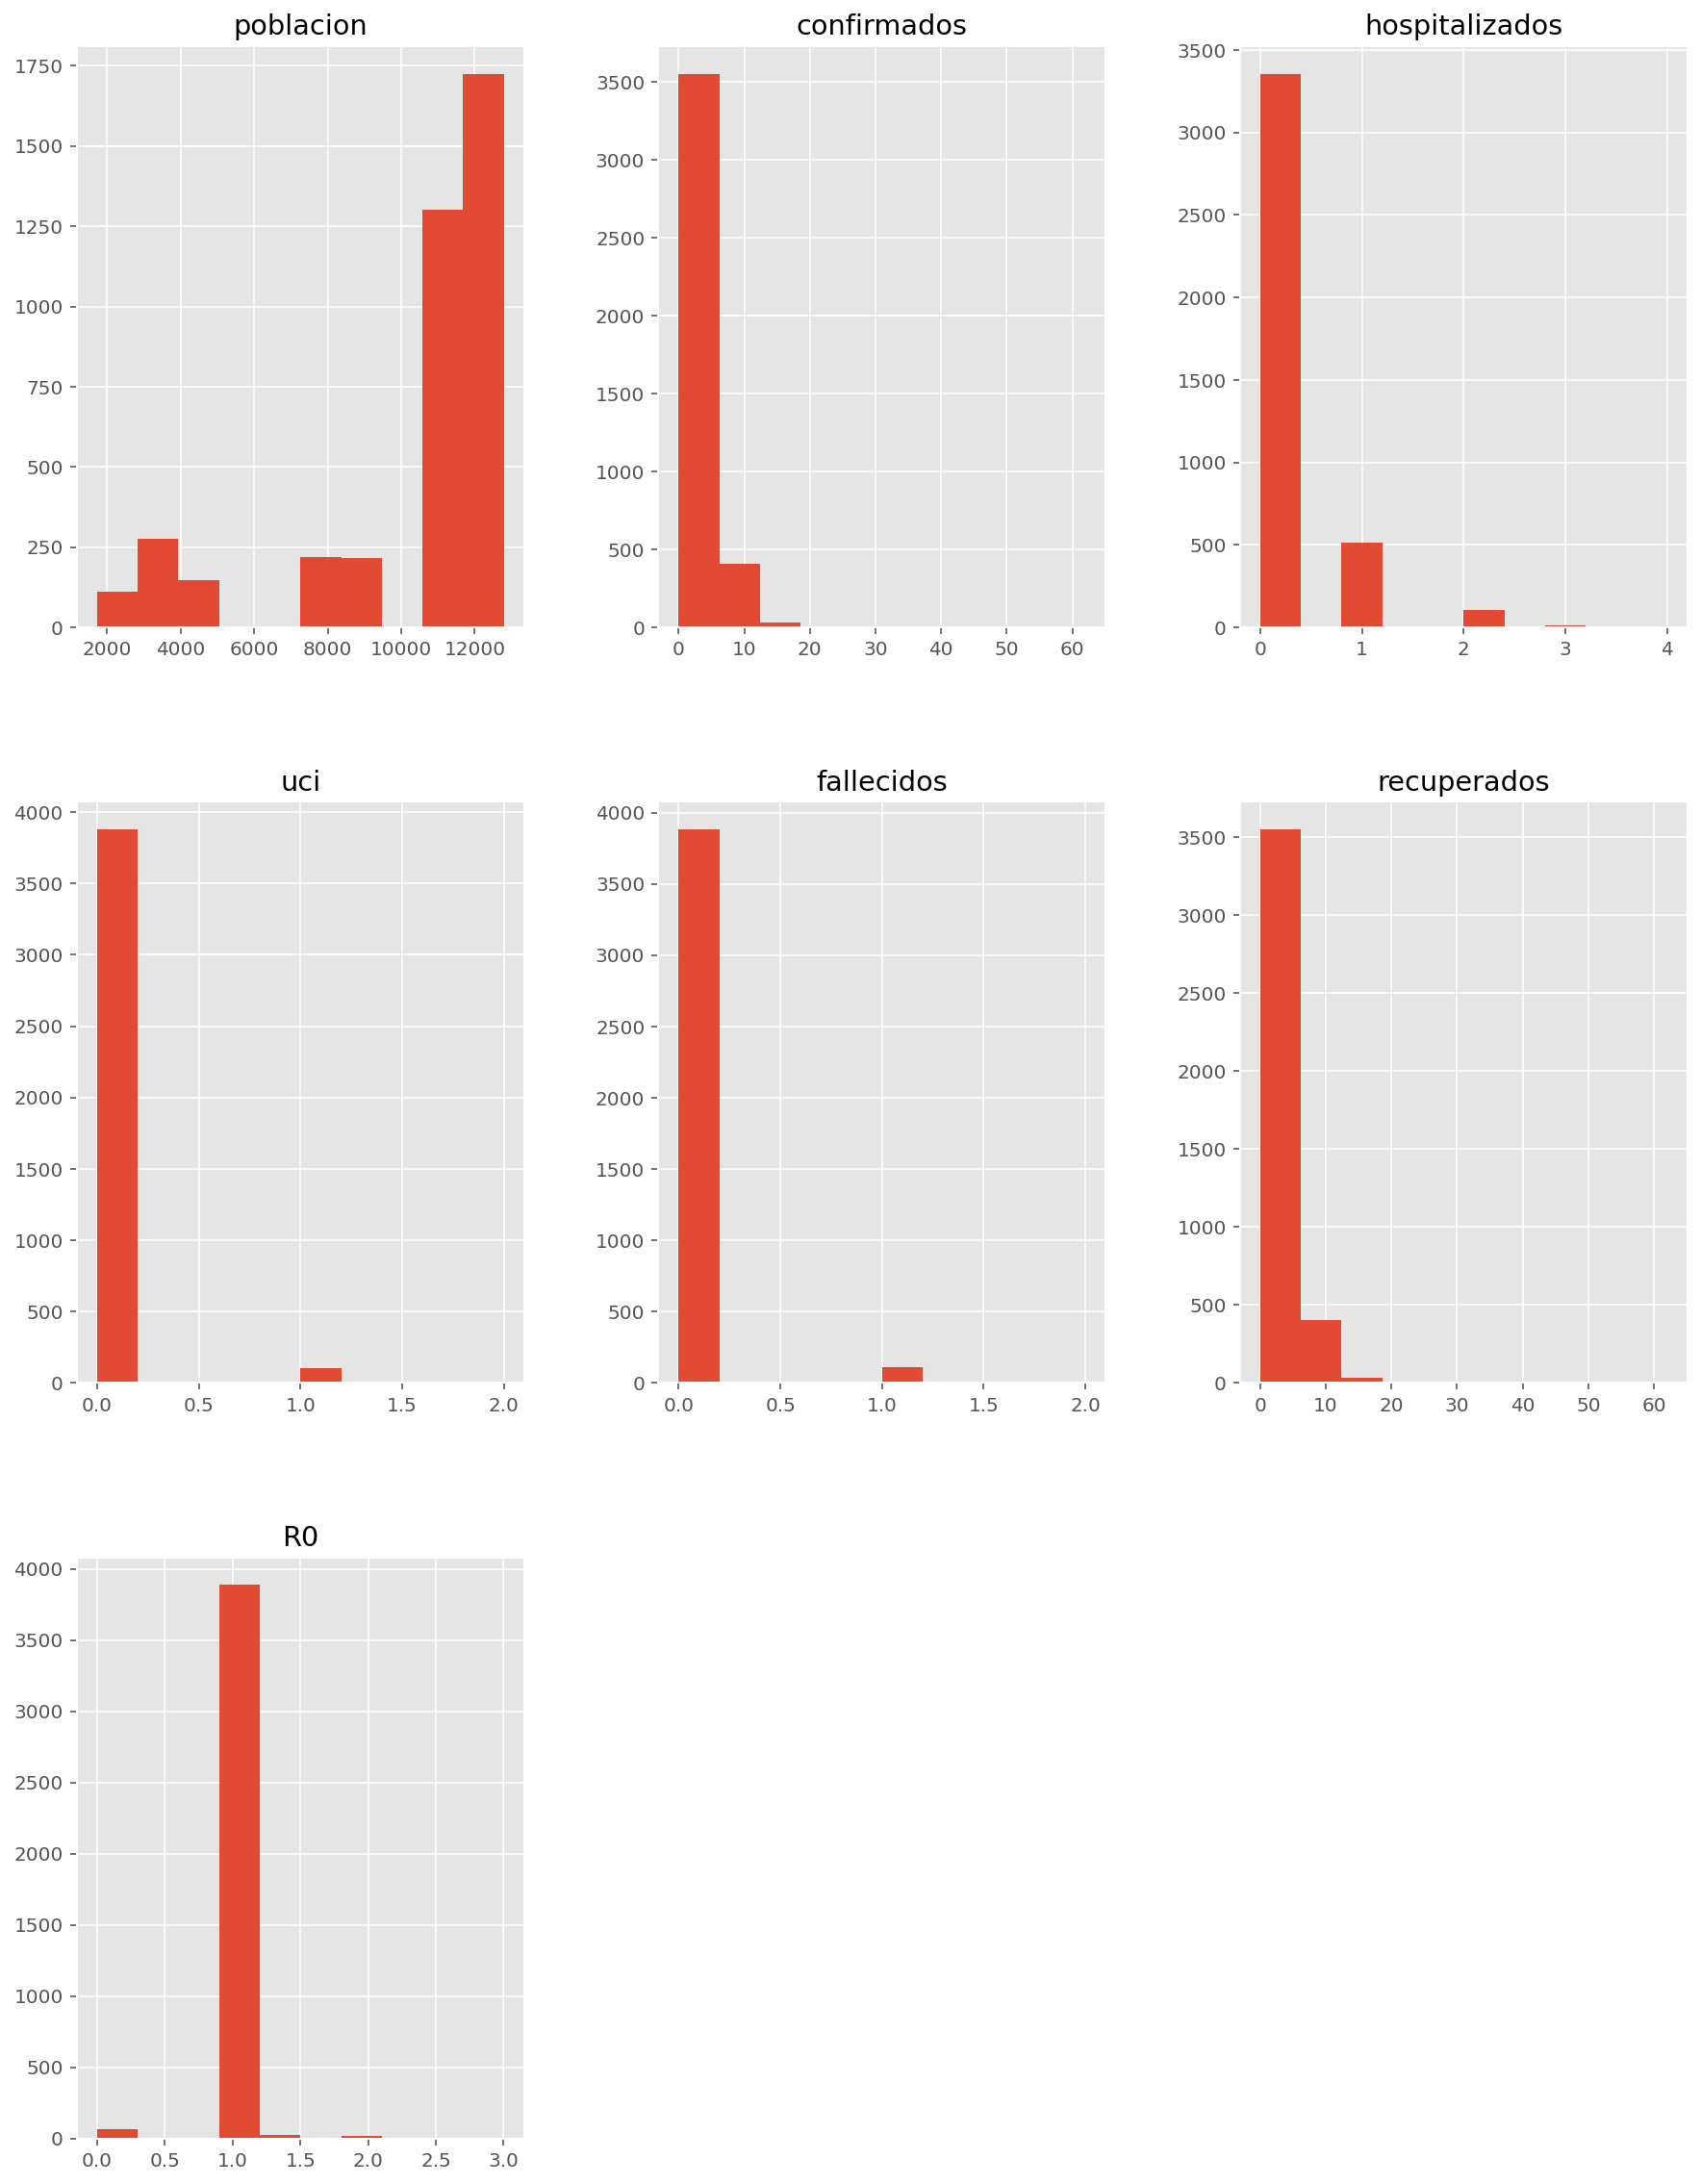

In [284]:
# HISTOGRAMA
fig = plt.figure(figsize = (15,20))
ax = fig.gca()
bd_epidem_cm.hist(ax = ax)